# Google Analytics Customer Revenue

# **Objetivo**

A partir de los datos recopilados por Google Analytics de una e-commerce, se quiere predecir los ingresos por las transacciones hechas cada vez que un usuario entre en la página web.

# **Documentación**

- Numpy --> https://numpy.org/doc/stable/reference/index.html
- Pandas --> https://pandas.pydata.org/pandas-docs/stable/reference/index.html
- Scikit-Learn --> https://scikit-learn.org/stable/
- Sklearn (Api Reference) --> https://scikit-learn.org/stable/modules/classes.html
- Estilos pyplot --> https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
- Parámetros XGBoost --> https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst

# **Clases y funciones**

In [1]:
# Elimina duplicados
def drop_duplicates (df):
    '''
    Elimina filas duplicadas del dataset
    '''
    print(f"{df.shape}")
    df_duplicated = df[df.duplicated(keep = False)]
    print(f"Se han eliminado {len(df[df.duplicated()])} registros repetidos")
    df.drop_duplicates(inplace = True)
    print(f"{df.shape}")

    return df_duplicated

In [2]:
# Eliminación de variables numéricas con baja varianza
def varianza_nula (dataframe, std):
    ''' 
    Elimina variables numéricas con baja varianza    
    '''

    df_numerical_describe = dataframe.describe(include=np.number).T
    lista_numerica_baja_varianza = df_numerical_describe[(df_numerical_describe['std']<std)].index.tolist() # Indico la desviación típica (0.15)
    dataframe.drop(lista_numerica_baja_varianza, axis=1, inplace=True)
    print('Se han borrado las siguientes variables numéricas por tener baja varianza:\n',lista_numerica_baja_varianza )

    return dataframe.head()

# **1. IMPORTACIÓN DE LIBRERÍAS**

In [3]:
import sys
import os 

# silence warnings
import warnings
warnings.filterwarnings("ignore")

import random
import json 
from pandas.io.json import json_normalize # normaliza los datos en formato json

import numpy as np # Arrays
import pandas as pd # Series and Dataframes

# Para tratar variables con fechas
from datetime import datetime

# Modeling
from sklearn import model_selection
import xgboost as xgb

# Plotting
import matplotlib.pyplot as plt 
plt.style.use('ggplot') # Estilo pyplot (ggplot proviene de R --> Beautify Plots)
import seaborn as sns # Advanced Plotting
from scipy import stats # Para estadística (por ejemplo para decirnos si una distribución es normal)

# cargamos archivos desde el colab
#from google import files
#from google import drive

pd.options.display.max_rows = 100

# Garantiza que la aleatoriedad sea siempre la misma
RANDOM_STATE = 42

# **2. IMPORTACIÓN DE DATOS**

In [4]:
#Si se usa Colab monto la carpeta en la que tengo los datos
'''
drive.mount('/content/gdrive')
'''

"\ndrive.mount('/content/gdrive')\n"

In [5]:
# Genero las carpetas que se van a utilizar a lo largo del notebook
import os
for i in ['data', 'report', 'pickle', 'final']:
    try:
        os.mkdir(i)
    except FileExistsError:
        pass

Descargamos los datos y los metemos en la carpeta 'data': https://drive.google.com/file/d/1quBZ75bubrnaPD3jUBsuc7lWM23jnFcy/view?usp=drive_link

In [6]:
# Asigno la ruta actual
file_dir = os.chdir('D:\Data_Science\MACHINE_LEARNING\ML_SUPERVISADO\ML_SUPERVISADO_REGRESION\Machine-Learning-Regression-GACR') 
file_name = '\data\GACR.csv'
# Veo la ruta actual
file_dir = os.getcwd() 
file_dir

'D:\\Data_Science\\MACHINE_LEARNING\\ML_SUPERVISADO\\ML_SUPERVISADO_REGRESION\\Machine-Learning-Regression-GACR'

In [7]:
file_dir+file_name

'D:\\Data_Science\\MACHINE_LEARNING\\ML_SUPERVISADO\\ML_SUPERVISADO_REGRESION\\Machine-Learning-Regression-GACR\\data\\GACR.csv'

In [8]:
pd.read_csv??

Signature:
pd.read_csv(
    filepath_or_buffer: 'FilePath | ReadCsvBuffer[bytes] | ReadCsvBuffer[str]',
    sep=<no_default>,
    delimiter=None,
    header='infer',
    names=<no_default>,
    index_col=None,
    usecols=None,
    squeeze=None,
    prefix=<no_default>,
    mangle_dupe_cols=True,
    dtype: 'DtypeArg | None' = None,
    engine: 'CSVEngine | None' = None,
    converters=None,
    true_values=None,
    false_values=None,
    skipinitialspace=False,
    skiprows=None,
    skipfooter=0,
    nrows=None,
    na_values=None,
    keep_default_na=True,
    na_filter=True,
    verbose=False,
    skip_blank_lines=True,
    parse_dates=None,
    infer_datetime_format=False,
    keep_date_col=False,
    date_parser=None,
    dayfirst=False,
    cache_dates=True,
    iterator=False,
    chunksize=None,
    compression: 'CompressionOptions' = 'infer',
    thousands=None,
    decimal: 'str' = '.',
    lineterminator=None,
    quotechar='"',
    quoting=0,
    doublequote=True,
    esc

**Como tengo un dataset muy grande, hago una partición pequeña para poder trabajar de forma rápida con ella, y finalmente, cuando tenga definidos todos los procesos, los aplico al datset entero**

In [9]:
## Función de lectura para las columnas que están en formato json
columns = ['device', 'geoNetwork', 'totals'] # Columnas con datos en formato json

random.seed(10) # Nos aseguramos de cargar siempre la misma partición aleatoria (tiene la misma función que el random_state del DecisionTree)
p = 0.1 # Usamos el 10% del dataset


def json_read(df):
    data_frame = file_dir + df
    
    # Leo el csv con una proporción "p"
    df = pd.read_csv(data_frame, 
                     converters = {column: json.loads for column in columns}, # cargo las columnas que tienen formato json
                     dtype = {'fullVisitorId': 'str'}, # La pongo como string (sino me la pone numérica)
                     skiprows = lambda i: i>0 and random.random() > p) # Lee el porcentaje "p" del total de las variables
    
    # Desjeisonizo las columnas
    for column in columns: # grupos
        column_as_df = json_normalize(df[column]) # donde había una celda con diferentes valores, los separa en columnas distintas (subgrupos)
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns] # Renombro las columnas distintas (grupo.subgrupo)
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True) # Elimino las columnas con formato json y junto todo
        
    print(f"Loaded {os.path.basename(data_frame)}. Shape: {df.shape}")
    return df

Cargamos el dataset y le pasamos el comando mágico %%, añadiendo time para saber el tiempo de carga

In [10]:
%%time
df = json_read(df = file_name)

Loaded GACR.csv. Shape: (90306, 42)
Wall time: 37.2 s


Comprobamos que no haya ningún **registro duplicado**

In [11]:
drop_duplicates(df)

(90306, 42)
Se han eliminado 0 registros repetidos
(90306, 42)


,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue


# **3. DATA UNDERSTANDING**  --> *EDA (Exploratory Data analysis)*

## **3.1. Análisis Univariante de Datos**

### 2.1.1 Tamaño del dataset



**A.- Data Size**

In [12]:
# Tamaño del datset
df.size

3792852

In [13]:
# Número de filas y columnas
df.shape

(90306, 42)

In [14]:
# Información resumida del dataset
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90306 entries, 0 to 90305
Columns: 42 entries, Unnamed: 0 to totals.transactionRevenue
dtypes: bool(1), int64(5), object(36)
memory usage: 29.0+ MB


Tenemos 36 variables objeto que tendremos que pasar a numéricas. El deadline del proyecto estará entorno a 2-3 semanas

**B.- Visualización directa de los datos**

In [15]:
# Columnas del dataset
df.columns

Index(['Unnamed: 0', 'channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
  

In [16]:
# 5 primeros registros
df.head().T

,0,1,2,3,4
Unnamed: 0,13,27,28,37,43
channelGrouping,Organic Search,Organic Search,Referral,Organic Search,Organic Search
date,20160902,20160902,20160902,20160902,20160902
fullVisitorId,1438082600262726746,1283542838194038522,4339756682310369249,062441254657008214,1381975521299261523
sessionId,1438082600262726746_1472803483,1283542838194038522_1472885255,4339756682310369249_1472828340,062441254657008214_1472875520,1381975521299261523_1472829727
socialEngagementType,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged
visitId,1472803483,1472885255,1472828340,1472875520,1472829727
visitNumber,1,1,1,1,1
visitStartTime,1472803483,1472885255,1472828340,1472875520,1472829727
device.browser,Safari,Safari,Chrome,Chrome,Chrome


In [17]:
# 5 registros aleatorios
df.sample(5).T

,18782,1328,52218,88031,47217
Unnamed: 0,189961,13239,522357,881452,473156
channelGrouping,Social,Social,Organic Search,Organic Search,Organic Search
date,20160901,20160811,20170603,20161019,20170222
fullVisitorId,6123965036917167631,4895187008328298603,4076463815754499010,816471424120903829,5310502070074179206
sessionId,6123965036917167631_1472724028,4895187008328298603_1470977163,4076463815754499010_1496487499,0816471424120903829_1476934293,5310502070074179206_1487756304
socialEngagementType,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged
visitId,1472724028,1470977163,1496487499,1476934293,1487756304
visitNumber,1,1,1,1,1
visitStartTime,1472724028,1470977163,1496487499,1476934293,1487756304
device.browser,Safari,Chrome,Chrome,Chrome,Chrome


In [18]:
# 5 últimos registros
df.tail().T

,90301,90302,90303,90304,90305
Unnamed: 0,903617,903623,903642,903647,903648
channelGrouping,Social,Social,Social,Social,Social
date,20170104,20170104,20170104,20170104,20170104
fullVisitorId,8316382343226738015,6636384798982309878,469840327005431380,2140149974339316233,5123779100307500332
sessionId,8316382343226738015_1483549157,6636384798982309878_1483525429,469840327005431380_1483573235,2140149974339316233_1483557808,5123779100307500332_1483554750
socialEngagementType,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged
visitId,1483549157,1483525429,1483573235,1483557808,1483554750
visitNumber,1,1,1,1,1
visitStartTime,1483549157,1483525429,1483573235,1483557808,1483554750
device.browser,Chrome,Chrome,Internet Explorer,Chrome,Chrome


Cada fila del dataset va a ser una sesión, una misma persona puede tener varias sesiones. Por lo tanto tengo un identificador único que es el sessionId, que es único para cada fila. Por lo tanto esta variable no me va a ayudar a nivel de predicción.

Lo vamos a mantener por si lo necesitamos para hacer joins o cualquier otra operación que nos sirva de nexo de unión.

***Información del dataset***

En Google Analytics, en las adquisiciones tenemos la fuente (google, bing, yahoo, ...) y el medio mediante el cual el usuario accede a mi web (trafico de pago o CPC, tráfico orgánico o no forzado, tráfico directo, tráfico referido o que accede a mi web desde otros sitios que no son búsquedas, .... )

- 'channelGrouping', cómo adquiere la plataforma el tráfico hacia mi web
- 'date', 
- 'fullVisitorId' es el Id que está en las cookies. Si no cambio las cookies y entro en la web seguiré teniendo el mismo fullVisitorID
- 'sessionID', es el identificador único de cada registro. Me dice quién ha entrado y cuándo ha entrado.
- 'socialEngagementType', debe ser una variable propia de la plataforma ya que no existe en Analytics
- 'visitID', es el identificador que voy a tener cada vez que acceda a la página web (ya que puedo acceder más de una vez). Me vale para saber el conteo de sesiones que hace cada fullVisitorID
- 'visitNumber', 
- 'visitStartTime', tiene los mismos valores que el visitID, por lo tanto una de las dos sobra. Es una fecha que viene en segundos desde 1970. Momento en que hago la visita
- 'device.browser', los device son las características del dispositivo con el que estoy accediendo a la página
- 'device.browserVersion', 'device.browserSize', 'device.operatingSystem', 'device.operatingSystemVersion', 
- 'device.isMobile', si el dispositivo es un móvil o no
- 'device.mobileDeviceBranding', 'device.mobileDeviceModel', 'device.mobileInputSelector',  'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 
- 'device.flashVersion', 'device.language', 'device.screenColors', 'device.screenResolution', 'device.deviceCategory', 
- 'geoNetwork.continent', los geoNetworks nos da los datos de geolocalización
- 'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.cityId', 'geoNetwork.networkDomain', 
- 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 
- 'totals.visits', número de visitas
- 'totals.hits', número de clicks que hago
- 'totals.pageviews', número de landing page que visito
- 'totals.bounces', si rebotas del servidor (por ejemplo si pasas de una landing page a otra y te tira fuera porque está roto el link u otra razón)
- 'totals.newVisits', indicador que dice si es una nueva visita o no
- 'totals.transactionRevenue indica si en una sesión (sesionId) hubo una transacción, y en caso de haberla de qué cantidad es --> es nuestro **target**

In [19]:
# Metemos como índice del dataset del sessionID
df.set_index('sessionId', inplace=True)
df.head(1)

,Unnamed: 0,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,...,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue
sessionId,,,,,,,,,,,,,,,,,,,,,
1438082600262726746_1472803483,13,Organic Search,20160902,1438082600262726746,Not Socially Engaged,1472803483,1,1472803483,Safari,not available in demo dataset,...,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN


In [20]:
# Borramos los otros ids (el session_Id contiene estos ids)
df_ids = ['fullVisitorId', 'visitId']
df.drop(df_ids, axis=1, inplace=True)
df.head(1)

,Unnamed: 0,channelGrouping,date,socialEngagementType,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,...,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue
sessionId,,,,,,,,,,,,,,,,,,,,,
1438082600262726746_1472803483,13,Organic Search,20160902,Not Socially Engaged,1,1472803483,Safari,not available in demo dataset,not available in demo dataset,iOS,...,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN


**C.- Tipo de atributos disponibles**

Vemos si los atributos de nuestro dataframe son numéricos o categóricos. Se clasifican, de menor a mayor espacio que ocupan, en:

Numeros (continuas)
*  Integer: numero sin decimales
*  Float: numero con decimales

Categoricas (discretas)
*   Boolean: Si/No, True/False o 1/0
*   Category: un numero finito de etiquetas (NO permite introducir nuevas etiquetas)
*   Object: un numero "infinito" de etiquetas (SI permite introducir nuevas etiquetas)
*   String: libertad maxima (hay que evitarlas ya que ocupan mucha memoria)

In [21]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 90306 entries, 1438082600262726746_1472803483 to 5123779100307500332_1483554750
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Unnamed: 0                        90306 non-null  int64 
 1   channelGrouping                   90306 non-null  object
 2   date                              90306 non-null  int64 
 3   socialEngagementType              90306 non-null  object
 4   visitNumber                       90306 non-null  int64 
 5   visitStartTime                    90306 non-null  int64 
 6   device.browser                    90306 non-null  object
 7   device.browserVersion             90306 non-null  object
 8   device.browserSize                90306 non-null  object
 9   device.operatingSystem            90306 non-null  object
 10  device.operatingSystemVersion     90306 non-null  object
 11  device.isMobile                

**D.- Estadísticos descriptivos básicos y distribución de los nulos**

Mediante el método **describe()**, podemos obtener los estadísticos representativos de cada uno de los atributos del DataFrame.

In [22]:
# Atributos numéricos
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,90306.0,4.531874e+05,2.605409e+05,1.300000e+01,2.280235e+05,4.528250e+05,6.791640e+05,9.036480e+05
date,90306.0,2.016589e+07,4.697568e+03,2.016080e+07,2.016103e+07,2.017011e+07,2.017042e+07,2.017080e+07
visitNumber,90306.0,2.254269e+00,9.102378e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.730000e+02
visitStartTime,90306.0,1.485020e+09,9.027413e+06,1.470035e+09,1.477570e+09,1.483985e+09,1.492787e+09,1.501656e+09


- Ningún atributo tiene nulos
- Unnamed: 0 --> Lo voy a eliminar
- date y visitStartTime son fechas
- visitNumber sí es numérica, es la única que realmente es numérica

In [23]:
# Atributos categoricos
df.describe(exclude=np.number).T

,count,unique,top,freq
channelGrouping,90306,8,Organic Search,38445
socialEngagementType,90306,1,Not Socially Engaged,90306
device.browser,90306,28,Chrome,62147
device.browserVersion,90306,1,not available in demo dataset,90306
device.browserSize,90306,1,not available in demo dataset,90306
device.operatingSystem,90306,17,Windows,35174
device.operatingSystemVersion,90306,1,not available in demo dataset,90306
device.isMobile,90306,2,False,66571
device.mobileDeviceBranding,90306,1,not available in demo dataset,90306
device.mobileDeviceModel,90306,1,not available in demo dataset,90306


- totals.pageviews, totals.bounces, totals.newVisits y totals.transactionRevenue tienen nulos.
- Los nulos de totals.pageviews	los podemos rellenar con lo que queramos (media, moda, mediana, ... ) porque al ser sólo 10 nulos no me va a afectar.
- Los nulos de totals.bounces y totals.newVisits no me preocupan ya que sólo tienen una etiqueta por lo que los nulos los rellenamos con un cero. Un cero en totals.bounces significa que el usuario no ha sido rebotado y un cero en totals.newVisits significa que el usuario ya ha visitado la página en ocasiones anteriores. Por lo tanto convertiremos estas variables en booleanas.
- Todas las variables que no tienen nulos y tienen un unique=1, puedo eliminarlas por ser variables de varianza nula (una sóla etiqueta), y no me van a ayudar a predecir

*Variables de baja varianza*

Son variables que van a ser irrelevantes para el modelo (no le van a aportar información relevante).

Se eliminan aquellas **variables numéricas** cuya varianza sea inferior a 0.15

In [24]:
varianza_nula (dataframe = df, std = 0.15)

Se han borrado las siguientes variables numéricas por tener baja varianza:
 []


,Unnamed: 0,channelGrouping,date,socialEngagementType,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,...,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue
sessionId,,,,,,,,,,,,,,,,,,,,,
1438082600262726746_1472803483,13,Organic Search,20160902,Not Socially Engaged,1,1472803483,Safari,not available in demo dataset,not available in demo dataset,iOS,...,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN
1283542838194038522_1472885255,27,Organic Search,20160902,Not Socially Engaged,1,1472885255,Safari,not available in demo dataset,not available in demo dataset,Macintosh,...,broadband.hu,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN
4339756682310369249_1472828340,28,Referral,20160902,Not Socially Engaged,1,1472828340,Chrome,not available in demo dataset,not available in demo dataset,Android,...,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN
062441254657008214_1472875520,37,Organic Search,20160902,Not Socially Engaged,1,1472875520,Chrome,not available in demo dataset,not available in demo dataset,Windows,...,uwa.edu.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN
1381975521299261523_1472829727,43,Organic Search,20160902,Not Socially Engaged,1,1472829727,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,...,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN


En este dataset, encontramos 17 **variables categóricas sin varianza** (aquellas que no tienen nulos y tienen una sóla etiqueta) que tienen un unique=1. Es por ello que la información que le aportan estos atributos al modelo es irrelevante. **Las eliminamos**.

In [25]:
df.columns

Index(['Unnamed: 0', 'channelGrouping', 'date', 'socialEngagementType',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.browserVersion', 'device.browserSize', 'device.operatingSystem',
       'device.operatingSystemVersion', 'device.isMobile',
       'device.mobileDeviceBranding', 'device.mobileDeviceModel',
       'device.mobileInputSelector', 'device.mobileDeviceInfo',
       'device.mobileDeviceMarketingName', 'device.flashVersion',
       'device.language', 'device.screenColors', 'device.screenResolution',
       'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.cityId',
       'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.transactionRevenue'],
      

In [26]:
# Lista de variables con 1 etiqueta aplicando un for loop
constant_columns = []
for column in df.columns:
    if df[column].nunique(dropna = False) == 1: # Especifico False para que me cuente como 2 aquellas variables que vimos con nulos y que vamos a convertir en booleanas
        constant_columns.append(column)
constant_columns

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits']

Cuando se hace un for loop y como resultado tengamos una lista, siempre podemos hacer uso de una list comprehension con una sóla línea de código

In [27]:
# Hacemos lo mismo pero usando una list comprehension
constant_columns = [column for column in df.columns if df[column].nunique(dropna = False) == 1]
constant_columns

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits']

In [28]:
# Elimino las variables de la lista anterior
df.drop(constant_columns, axis=1, inplace=True)

In [29]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 90306 entries, 1438082600262726746_1472803483 to 5123779100307500332_1483554750
Columns: 21 entries, Unnamed: 0 to totals.transactionRevenue
dtypes: bool(1), int64(4), object(16)
memory usage: 14.6+ MB


In [30]:
df.head(2).T

sessionId,1438082600262726746_1472803483,1283542838194038522_1472885255
Unnamed: 0,13,27
channelGrouping,Organic Search,Organic Search
date,20160902,20160902
visitNumber,1,1
visitStartTime,1472803483,1472885255
device.browser,Safari,Safari
device.operatingSystem,iOS,Macintosh
device.isMobile,True,False
device.deviceCategory,mobile,desktop
geoNetwork.continent,Asia,Europe


In [31]:
df_description = df.describe(include='all').T
df_description

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,90306.0,NaN,NaN,NaN,453187.353044,260540.883169,13.0,228023.5,452825.0,679164.0,903648.0
channelGrouping,90306,8,Organic Search,38445,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,90306.0,NaN,NaN,NaN,20165894.915122,4697.567567,20160801.0,20161027.0,20170109.0,20170421.0,20170801.0
visitNumber,90306.0,NaN,NaN,NaN,2.254269,9.102378,1.0,1.0,1.0,1.0,373.0
visitStartTime,90306.0,NaN,NaN,NaN,1485020394.767092,9027412.838579,1470035170.0,1477570329.25,1483984659.0,1492787453.0,1501655878.0
device.browser,90306,28,Chrome,62147,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device.operatingSystem,90306,17,Windows,35174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device.isMobile,90306,2,False,66571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device.deviceCategory,90306,3,desktop,66572,NaN,NaN,NaN,NaN,NaN,NaN,NaN
geoNetwork.continent,90306,6,Americas,44890,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Guardamos el describe en un csv para poder trabajar con el
df_description.to_csv('report/df_description.csv')

In [33]:
# Si trabajo en Colab me lo descargo
# files.download('report/df_description.csv')

**E.- Distribución de los atributos**

***Análisis del Target***

En un problema de clasificación supervisada, es importante conocer la distribución del target.\
Se trata de un target numérico continuo, con lo que tengo que revisar su distribución.

In [34]:
# Defino el target
target = 'totals.transactionRevenue'

In [35]:
df[target].head()

sessionId
1438082600262726746_1472803483    NaN
1283542838194038522_1472885255    NaN
4339756682310369249_1472828340    NaN
062441254657008214_1472875520     NaN
1381975521299261523_1472829727    NaN
Name: totals.transactionRevenue, dtype: object

In [36]:
# Veo los valores no nulos del target para saber cómo son
df[df[target].notnull()][target].head(10)

sessionId
8885051388942907862_1472827393     68030000
3351538799616866750_1472855945      8380000
770431600902969839_1472836071      24080000
1546626226233851002_1472837482    546320000
8516473451212465925_1472845932    339030000
3152246617474456269_1472828860    635500000
1095886019324498043_1472835680    305470000
987390821892515431_1498241858      25000000
0115940065332308119_1498241851    109150000
2665204442613686910_1498232978     13290000
Name: totals.transactionRevenue, dtype: object

In [37]:
df[target].value_counts()

33590000     25
16990000     24
44790000     20
18990000     14
19990000     10
             ..
8790000       1
300850000     1
16960000      1
26380000      1
41810000      1
Name: totals.transactionRevenue, Length: 820, dtype: int64

In [38]:
df[target].describe()

count         1110
unique         820
top       33590000
freq            25
Name: totals.transactionRevenue, dtype: object

1. Es object y debería ser numérico (es un target)
2. El top es un valor muy alto --> no tiene bien los decimales (Google Analytics nos da este formato)
3. Tiene nulos. El nulo lo rellenamos con un 0 (no hay transacción de compra)

*1. Lo convertimos en numérico*

In [39]:
df[target] = df[target].astype(float) # lo pongo como float porque hay decimales

In [40]:
df[target].describe()

count    1.110000e+03
mean     1.287345e+08
std      2.626953e+08
min      2.000000e+05
25%      2.548000e+07
50%      5.118000e+07
75%      1.094425e+08
max      4.198500e+09
Name: totals.transactionRevenue, dtype: float64

*2. Elimino los nulos*

In [41]:
# Relleno los nulos con un 0
df[target].fillna(0.0, inplace=True)

In [42]:
df[target].describe()

count    9.030600e+04
mean     1.582345e+06
std      3.238319e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.198500e+09
Name: totals.transactionRevenue, dtype: float64

*3. Pongo bien los decimales*

In [43]:
# Divido entre 10^6
df[target] = df[target] / 1000000

In [44]:
df[target].describe()

count    90306.000000
mean         1.582345
std         32.383189
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4198.500000
Name: totals.transactionRevenue, dtype: float64

Vemos que realizan compra muy pocos, por lo que tenemos una distribución muy sesgada hacia el 0. Métricas como la media son muy males para este tipo de distribución (está teniendo en cuenta los ceros).

Vemos el target para aquella parte del dataset en la que sí hay compras

In [45]:
# Target con compras
df[df[target]>0][target].describe()

count    1110.000000
mean      128.734486
std       262.695306
min         0.200000
25%        25.480000
50%        51.180000
75%       109.442500
max      4198.500000
Name: totals.transactionRevenue, dtype: float64

- Si la distribución es normal --> media y mediana deben ser más o menos iguales
- Si la distribución está tirada a la izquierda --> la media es mucho más alta que la mediana (la mayoría son importes bajos y unos pocos son importes altos)
- Si la distribución está tirada a la derecha --> la media es mucho más baja que la mediana (la mayoría son importes altos y unos pocos son importes bajos)

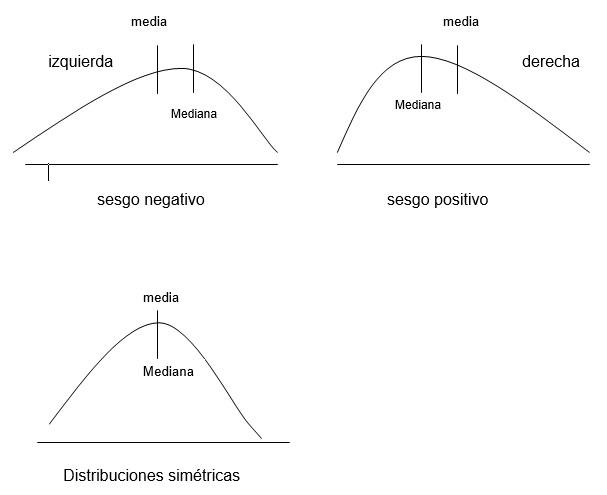

In [46]:
from IPython.display import Image
Image('pictures/sesgos_distribucion.jpg')

Muchas de las cosas que vamos a analizar están relacionadas con compras o sin compras. Creamos una variable que nos indique esto. Después de utilizarla, tendremos que eliminarla sino el algortimo la tendrá en cuenta (y en realidad esta información no existe)

***Si queremos hacer un modelo que prediga si alguien compra o no (clasificación binaria), utilizaríamos esta variable como target***

In [47]:
# Variable que indica que se ha hecho compra
df['visitWithTransaction'] = (df[target] > 0).astype(int) # La convierto en booleana 0/1

In [48]:
df.head().T

sessionId,1438082600262726746_1472803483,1283542838194038522_1472885255,4339756682310369249_1472828340,062441254657008214_1472875520,1381975521299261523_1472829727
Unnamed: 0,13,27,28,37,43
channelGrouping,Organic Search,Organic Search,Referral,Organic Search,Organic Search
date,20160902,20160902,20160902,20160902,20160902
visitNumber,1,1,1,1,1
visitStartTime,1472803483,1472885255,1472828340,1472875520,1472829727
device.browser,Safari,Safari,Chrome,Chrome,Chrome
device.operatingSystem,iOS,Macintosh,Android,Windows,Macintosh
device.isMobile,True,False,True,False,False
device.deviceCategory,mobile,desktop,mobile,desktop,desktop
geoNetwork.continent,Asia,Europe,Asia,Oceania,Asia


In [49]:
df[df['visitWithTransaction']==1][target].describe()

count    1110.000000
mean      128.734486
std       262.695306
min         0.200000
25%        25.480000
50%        51.180000
75%       109.442500
max      4198.500000
Name: totals.transactionRevenue, dtype: float64

In [50]:
# Número de visitas totales
df['visitWithTransaction'].count()

90306

In [51]:
# Número de visitas que terminan en compra
df['visitWithTransaction'].sum()

1110

In [52]:
# Valor medio de las visitas que acaban en compra
df['visitWithTransaction'].mean() * 100

1.2291542090226564

Sólo el 1,3% de las visitas acaban en compra, por lo que tengo un **dataset tremendamente desbalanceado** (si hiciera un problema de clasificación binaria con esta variable como target, el accuracy sería muy mala métrica). 

Para datasets desbalanceadas, al algoritmo le cuesta mucho aprender, por lo que este **dataset tendremos que rebalancearlo** más adelante.

In [53]:
print('De las {} visitas, hay {} con compras, lo que significa que el {} por ciento de las visitas tienen compra'.format(
    df['visitWithTransaction'].count(),
    df['visitWithTransaction'].sum(),
    df['visitWithTransaction'].mean() * 100
))

De las 90306 visitas, hay 1110 con compras, lo que significa que el 1.2291542090226564 por ciento de las visitas tienen compra


*Ploteamos el target para visualizar su distribución*

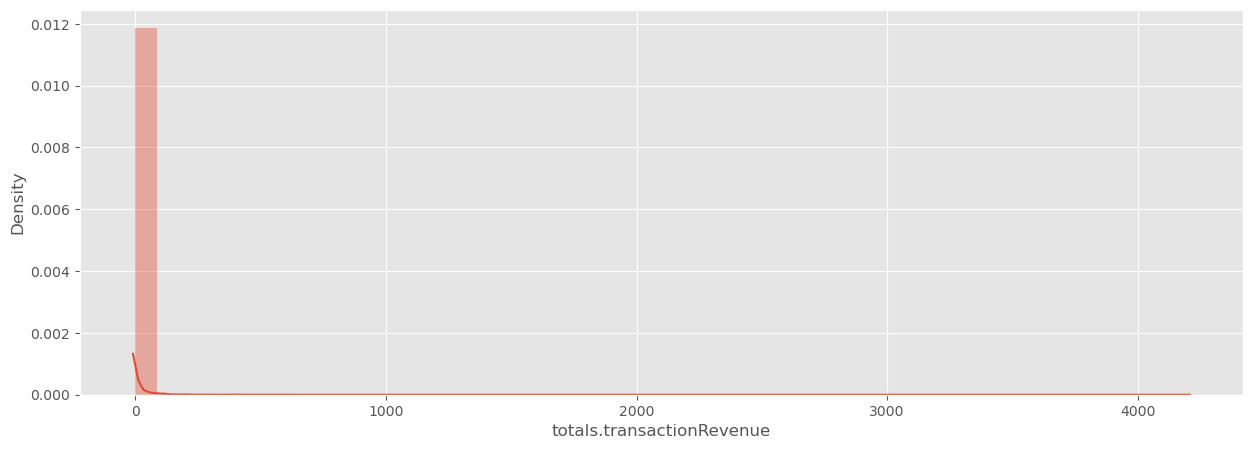

In [54]:
# Distribución de la variable target al completo
plt.figure(figsize=(15, 5))
sns.distplot( # distribuition plot
    df[target]
);

Debido a todos los 0 que hay (visitas sin compras), vemos que la distribución está muy tirada a la izquierda.

*Ploteamos el target que tiene compras para ver su distribución*

Lo podemos hacer con la variable target o con la variable visitWithTransaction

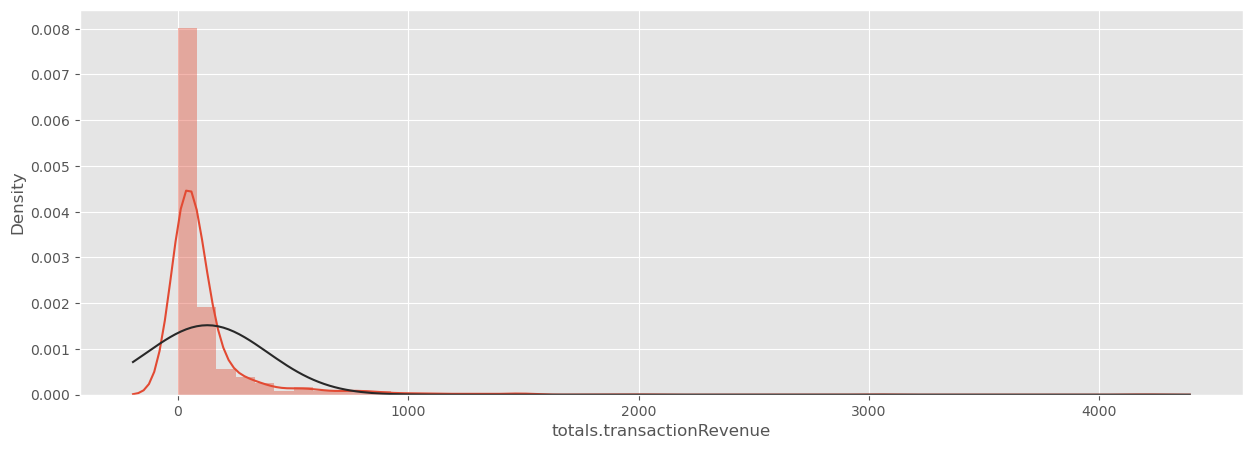

In [55]:
# Distribución con la variable visitWithTransaction
plt.figure(figsize=(15, 5))
sns.distplot(
    df[df['visitWithTransaction'] == 1][target],
    fit = stats.norm # Pinta la distribucion normal de lo que le estoy pasando --> N(mean=128.734486, std=262.695306)
);

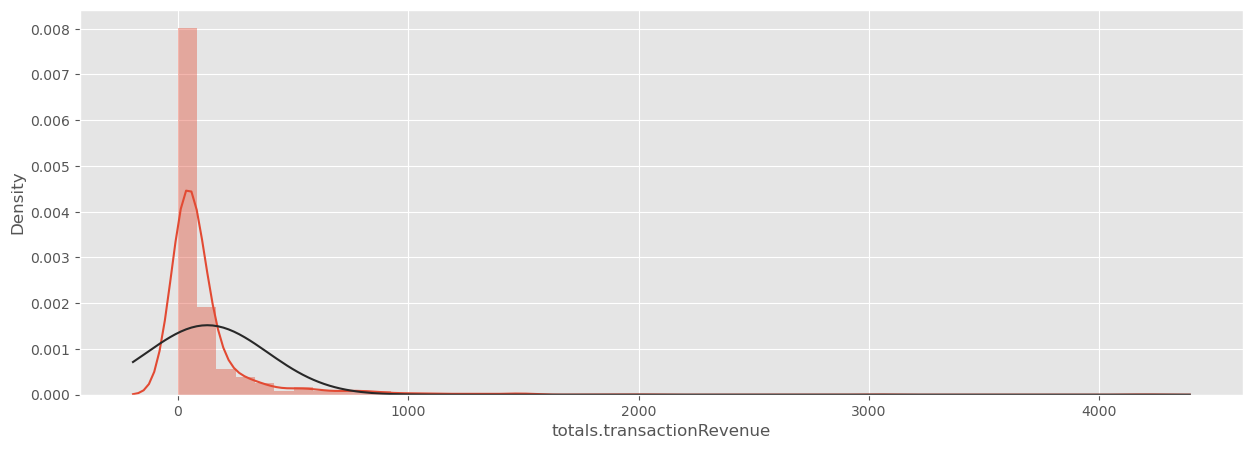

In [56]:
# Distribución con target
plt.figure(figsize=(15, 5))
sns.distplot(
    df[df[target] > 0][target],
    fit = stats.norm # Pinta la distribucion normal de lo que le estoy pasando --> N(mean=128.734486, std=262.695306)
);

Vemos que la distribución no está tan tirada a la izquierda como antes, pero sigue estando muy desbalanceada. Por lo tanto, **el target no tiene una distribución normal**.

Si yo quiero utilizar una regresión lineal, por ejemplo, necesito que haya una relación lineal entre el target y el atributo. Lo mejor para asegurarme que voy a tener una relación lineal es forzar al **target a que tenga una distribución normal (tendré que cambiar el target y también los atributos)**. Aplicaremos una ***transformación logarítmica***

In [57]:
df['totals.transactionRevenue'].head()

sessionId
1438082600262726746_1472803483    0.0
1283542838194038522_1472885255    0.0
4339756682310369249_1472828340    0.0
062441254657008214_1472875520     0.0
1381975521299261523_1472829727    0.0
Name: totals.transactionRevenue, dtype: float64

***Transformación logaritmica del target***

In [58]:
np.log1p??

Call signature:  np.log1p(*args, **kwargs)
Type:            ufunc
String form:     <ufunc 'log1p'>
File:            c:\users\jagui\anaconda3\lib\site-packages\numpy\__init__.py
Docstring:      
log1p(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])

Return the natural logarithm of one plus the input array, element-wise.

Calculates ``log(1 + x)``.

Parameters
----------
x : array_like
    Input values.
out : ndarray, None, or tuple of ndarray and None, optional
    A location into which the result is stored. If provided, it must have
    a shape that the inputs broadcast to. If not provided or None,
    a freshly-allocated array is returned. A tuple (possible only as a
    keyword argument) must have length equal to the number of outputs.
where : array_like, optional
    This condition is broadcast over the input. At locations where the
    condition is True, the `out` array will be set to the ufunc result.
    Elsewhere, the `

In [59]:
# Transformación logarítmica del target
df['totals.transactionRevenue_log'] = np.log1p(df[target]) # aplicamos la función de log en base 10 de (1+X) y no de (X) --> Porque si X=0, el log no existe
df['totals.transactionRevenue_log']

sessionId
1438082600262726746_1472803483    0.0
1283542838194038522_1472885255    0.0
4339756682310369249_1472828340    0.0
062441254657008214_1472875520     0.0
1381975521299261523_1472829727    0.0
                                 ... 
8316382343226738015_1483549157    0.0
6636384798982309878_1483525429    0.0
469840327005431380_1483573235     0.0
2140149974339316233_1483557808    0.0
5123779100307500332_1483554750    0.0
Name: totals.transactionRevenue_log, Length: 90306, dtype: float64

In [60]:
# Transformación logarítmica del target utilizando una función customizada mediante un apply
df['totals.transactionRevenue_log'] = df[target].apply(lambda x: np.log1p(x)) # Aplico la función a cada valor de la Serie
df['totals.transactionRevenue_log']

sessionId
1438082600262726746_1472803483    0.0
1283542838194038522_1472885255    0.0
4339756682310369249_1472828340    0.0
062441254657008214_1472875520     0.0
1381975521299261523_1472829727    0.0
                                 ... 
8316382343226738015_1483549157    0.0
6636384798982309878_1483525429    0.0
469840327005431380_1483573235     0.0
2140149974339316233_1483557808    0.0
5123779100307500332_1483554750    0.0
Name: totals.transactionRevenue_log, Length: 90306, dtype: float64

In [61]:
# Podemos también definir fuera la función y luego aplicarle el apply a la serie del target
def my_funcion (x):
    y = np.log1p(x)
    return y
df['totals.transactionRevenue_log'] = df[target].apply(my_funcion)
df['totals.transactionRevenue_log']

sessionId
1438082600262726746_1472803483    0.0
1283542838194038522_1472885255    0.0
4339756682310369249_1472828340    0.0
062441254657008214_1472875520     0.0
1381975521299261523_1472829727    0.0
                                 ... 
8316382343226738015_1483549157    0.0
6636384798982309878_1483525429    0.0
469840327005431380_1483573235     0.0
2140149974339316233_1483557808    0.0
5123779100307500332_1483554750    0.0
Name: totals.transactionRevenue_log, Length: 90306, dtype: float64

In [62]:
target_log = 'totals.transactionRevenue_log'

In [63]:
df[df['visitWithTransaction'] == 1][target_log].describe()

count    1110.000000
mean        4.076020
std         1.151894
min         0.182322
25%         3.276390
50%         3.954699
75%         4.704494
max         8.342721
Name: totals.transactionRevenue_log, dtype: float64

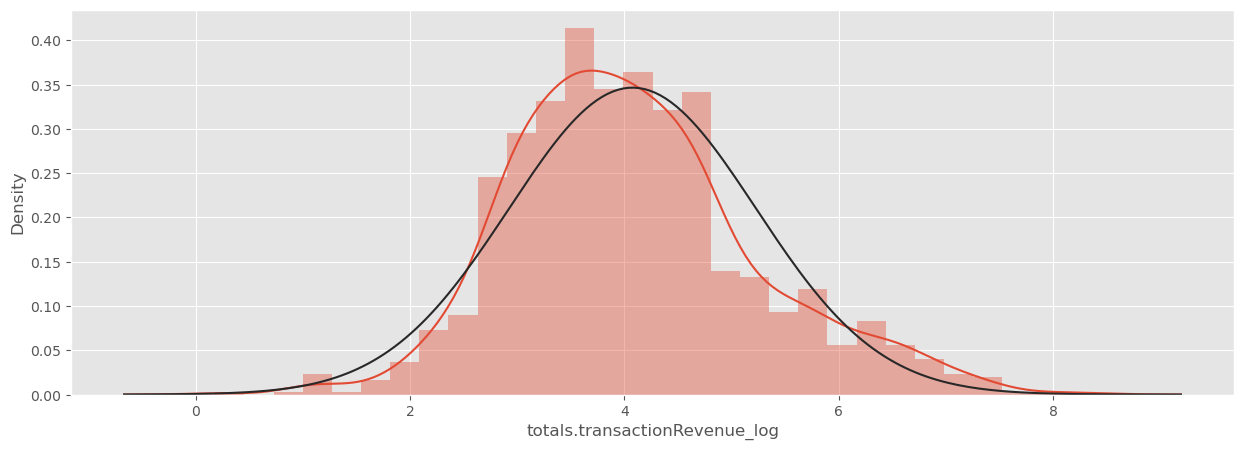

In [64]:
# Distribución de la variable target transformada al completo
plt.figure(figsize=(15, 5))
sns.distplot(
    df[df['visitWithTransaction'] == 1][target_log],
    fit = stats.norm # Pinto una N(mean=4.076020, std=1.151894)
);

1. He conseguido que que aquellas visitas que han hecho compra siga una distribución más o menos normal. Por lo tanto voy a poder ver la correlación lineal de esta variable con el resto de atributos, ya todos tienen una distribución lineal, y esto me permite utilizar algoritmos como la regresión lineal.
2. Además, aquellos posibles outliers que teníamos alejados, al hacer la transformación logarítmica, los acerca a la distribución, esto hace que el utilizar un algoritmo como la regresión lineal sea mucho más robusta.
3. Por lo tanto, siempre que usemos una regresión lineal, deberemos normalizar tanto el target como los atributos.
4. Este tipo de transformaciones no afecta a algoritmos como el decision tree, pero perdemos interpretabilidad, ya que en el árbol van a aparecer las variables logaritmicas, y por lo tanto, los cortes no van a tener una interpretación directa.

## **3.2. Distribución de atributos y correlación con el target**

## **Variables Categóricas**

### 3.2.1. Device - Device Browser

**Análisis univariante**

Es una variable categórica. Comprobamos que efectivamente me la describe como categórica (sino tenemos que cambiarla)

In [65]:
df['device.browser'].describe()

count      90306
unique        28
top       Chrome
freq       62147
Name: device.browser, dtype: object

- Es un object
- No hay nulos
- Tenemos 28 etiquetas distintas, siendo la más frecuente el Chrome con 62147 observaciones ( 2/3 del total)
- La mayoría de las observaciones están concentradas en una sóla etiqueta y tengo muchas observaciones con muy pocas etiquetas. Lo vemos:

In [66]:
df['device.browser'].value_counts()

Chrome                      62147
Safari                      17999
Firefox                      3774
Internet Explorer            1928
Edge                         1018
Android Webview               765
Safari (in-app)               668
Opera Mini                    601
Opera                         578
YaBrowser                     231
UC Browser                    217
Coc Coc                        83
Amazon Silk                    66
Android Browser                60
Mozilla Compatible Agent       36
MRCHROME                       30
Maxthon                        27
Nintendo Browser               24
BlackBerry                     21
Nokia Browser                  14
Puffin                          7
Iron                            5
LYF_LS_4002_12                  2
IE with Chrome Frame            1
Apple-iPhone7C2                 1
SeaMonkey                       1
NokiaE52-1                      1
(not set)                       1
Name: device.browser, dtype: int64

Vamos a agrupar todas aquellas etiquetas que son minoritarias, aplicando la **función SetOthers**. De momento nos vamos a quedar con las 5 primeras

In [67]:
top_browsers = df['device.browser'].value_counts().head()
top_browsers

Chrome               62147
Safari               17999
Firefox               3774
Internet Explorer     1928
Edge                  1018
Name: device.browser, dtype: int64

Meto las etiquetas en una lista

In [68]:
top_browsers_list = top_browsers.index.to_list()
top_browsers_list

['Chrome', 'Safari', 'Firefox', 'Internet Explorer', 'Edge']

La lista de todas las etiquetas serán estas 5 más la agrupación del resto ('Others')

In [69]:
# Añado a la lista el resto de etiquetas agrupadas que llamo 'Others'
top_browsers_list.append('Others')
top_browsers_list

['Chrome', 'Safari', 'Firefox', 'Internet Explorer', 'Edge', 'Others']

In [70]:
pd.Categorical??

Init signature:
pd.Categorical(
    values,
    categories=None,
    ordered=None,
    dtype: 'Dtype | None' = None,
    fastpath: 'bool' = False,
    copy: 'bool' = True,
)
Source:        
class Categorical(NDArrayBackedExtensionArray, PandasObject, ObjectStringArrayMixin):
    """
    Represent a categorical variable in classic R / S-plus fashion.

    `Categoricals` can only take on only a limited, and usually fixed, number
    of possible values (`categories`). In contrast to statistical categorical
    variables, a `Categorical` might have an order, but numerical operations
    (additions, divisions, ...) are not possible.

    All values of the `Categorical` are either in `categories` or `np.nan`.
    Assigning values outside of `categories` will raise a `ValueError`. Order
    is defined by the order of the `categories`, not lexical order of the
    values.

    Parameters
    ----------
    values : list-like
        The values of the categorical. If categories are given, value

Vamos a utilizar la variable Categorical (es igual que el object), indicando qué etiquetas queremos meterle.

In [71]:
df['device.browser'] = pd.Categorical(
    df['device.browser'], # le paso la serie de la variable que quiero convertir a categórica
    categories = top_browsers_list # le paso las únicas etiquetas que quiero que convierta (del total de la variable)
)
df['device.browser']

sessionId
1438082600262726746_1472803483               Safari
1283542838194038522_1472885255               Safari
4339756682310369249_1472828340               Chrome
062441254657008214_1472875520                Chrome
1381975521299261523_1472829727               Chrome
                                        ...        
8316382343226738015_1483549157               Chrome
6636384798982309878_1483525429               Chrome
469840327005431380_1483573235     Internet Explorer
2140149974339316233_1483557808               Chrome
5123779100307500332_1483554750               Chrome
Name: device.browser, Length: 90306, dtype: category
Categories (6, object): ['Chrome', 'Safari', 'Firefox', 'Internet Explorer', 'Edge', 'Others']

In [72]:
df['device.browser'].value_counts(dropna=False)

Chrome               62147
Safari               17999
Firefox               3774
NaN                   3440
Internet Explorer     1928
Edge                  1018
Others                   0
Name: device.browser, dtype: int64

Las observaciones de las etiquetas que no estaban en la lista, Python me los devuelve como nulos, que serían la suma de observaciones de las etiquetas minoritarias y que corresponden a la etiqueta Others que he creado. **Relleno esos nulos con 'Others'**.

In [73]:
# Relleno los nulos con 'Others'
df['device.browser'].fillna('Others', inplace=True)

In [74]:
df['device.browser'].describe()

count      90306
unique         6
top       Chrome
freq       62147
Name: device.browser, dtype: object

In [75]:
df['device.browser'].value_counts(dropna=False)

Chrome               62147
Safari               17999
Firefox               3774
Others                3440
Internet Explorer     1928
Edge                  1018
Name: device.browser, dtype: int64

In [76]:
df['device.browser'].value_counts(
    normalize = True, # Me devuelve el número de observaciones en porcentaje
    dropna = False)

Chrome               0.688182
Safari               0.199311
Firefox              0.041791
Others               0.038093
Internet Explorer    0.021350
Edge                 0.011273
Name: device.browser, dtype: float64

**Correlación con el target**

Hacemos una pivot_table y un countplot para ver qué tipo de relación hay entre ellos. No lo vamos a aplicar a todo el dataframe porque sino tendría en cuenta toda la gente que no ha comprado. Lo aplico sobre la gente que compra. Vamos a ver dos comportamientos:
- Por un lado, quiero hacer un conteo de la gente que compra según el buscador
- Por otro lado, quiero ver cómo se comporta la gente que compra según el buscador: puede haber buscadores que tenga muchos compradores pero que se gastan poco dinero y pueden haber buscadores que tengan pocos compradores pero que se gastan mucho dinero.


In [77]:
# Pivot_table de la gente que compra
df[df['visitWithTransaction'] == 1].pivot_table(
    index = 'device.browser', # Como índice ponemos la variable que queremos analizar
    values = target_log, # Como valores ponemos el target que queremos analizar
    aggfunc = [len, np.mean]) # Como funciones de agregación ponemos un conteo y la media

,len,mean
,totals.transactionRevenue_log,totals.transactionRevenue_log
device.browser,,
Chrome,1009,4.141194
Safari,65,3.346190
Firefox,15,3.747523
Internet Explorer,12,3.338823
Edge,5,4.016332
Others,4,3.013546


La mayoría de compras hacen a través de Chrome. Por lo tanto, mi modelo va a saber que si no viene de Chrome raramente va a gastar más de cero. Lo más normal es que prediga que esa persona no compra en nuestra web.

In [78]:
# Transacciones por etiqueta y valor medio de la transacción por etiqueta
_results_df = df[df['visitWithTransaction'] == 1].pivot_table(index = 'device.browser', values = target_log, aggfunc = [len, np.mean])

In [79]:
# Renombro las columnas
_results_df.columns = ['transactions', 'mean_revenue_log']
_results_df


,transactions,mean_revenue_log
device.browser,,
Chrome,1009,4.141194
Safari,65,3.346190
Firefox,15,3.747523
Internet Explorer,12,3.338823
Edge,5,4.016332
Others,4,3.013546


In [80]:
# Número de filas en conteo
_results_df['n_rows'] = df['device.browser'].value_counts(dropna = False)
_results_df

,transactions,mean_revenue_log,n_rows
device.browser,,,
Chrome,1009,4.141194,62147
Safari,65,3.346190,17999
Firefox,15,3.747523,3774
Internet Explorer,12,3.338823,1928
Edge,5,4.016332,1018
Others,4,3.013546,3440


In [81]:
# Número de filas en porcentaje
_results_df['pct_rows'] = df['device.browser'].value_counts(normalize = True, dropna = False)
_results_df

,transactions,mean_revenue_log,n_rows,pct_rows
device.browser,,,,
Chrome,1009,4.141194,62147,0.688182
Safari,65,3.346190,17999,0.199311
Firefox,15,3.747523,3774,0.041791
Internet Explorer,12,3.338823,1928,0.021350
Edge,5,4.016332,1018,0.011273
Others,4,3.013546,3440,0.038093


In [82]:
# Ratio de compradores
_results_df['pct_transactions'] = _results_df['transactions'] / _results_df['n_rows']
_results_df

,transactions,mean_revenue_log,n_rows,pct_rows,pct_transactions
device.browser,,,,,
Chrome,1009,4.141194,62147,0.688182,0.016236
Safari,65,3.346190,17999,0.199311,0.003611
Firefox,15,3.747523,3774,0.041791,0.003975
Internet Explorer,12,3.338823,1928,0.021350,0.006224
Edge,5,4.016332,1018,0.011273,0.004912
Others,4,3.013546,3440,0.038093,0.001163


In [83]:
# Reordeno las columnas para darle más sentido a la tabla descriptiva
_results_df = _results_df[['n_rows', 'pct_rows', 'transactions', 'pct_transactions', 'mean_revenue_log']]
_results_df

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
device.browser,,,,,
Chrome,62147,0.688182,1009,0.016236,4.141194
Safari,17999,0.199311,65,0.003611,3.346190
Firefox,3774,0.041791,15,0.003975,3.747523
Internet Explorer,1928,0.021350,12,0.006224,3.338823
Edge,1018,0.011273,5,0.004912,4.016332
Others,3440,0.038093,4,0.001163,3.013546


También podemos visualizar la correlación haciendo uso de un countplot

In [84]:
df['device.browser'].value_counts()

Chrome               62147
Safari               17999
Firefox               3774
Others                3440
Internet Explorer     1928
Edge                  1018
Name: device.browser, dtype: int64

In [85]:
df['device.browser'].info()

<class 'pandas.core.series.Series'>
Index: 90306 entries, 1438082600262726746_1472803483 to 5123779100307500332_1483554750
Series name: device.browser
Non-Null Count  Dtype   
--------------  -----   
90306 non-null  category
dtypes: category(1)
memory usage: 2.8+ MB


In [86]:
sns.countplot??

Signature:
sns.countplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    order=None,
    hue_order=None,
    orient=None,
    color=None,
    palette=None,
    saturation=0.75,
    width=0.8,
    dodge=True,
    ax=None,
    **kwargs,
)
Docstring:
Show the counts of observations in each categorical bin using bars.

A count plot can be thought of as a histogram across a categorical, instead
of quantitative, variable. The basic API and options are identical to those
for :func:`barplot`, so you can compare counts across nested variables.

Note that the newer :func:`histplot` function offers more functionality, although
its default behavior is somewhat different.

.. note::
    This function always treats one of the variables as categorical and
    draws data at ordinal positions (0, 1, ... n) on the relevant axis,
    even when the data has a numeric or date type.

See the :ref:`tutorial <categorical_tutorial>` for more information.    

Parameters
----------
data : DataF

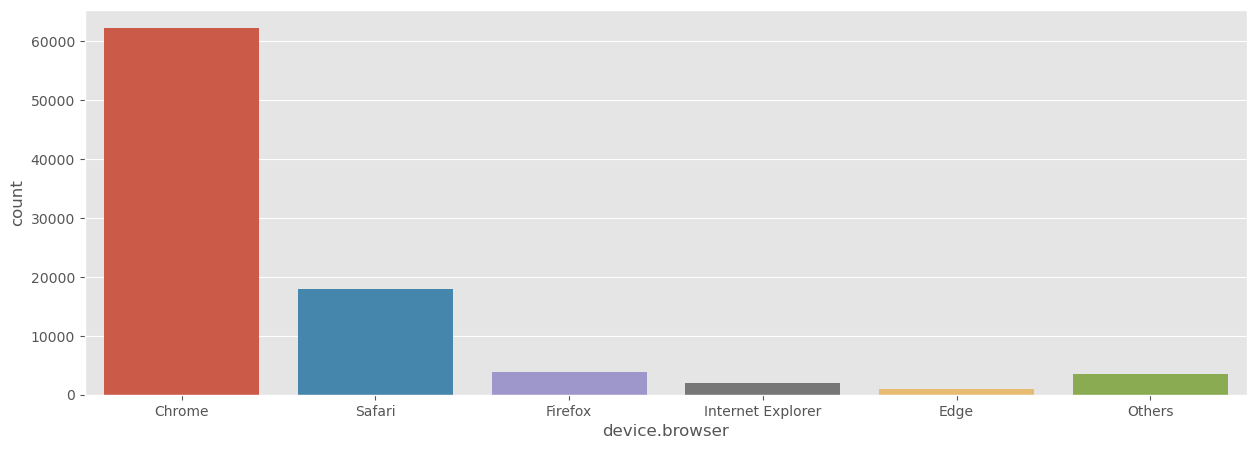

In [87]:
# Número de filas por etiqueta
plt.figure(figsize = (15,5))
sns.countplot(
    data = df,  
    x = 'device.browser' # Le damos la variable que queremos analizar
);

In [88]:
sns.boxenplot??

Signature:
sns.boxenplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    order=None,
    hue_order=None,
    orient=None,
    color=None,
    palette=None,
    saturation=0.75,
    width=0.8,
    dodge=True,
    k_depth='tukey',
    linewidth=None,
    scale='exponential',
    outlier_prop=0.007,
    trust_alpha=0.05,
    showfliers=True,
    ax=None,
    box_kws=None,
    flier_kws=None,
    line_kws=None,
)
Docstring:
Draw an enhanced box plot for larger datasets.

This style of plot was originally named a "letter value" plot because it
shows a large number of quantiles that are defined as "letter values".  It
is similar to a box plot in plotting a nonparametric representation of a
distribution in which all features correspond to actual observations. By
plotting more quantiles, it provides more information about the shape of
the distribution, particularly in the tails. For a more extensive
explanation, you can read the paper that introduced the plot:
https://vita.had

Habíamos visto como se comporta el target en conjunto. Ahora quiero ver como se comporta con respecto a cada etiqueta de la variable. Para ello utilizamos un boxenplot y vemos la distribución del target. Y eso lo hacemos sólo sobre las sesiones en las que hay compra porque quiero ver en qué etiquetas se gasta más y en cuales se gasta menos.

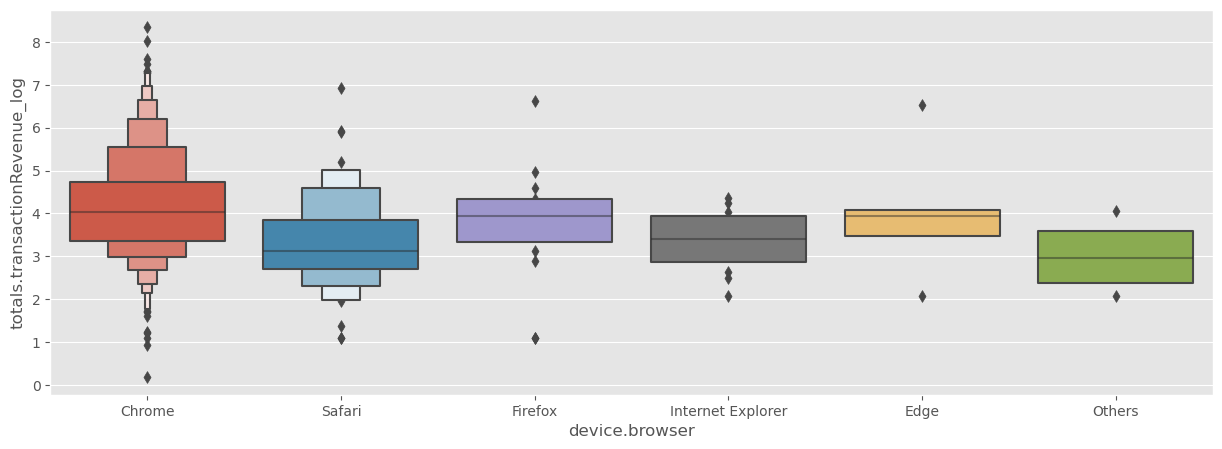

In [89]:
# Transacción media por etiqueta de aquellos que compran
plt.figure(figsize=(15,5))
sns.boxenplot(
    data = df[df['visitWithTransaction'] == 1], # le paso los datos de aquellas sesiones en las que se realizan compras
    x = 'device.browser', # le paso la variable categórica que quiero analizar
    y = target_log # Le paso el target
);

En el boxenplot tenemos el percentil 25, el 50 y el 75 al igual que en un boxplot. Pero aquí nos da una distribución más exacta. Cada caja por encima del percentil 75 tiene un ancho de la mitad de la caja inferior. Y cada caja por debajo del percentil 25 tiene un ancho de la mitad de la caja superior.
- Podemos ver que hay observacioes que se encuentran fuera de la distribución. Puede suceder dos cosas: o bien se trata de una observación real o bien se trata de una obserbación random (outlier). Si se dispone de tiempo se puede hacer un modelo con todas las observaciones y otro con las observaciones menos estos posibles outliers. Validar ambos modelos y ver cómo se comportan y a partir de ahí tomar decisiones.

*Definimos funciones con todos los pasos que hemos dado para automatizarlos con el resto de variables*

In [90]:
def plot_cat_values(dataframe, column, target_column):
    '''
    Grafica la relación entre las variable categóricas (column) y el target (target_column),
    pasándole un dataframe, mediante 2 gráficos.
    '''

    plt.figure(figsize=(15,8))

    # Divido el gráfico en 2 filas y 1 columna
    # El primer gráfico lo pinto en el primer hueco
    ax1 = plt.subplot(2,1,1)
    ## Graficamos el conteo de cada uno de los valores
    ax1 = sns.countplot(
        data = dataframe, 
        x = column, # Le damos la variable que queremos analizar
        order = list(dataframe[column].unique()) # Le imponemos el orden en que quiero que grafique las etiquetas
    )

    # El segundo gráfico lo pinto en el segundo hueco
    ax2 = plt.subplot(2,1,2) 
    ## Graficamos la distribución del target sólo para aquellos casos con target > 0 (para que no se chafe el BP) 
    ax2 = sns.boxenplot(
        data = dataframe[dataframe[target_column] > 0], # En vez de poner visitWithTransaction, para generalizarlo pongo target_column > 0
        x = column,
        y = target_column,
        order = list(dataframe[column].unique()) # Le imponemos el mismo orden que en el gráfico 1
    )
    plt.show() # No hay un return ya que no me tiene que devolver algo que guarda. Directamente le digo que muestre el gráfico


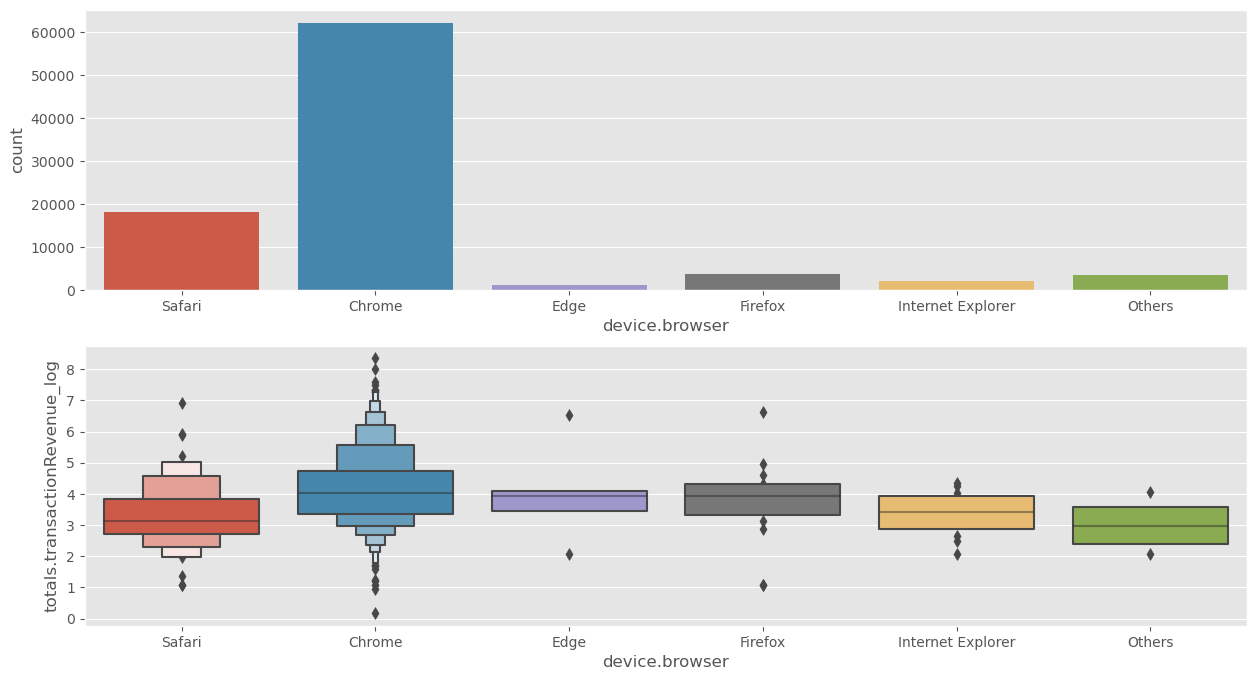

In [91]:
# Comprobamos que funciona bien
plot_cat_values(dataframe = df, column = 'device.browser', target_column = target_log);

In [92]:
def explore_cat_values(dataframe, column, target_column):
    '''
    Tabla descriptiva del analisis de las variables categóricas (column) frente al target (target_column),
    pasándole el dataframe.
    '''
    
    # Pivot_table 
    _results_df = dataframe[dataframe[target_column] > 0].pivot_table(
        index = column, # etiquetas de la variable que quiero analizar
        values = target_column, # Target
        aggfunc = [len, np.mean] # Funciones de agregación de conteo y media del valor de compra para cada etiqueta
    )
    
    # Renombro las columnas del pivot_table
    _results_df.columns = ['transactions', 'mean_revenue_log']

    # Número de filas por etiqueta de la variable que quiero analizar
    _results_df['n_rows'] = dataframe[column].value_counts(dropna = False)

    # Porcentaje del número de filas por etiqueta de la variable que quiero analizar
    _results_df['pct_rows'] = dataframe[column].value_counts(normalize = True, dropna = False)

    # Porcentaje de filas con transacciones por etiqueta de la variable que quiero analizar 
    _results_df['pct_transactions'] = _results_df['transactions'] / _results_df['n_rows']

    # Reordeno las columnas de la tabla
    _results_df = _results_df[['n_rows', 'pct_rows', 'transactions', 'pct_transactions', 'mean_revenue_log']]
    
    return _results_df

In [93]:
# Compruebo que funciona bien
explore_cat_values(dataframe = df, column = 'device.browser', target_column = target_log)

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
device.browser,,,,,
Chrome,62147,0.688182,1009,0.016236,4.141194
Safari,17999,0.199311,65,0.003611,3.346190
Firefox,3774,0.041791,15,0.003975,3.747523
Internet Explorer,1928,0.021350,12,0.006224,3.338823
Edge,1018,0.011273,5,0.004912,4.016332
Others,3440,0.038093,4,0.001163,3.013546


In [94]:
def setOthers(dataframe, column, num_values):
    ''' 
    Reduce el número de etiquetas.
    Agrupa las etiquetas de la variable categórica (column) que quedan fuera de las num_values primeras,
    en una única llamada 'Others', pasándole el dataframe.
    '''
    
    # Me quedo con la lista de las primeras etiquetas (num_values)
    top_categories = dataframe[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()

    # Añado a la lista la etiqueta 'Others'
    top_categories_list.append('Others')

    # Convierto a categórica sólo las etiquetas que le indico, de la variable (column)
    # Las otras etiquetas que no están en la lista, se convierten en nulos
    dataframe[column] = pd.Categorical(
        dataframe[column], 
        categories = top_categories_list
    )

    # Relleno los nulos con 'Others' y me devuelve las etiquetas de la variable (column)
    return dataframe[column].fillna('Others') # No es recomendable meter el inplace = True en el fillna. Es mejor guardar el resultado en una variable

Device.browser es una variable categórica, que hemos reducido de etiquetas y aplicaremos un OHE.

### 3.2.2. Sistema Operativo

Como no se el número de etiquetas que tengo en total, empiezo haciendo un value_counts

In [95]:
df['device.operatingSystem'].value_counts()

Windows          35174
Macintosh        25276
Android          12284
iOS              10732
Linux             3543
Chrome OS         2641
(not set)          444
Windows Phone      118
Samsung             28
BlackBerry          25
Nintendo Wii        16
Firefox OS          10
Nintendo WiiU        7
Xbox                 5
Nintendo 3DS         1
Nokia                1
FreeBSD              1
Name: device.operatingSystem, dtype: int64

- Vamos a dejar las 6 primeras etiquetas y agrupar las restantes en otra etiqueta llamada 'Others'.
- **Ojo a la hora de agrupar**. Si hacemos el corte por Firefox OS que tiene 10 y le metemos al decisiontree un min_sample_split de 500, las etiquetas que aparecen por debajo de 500 (not set, Windows Phone, Samsung, BlackBerry, Nintendo Wi) el decisiontree no las tendrá en cuenta cuando haga los subgrupos. Tendré que agrupar las etiquetas que tienen un value_counts por debajo de 500 (el decisiontree no va a hacer ningún corte con un subset con menos de 500 observaciones y por lo tanto no utilizará esas variables).

**Data Preparation** --> *Reducción de etiquetas*

In [96]:
df['device.operatingSystem'] = setOthers(dataframe = df, column = 'device.operatingSystem', num_values = 6)
df['device.operatingSystem'].value_counts()

Windows      35174
Macintosh    25276
Android      12284
iOS          10732
Linux         3543
Chrome OS     2641
Others         656
Name: device.operatingSystem, dtype: int64

**Data Understanding**  --> *Análisis de la variable frente al target*

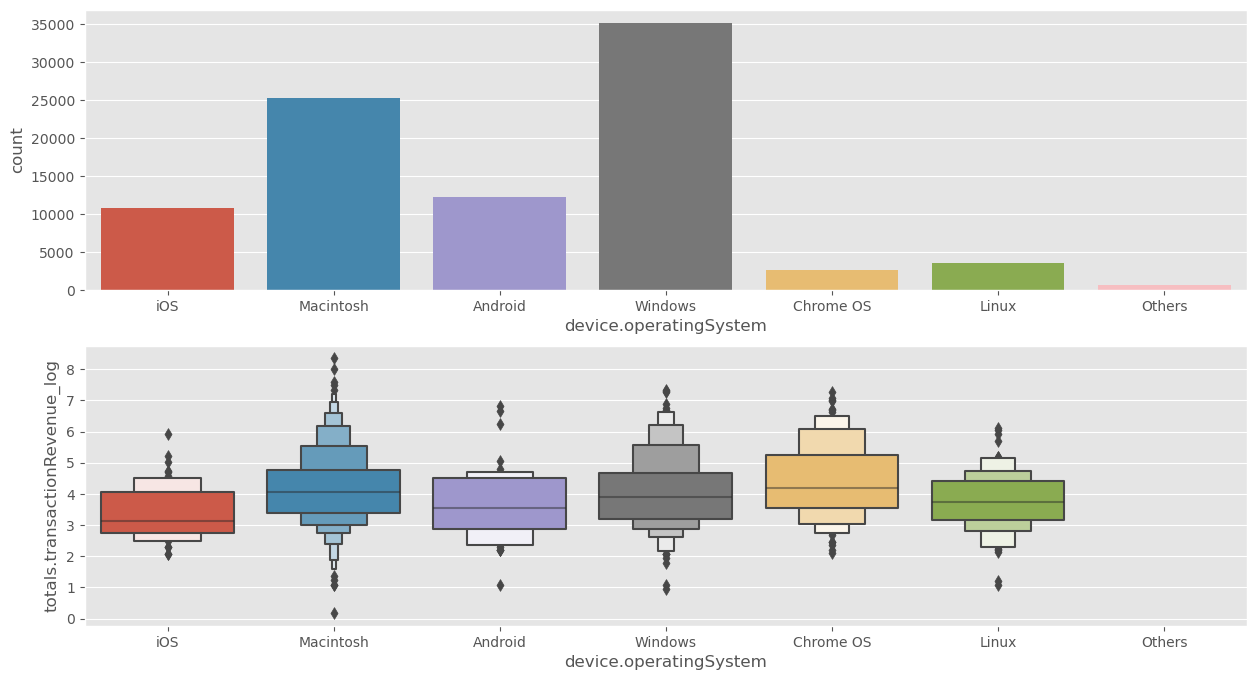

In [97]:
plot_cat_values(dataframe = df, column = 'device.operatingSystem', target_column = target_log)

In [98]:
explore_cat_values(dataframe = df, column = 'device.operatingSystem', target_column = target_log)

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
device.operatingSystem,,,,,
Windows,35174,0.389498,204,0.005800,4.033411
Macintosh,25276,0.279893,627,0.024806,4.154472
Android,12284,0.136026,43,0.003500,3.693958
iOS,10732,0.118840,47,0.004379,3.409389
Linux,3543,0.039233,85,0.023991,3.771755
Chrome OS,2641,0.029245,104,0.039379,4.394535
Others,656,0.007264,0,0.000000,NaN


- Los que mejor ratio de compra tienen son los de Mac (Apple) y los de Chrome OS (Google). Son los que más gastan.
- **Ojo**. Si tengo una etiqueta con muy pocas transacciones, no me puedo fiar de su mean_revenue_log
- Podemos aplicar un OHE o un Frecuency Encoder
- **Ojo**. Si aplicamos un Frecuency Encoder, debemos asegurarnos que las etiquetas más frecuentes de una variable se comporten más o menos igual con respecto al target, lo mismo que las menos frecuentes. En este caso en concreto, no sería buena idea aplicarlo porque vemos que Windows y Macintosh que son los dos más frecuentes, tienen un porcentaje de transacciones muy diferente.

Device.operatingsystem es una variable categórica, que hemos reducido de etiquetas y aplicaremos un OHE.

### 3.2.3. Device - Is Mobile

- Nos indica si entra por un móbil o no. Debería relacionarse mucho con los sistemas operativos.
- Está relacionado con el tamaño de la pantalla (viewport). Igual hay una pantalla grande que está con un Android detras, por lo que no sería exactamente igual que los sistemas operativos pero debería parecerse (deberían correlacionarse bastante estas dos variables).
- En un decision tree no afecta el tener variables correlacionadas
- En el sistema operativo si utilizamos el decisiontree y no tuviesemos la variable ismobile, podríamos crearla a partir de la variable sistema operativo, juntando las etiquetas Android y iOS con una sóla etiqueta, en cambio si utilizamos un Gradient Boosting es mejor dejarlo separado y dejar las dos variable 'Sistema operativo' y 'ismobile' porque va a ir mucho más al detalle (va a hacer muchas más preguntas). En general, si utilizamos algoritmos que tienen un decisiontree por detrás, cuántas más variables y datos le demos, mejor.

In [99]:
explore_cat_values(dataframe = df, column = 'device.isMobile', target_column = target_log)

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
device.isMobile,,,,,
False,66571,0.737171,1017,0.015277,4.124387
True,23735,0.262829,93,0.003918,3.547096


Se observa que en Desktop se hace compra en un mayor porcentaje de ocasiones y el importe es más alto

In [100]:
# Vemos qué tipo de variable es
df['device.isMobile'].dtype

dtype('bool')

Podemos dejar la variable como booleana, ya que en principio mo debería darnos problemas. Si cuando entrenemos el algoritmo peta es porque el algoritmo que estamos utilizando no permite usar booleanos y deberemos cambiarla a integer.

In [101]:
# La convertimos a integer
df['device.isMobile'] = df['device.isMobile'].astype(int)

In [102]:
df['device.isMobile'].dtype

dtype('int32')

### 3.2.4. Device - Category

In [103]:
explore_cat_values(dataframe = df, column = 'device.deviceCategory', target_column = target_log)

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
device.deviceCategory,,,,,
desktop,66572,0.737182,1017,0.015277,4.124387
mobile,20733,0.229586,69,0.003328,3.542712
tablet,3001,0.033231,24,0.007997,3.559700


Vemos la relación que hay entre dos categóricas ('ismobile' y 'devicecategory') y para ello hacemos lo mismo que se hace para determinar la Confusion Matrix, utilizar el crosstab. La idea es ver si estas dos variables me están diciendo información parecida o no y también quiero saber si la etiqueta "tablet" estaba antes, dentro de moviles o no moviles.

In [104]:
# Relación entre dos categóricas
pd.crosstab(
    df['device.isMobile'], 
    df['device.deviceCategory']
)

device.deviceCategory,desktop,mobile,tablet
device.isMobile,,,
0,66558,12,1
1,14,20721,3000


- Ambas variables están muy correlacionadas
- La tablet esta metida dento de ismobile.

Tenemos tres opciones:
1. Dejar isMobile
2. Dejar deviceCategory
3. Dejar las dos variables

Si usamos un decisiontree dejaría las dos, porque es un algoritmo robusto a variables correlacionadas. Si usamos una regresión lineal, no es tan robusto con variables correlacionadas (predice bien pero no explica bien la importancia de cada una), por lo que me quedaría con una de ellas.

Se trata de ir probando las tres opciones y ver con cuál se comporta mejor el algoritmo.

### 3.2.5. ChannelGrouping

In [105]:
explore_cat_values(dataframe = df, column = 'channelGrouping', target_column = target_log)

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
channelGrouping,,,,,
Affiliates,1648,0.018249,1,0.000607,2.193886
Direct,14061,0.155704,214,0.015219,4.398677
Display,570,0.006312,10,0.017544,4.226333
Organic Search,38445,0.425719,326,0.008480,3.800753
Paid Search,2507,0.027761,39,0.015556,3.852479
Referral,10501,0.116282,511,0.048662,4.137267
Social,22563,0.249851,9,0.000399,3.907991


Muestra el canal por el cual entra el usuario:
- Social --> Facebook, LinkedIn, Instagram
- Paid Search --> búsquedas de google, yahoo, etc, con Google Ads (los ads que hay en los buscadores arriba del todo --> has pagado para salir ahí)
- Organic Search --> búsquedas de google sin haber pagado (tu posicionamiento de Seo es mejor y apareces al principio de las búsquedas)
- Referral --> páginas web que tienen un enlace que te refieren a tu web directamente
- Direct --> metes directamente la Url en el buscador
- Display --> ads que son de display (tipo youtube)
- Affiliates --> tráfico que tienes de otro sitio y te lo dirigen hacia tu web (también es de pago)

Las etiquetas más interesantes es la de referral que tiene la tasa de conversión de compra más alta con diferencia. Affiliates, Display y Social no son representativas ya que tienen un número de transacciones muy pequeño en este sample (quizás habría que utilizar todo el datset para saber qué comportamiento tienen).

Por otro lado, vemos que Affiliates sólo tiene una transacción. Si utilizamos un decision tree, va a decirdir que todos los que ingresen por este canal no van a hacer compra. Recordemos que los decisiontree discriminan tanto los que tienen muchos 1 como los que tienen muchos 0.

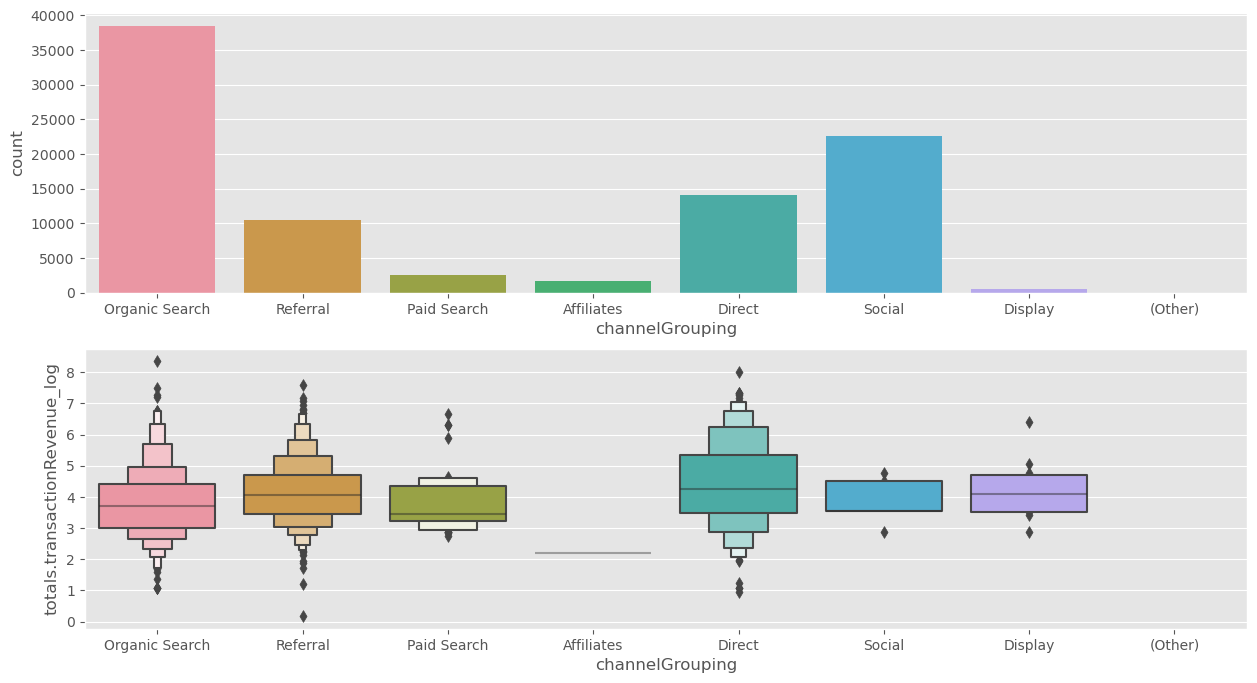

In [106]:
plot_cat_values(dataframe = df, column = 'channelGrouping', target_column = target_log)

Es una variable categórica. Haremos un OHE.

## **Fechas**

### 3.2.6. Date

In [107]:
df['date'].describe()

count    9.030600e+04
mean     2.016589e+07
std      4.697568e+03
min      2.016080e+07
25%      2.016103e+07
50%      2.017011e+07
75%      2.017042e+07
max      2.017080e+07
Name: date, dtype: float64

In [108]:
df['date'].head()

sessionId
1438082600262726746_1472803483    20160902
1283542838194038522_1472885255    20160902
4339756682310369249_1472828340    20160902
062441254657008214_1472875520     20160902
1381975521299261523_1472829727    20160902
Name: date, dtype: int64

Está en formato numérico --> ano_mes_día

Para trabajar en SQL es más facil con este formato

Tenemos que cambiarla a un formato datetime para que Python entienda lo que es año, mes y día

In [109]:
pd.to_datetime(
    df['date']
)

sessionId
1438082600262726746_1472803483   1970-01-01 00:00:00.020160902
1283542838194038522_1472885255   1970-01-01 00:00:00.020160902
4339756682310369249_1472828340   1970-01-01 00:00:00.020160902
062441254657008214_1472875520    1970-01-01 00:00:00.020160902
1381975521299261523_1472829727   1970-01-01 00:00:00.020160902
                                              ...             
8316382343226738015_1483549157   1970-01-01 00:00:00.020170104
6636384798982309878_1483525429   1970-01-01 00:00:00.020170104
469840327005431380_1483573235    1970-01-01 00:00:00.020170104
2140149974339316233_1483557808   1970-01-01 00:00:00.020170104
5123779100307500332_1483554750   1970-01-01 00:00:00.020170104
Name: date, Length: 90306, dtype: datetime64[ns]

Tenemos que pasarle un formato al datetime indicando cómo está expresado el date, sino lo convierte sin sentido ya que es un número que no está separado por guiones año-mes-dia (por defecto python es el formato que lee). Siempre que no venga en este formato tendremos que especificar a python con el format

In [110]:
# La pasamos a datetime
df['date'] = pd.to_datetime(
    df['date'], # variable que quiero cambiar
    format='%Y%m%d' # formato que le tengo que decir (le digo que las 4 primeras posiciones son año, las dos siguientes son el mes y las dos)
)
df['date'].head()

sessionId
1438082600262726746_1472803483   2016-09-02
1283542838194038522_1472885255   2016-09-02
4339756682310369249_1472828340   2016-09-02
062441254657008214_1472875520    2016-09-02
1381975521299261523_1472829727   2016-09-02
Name: date, dtype: datetime64[ns]

In [111]:
# Sacamos toda la información al date
# En un ecommerce la variable date es muy importante (no es lo mismo comprar en invierno que en verano)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['monthDay'] = df['date'].dt.day
df['weekDay'] = df['date'].dt.weekday
df['quarter'] = df['date'].dt.quarter
df['week'] = df['date'].dt.week

In [112]:
df.head(5).T

sessionId,1438082600262726746_1472803483,1283542838194038522_1472885255,4339756682310369249_1472828340,062441254657008214_1472875520,1381975521299261523_1472829727
Unnamed: 0,13,27,28,37,43
channelGrouping,Organic Search,Organic Search,Referral,Organic Search,Organic Search
date,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00
visitNumber,1,1,1,1,1
visitStartTime,1472803483,1472885255,1472828340,1472875520,1472829727
device.browser,Safari,Safari,Chrome,Chrome,Chrome
device.operatingSystem,iOS,Macintosh,Android,Windows,Macintosh
device.isMobile,1,0,1,0,0
device.deviceCategory,mobile,desktop,mobile,desktop,desktop
geoNetwork.continent,Asia,Europe,Asia,Oceania,Asia


In [113]:
# Extraida toda la información, eliminamos la variable
df.drop('date', axis=1, inplace=True)

### 3.2.7. Visit Start Time

Es un timestamp es un valor que cuenta los segundos desde un tiempo concreto. Por lo tanto va a ser una variable numérica, lo vemos

In [114]:
df['visitStartTime'].describe()

count    9.030600e+04
mean     1.485020e+09
std      9.027413e+06
min      1.470035e+09
25%      1.477570e+09
50%      1.483985e+09
75%      1.492787e+09
max      1.501656e+09
Name: visitStartTime, dtype: float64

In [115]:
df['visitStartTime'].head()

sessionId
1438082600262726746_1472803483    1472803483
1283542838194038522_1472885255    1472885255
4339756682310369249_1472828340    1472828340
062441254657008214_1472875520     1472875520
1381975521299261523_1472829727    1472829727
Name: visitStartTime, dtype: int64

Vemos que la mayoría son muy parecidos. Tenemos que convertir estos valores. Para eso utilizamos un timestamp converter para convertirla a una fecha real, por ejemplo: https://www.epochconverter.com/

Por ejemplo para un timestamp de 1472803483, la fecha será el 
2 de septiembre de 2016 10:04:43 GMT+02:00 DST

Para el algoritmo la hora seguro que es relevante, pero el minuto igual no. Saco simplemente la hora

In [116]:
# Me devuelve el año, mes, día, hora, minuto y segundo
datetime.fromtimestamp(1472803483)

datetime.datetime(2016, 9, 2, 10, 4, 43)

In [117]:
# Me devuelve la hora
datetime.fromtimestamp(1472803483).hour

10

Creamos una variable que me saque las horas para todas las filas. Para ello aplicamos el apply (hace como un for loop a cada una de las filas, aplicando la función que yo defina)

In [118]:
# Extraigo la hora del timestamp
df['visitHour'] = df['visitStartTime'].apply(lambda x: datetime.fromtimestamp(x).hour)
df['visitHour']

sessionId
1438082600262726746_1472803483    10
1283542838194038522_1472885255     8
4339756682310369249_1472828340    16
062441254657008214_1472875520      6
1381975521299261523_1472829727    17
                                  ..
8316382343226738015_1483549157    17
6636384798982309878_1483525429    11
469840327005431380_1483573235      0
2140149974339316233_1483557808    20
5123779100307500332_1483554750    19
Name: visitHour, Length: 90306, dtype: int64

In [119]:
# Extraida la información, ya puedo eliminar la variable porque ya tenemos el año, mes, dia que sacamos del date
df.drop('visitStartTime', axis=1, inplace=True)

In [120]:
df.head().T

sessionId,1438082600262726746_1472803483,1283542838194038522_1472885255,4339756682310369249_1472828340,062441254657008214_1472875520,1381975521299261523_1472829727
Unnamed: 0,13,27,28,37,43
channelGrouping,Organic Search,Organic Search,Referral,Organic Search,Organic Search
visitNumber,1,1,1,1,1
device.browser,Safari,Safari,Chrome,Chrome,Chrome
device.operatingSystem,iOS,Macintosh,Android,Windows,Macintosh
device.isMobile,1,0,1,0,0
device.deviceCategory,mobile,desktop,mobile,desktop,desktop
geoNetwork.continent,Asia,Europe,Asia,Oceania,Asia
geoNetwork.subContinent,Southern Asia,Eastern Europe,Southern Asia,Australasia,Eastern Asia
geoNetwork.country,Pakistan,Hungary,India,Australia,South Korea


## **Variables numéricas**

### 3.2.8. Visit Number

In [121]:
df['visitNumber'].head()

sessionId
1438082600262726746_1472803483    1
1283542838194038522_1472885255    1
4339756682310369249_1472828340    1
062441254657008214_1472875520     1
1381975521299261523_1472829727    1
Name: visitNumber, dtype: int64

In [122]:
df['visitNumber'].describe()

count    90306.000000
mean         2.254269
std          9.102378
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        373.000000
Name: visitNumber, dtype: float64

- La mayoría es la primera visita
- Hay un máximo que tiene toda la pinta de ser un bot o alguien haciendo testeos de la página web

**Relación con el target**

Recordemos que si estamos en una regresión lineal, la relación tiene que ser lineal, sino el algoritmo no funcionaría bien

Para ello haremos una visualización utilizando un **regplot** (es un scatterplot más una regresión lineal por encima)

In [123]:
sns.regplot??

Signature:
sns.regplot(
    data=None,
    *,
    x=None,
    y=None,
    x_estimator=None,
    x_bins=None,
    x_ci='ci',
    scatter=True,
    fit_reg=True,
    ci=95,
    n_boot=1000,
    units=None,
    seed=None,
    order=1,
    logistic=False,
    lowess=False,
    robust=False,
    logx=False,
    x_partial=None,
    y_partial=None,
    truncate=True,
    dropna=True,
    x_jitter=None,
    y_jitter=None,
    label=None,
    color=None,
    marker='o',
    scatter_kws=None,
    line_kws=None,
    ax=None,
)
Docstring:
Plot data and a linear regression model fit.

There are a number of mutually exclusive options for estimating the
regression model. See the :ref:`tutorial <regression_tutorial>` for more
information.    

Parameters
----------
x, y: string, series, or vector array
    Input variables. If strings, these should correspond with column names
    in ``data``. When pandas objects are used, axes will be labeled with
    the series name.
data : DataFrame
    Tidy ("long-

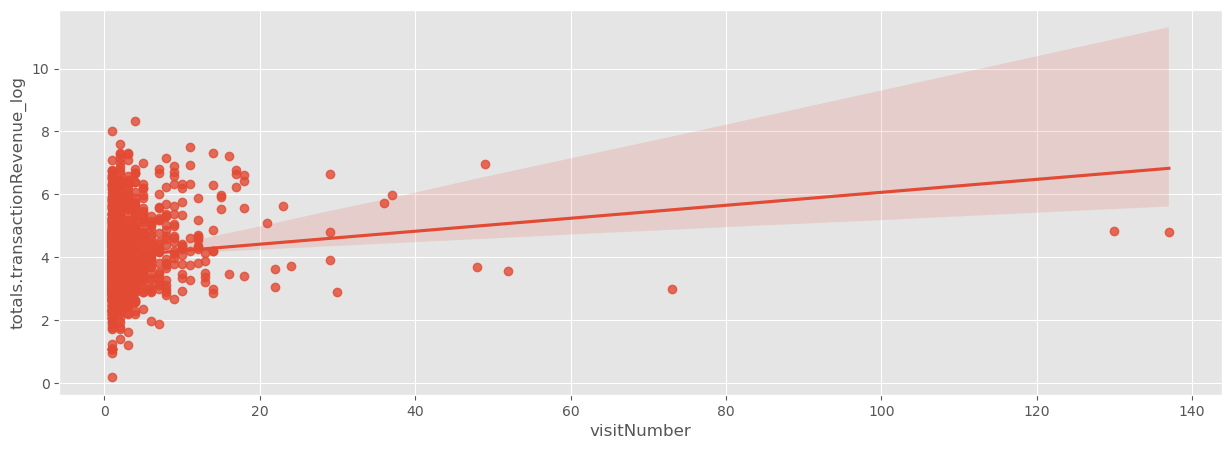

In [124]:
plt.figure(figsize=(15,5))
sns.regplot(
    data = df[df['visitWithTransaction'] == 1], # Le pasamos sólo los datos de los que hacen compra (para no tener un montón de 0 que no me interesan tanto)
    x = 'visitNumber', # Le pasamos la variable que queremos analizar
    y = target_log # Le pasamos el target
);

No tiene pinta de que haya una correlación entre ambas variables. Lo vemos haciendo la **correlación de Pearson** (es la que hace por defecto)

In [125]:
df[['visitNumber', target_log]].head()

,visitNumber,totals.transactionRevenue_log
sessionId,,
1438082600262726746_1472803483,1,0.0
1283542838194038522_1472885255,1,0.0
4339756682310369249_1472828340,1,0.0
062441254657008214_1472875520,1,0.0
1381975521299261523_1472829727,1,0.0


In [126]:
# Correlación de Pearson
df[['visitNumber', target_log]].corr()

,visitNumber,totals.transactionRevenue_log
visitNumber,1.000000,0.020139
totals.transactionRevenue_log,0.020139,1.000000


Efectivamente, la correlación lineal entre ambas es practicamente nula.

*Si transformamos las dos variables a una distribución normal es mucho más probable que consiga capturar relaciones lineales, si es que las hay.*

In [127]:
# Transformamos a una distribución normal
df['visitNumber_log'] = df['visitNumber'].apply(lambda x: np.log1p(x)) # aplico a la variable el log de base 10 de (1+x)
df['visitNumber_log']

sessionId
1438082600262726746_1472803483    0.693147
1283542838194038522_1472885255    0.693147
4339756682310369249_1472828340    0.693147
062441254657008214_1472875520     0.693147
1381975521299261523_1472829727    0.693147
                                    ...   
8316382343226738015_1483549157    0.693147
6636384798982309878_1483525429    0.693147
469840327005431380_1483573235     0.693147
2140149974339316233_1483557808    0.693147
5123779100307500332_1483554750    0.693147
Name: visitNumber_log, Length: 90306, dtype: float64

In [128]:
# Otra forma de hacerlo
np.log1p(df['visitNumber'])

sessionId
1438082600262726746_1472803483    0.693147
1283542838194038522_1472885255    0.693147
4339756682310369249_1472828340    0.693147
062441254657008214_1472875520     0.693147
1381975521299261523_1472829727    0.693147
                                    ...   
8316382343226738015_1483549157    0.693147
6636384798982309878_1483525429    0.693147
469840327005431380_1483573235     0.693147
2140149974339316233_1483557808    0.693147
5123779100307500332_1483554750    0.693147
Name: visitNumber, Length: 90306, dtype: float64

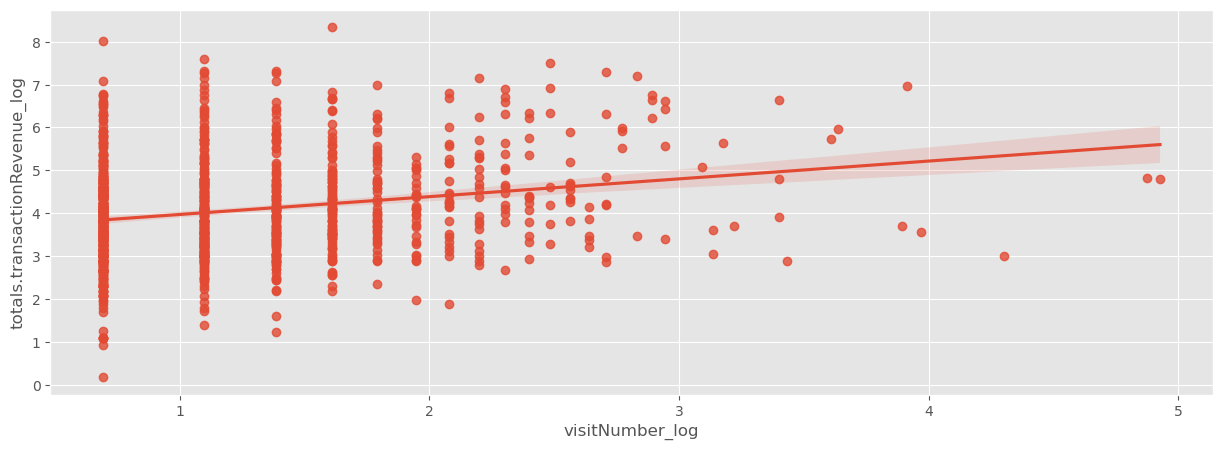

In [129]:
# Graficamos las dos variables normalizadas
plt.figure(figsize=(15,5))
sns.regplot(
    data = df[df['visitWithTransaction'] == 1], # Le pasamos sólo los datos de los que hacen compra (para no tener un montón de 0 que no me interesan tanto)
    x = 'visitNumber_log', # Le pasamos la variable que queremos analizar
    y = target_log # Le pasamos el target
);

Las observaciones de la parte baja del visitNumber que antes estaban muy concentrados, los separa y los de la parte alta que antes estaban muy dispersos, los junta. De esta forma, la distribución queda un poco más homogenea.

In [130]:
df[['visitNumber_log', target_log]].corr()

,visitNumber_log,totals.transactionRevenue_log
visitNumber_log,1.000000,0.089364
totals.transactionRevenue_log,0.089364,1.000000


- Vemos que la relación un poco sí que mejora. Como he forzado a que los dos tengan la misma distribución, si hubiese relación entre ellos, la tendría que capturar.
- Hay relativa poca correlación.
- NOTA: En regresión lineal una correlación superior a 0,30 se considera bastante fuerte
- NOTA: Mantendremos las variables que tengan una corrrelación superior a 0,01

Si finalmente utilizamos una **regresión lineal, usaremos la variable normalizada visitNumber_log** porque si captura algún tipo de relación lineal la va a capturar con esta variable y no con visitNumber.

### 3.2.9. Hits

Es el número de clicks al carrito que hago

In [131]:
df['totals.hits'].head()

sessionId
1438082600262726746_1472803483    1
1283542838194038522_1472885255    1
4339756682310369249_1472828340    1
062441254657008214_1472875520     1
1381975521299261523_1472829727    1
Name: totals.hits, dtype: object

Está como object. Tenemos que cambiarla a numérica

In [132]:
# Convierto a integer
df['totals.hits'] = df['totals.hits'].astype(int) # Como no hay cliks que sea un número decimal, la dejo como int

In [133]:
df['totals.hits'].describe()

count    90306.000000
mean         4.596251
std          9.670030
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        500.000000
Name: totals.hits, dtype: float64

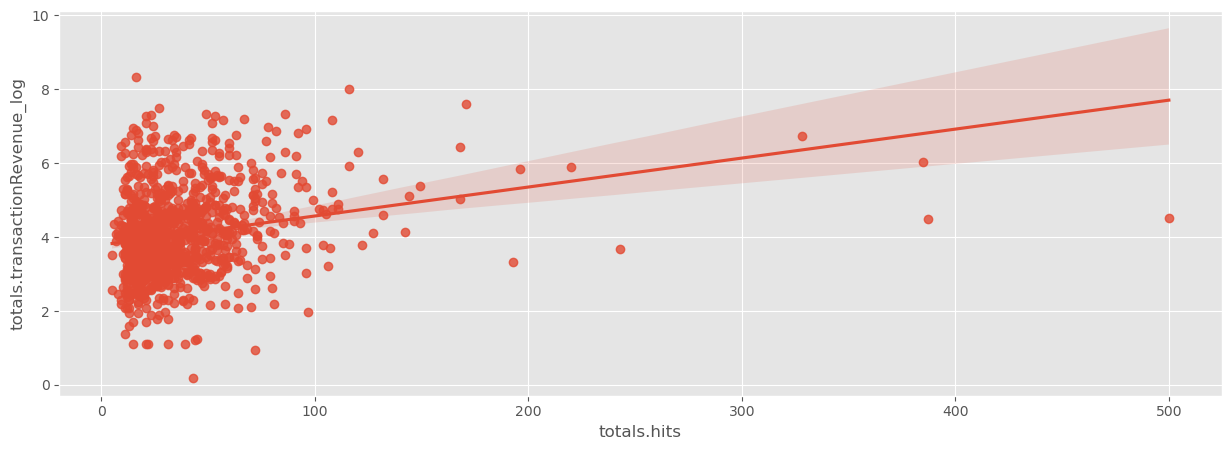

In [134]:
plt.figure(figsize=(15,5))
sns.regplot(
    data = df[df['visitWithTransaction'] == 1], # Le pasamos los datos que tienen compras
    x = 'totals.hits', # Le paso la variable que quiero analizar
    y = target_log # Le paso el target
);

- Se parece al visit number, con un poquito más de dispersión
- Distribución tirada a la izquierda
- Hay algunos valores que no se si son outliers o no. Tendré que normalizarla para saberlo

In [135]:
# Normalizamos la variable
df['totals.hits_log'] = df['totals.hits'].apply(lambda x: np.log1p(x))

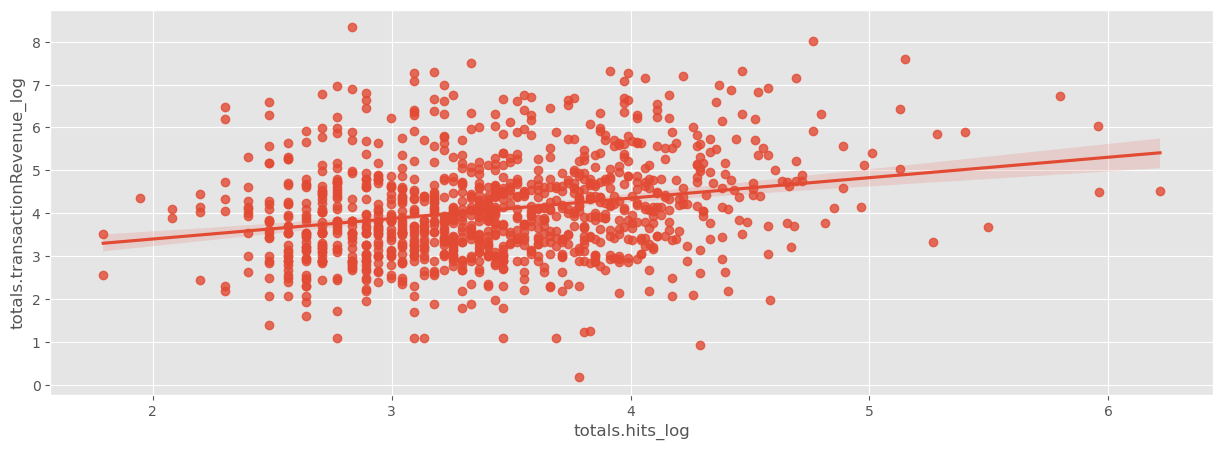

In [136]:
plt.figure(figsize=(15,5))
sns.regplot(
    data = df[df['visitWithTransaction'] == 1],
    x = 'totals.hits_log',
    y = target_log
);

- Se puede apreciar una mayor correlación entre ellas. Tiene una corelación relativamente alta. 
- La correlación positiva que aparece, tiene sentido --> Para poder hacer una compra, primero tienes que hacer un click al carrito. Cuantos más clicks hagas al carrito, mayor será la cuantía de la transacción.

In [137]:
# Correlación de Pearson
df[['totals.hits_log', target_log]].corr()

,totals.hits_log,totals.transactionRevenue_log
totals.hits_log,1.000000,0.299851
totals.transactionRevenue_log,0.299851,1.000000


In [138]:
df.pivot_table(index='totals.hits', values='visitWithTransaction', aggfunc=[len, np.sum, np.mean]).head(30)

,len,sum,mean
,visitWithTransaction,visitWithTransaction,visitWithTransaction
totals.hits,,,
1,44587,0,0.000000
2,13939,0,0.000000
3,6961,0,0.000000
4,4209,0,0.000000
5,3071,2,0.000651
6,2402,1,0.000416
7,1932,2,0.001035
8,1486,4,0.002692


**En general**:
1. Para variables categóricas:
    - Miramos la media de cada etiqueta con el target
    - Tiene la parte de data preparation
2. Para variables numéricas contra un target numérico:
    - Miramos las distribuciones que sean parecidas (con un describe y un scaterplot, por ejemplo) y ver la correlación (pero mirando tanto la variable tal cual como la variable normalizada).
    - No tiene la parte de data preparation

### 3.2.10. PageViews

Número de páginas que visita en nuestra web en cada sesión

In [139]:
df['totals.pageviews'].head(5)

sessionId
1438082600262726746_1472803483    1
1283542838194038522_1472885255    1
4339756682310369249_1472828340    1
062441254657008214_1472875520     1
1381975521299261523_1472829727    1
Name: totals.pageviews, dtype: object

In [140]:
df['totals.pageviews'].describe()

count     90296
unique      125
top           1
freq      45150
Name: totals.pageviews, dtype: object

In [141]:
df['totals.pageviews'].isnull().sum()

10

- También es muy parecida a las anteriores
- El top es 1 pageview y ocurre la mitad de las veces (45150)
- El valor mínimo que va a tener es de un 1 --> al acceder a nuestra web, como mínimo va a visitar una página
- Hay 10 nulos --> Imputamos
- Aparece como object --> Tendremos que pasarla a numérica

*¿Cómo podemos imputar los nulos?*
1. Imputando como un 1, ya que si visita la página como mínimo tiene un 1 y además es el valor más frecuente
2. Puede que quiera acceder a la página pero no cargue, entonces sería un 0 --> pero no lo sabemos
3. Puedo imputarlo con un valor con el que el algoritmo sepa diferenciar entre lo que es nulo y no nulo --> Con un 0, porque es un valor extremo y además no está muy alejado del 1, por lo que si utilizamos una regresión lineal, este outlier no me va a generar ningún problema. Además, tan sólo son 10 observaciones, con lo que si metemos un -1 tampoco va a pasar nada.

In [142]:
# Imputamos los nulos con un 0
# Valor extremo porque quiero diferenciarlo de los no nulos
# Valor no muy extremo porque igual utilizo una regresión lineal
df['totals.pageviews'].fillna(0, inplace=True)

In [143]:
# Convertimos a integer
df['totals.pageviews'] = df['totals.pageviews'].astype(int)

In [144]:
df['totals.pageviews'].describe()

count    90306.000000
mean         3.849124
std          7.096109
min          0.000000
25%          1.000000
50%          1.000000
75%          4.000000
max        469.000000
Name: totals.pageviews, dtype: float64

Vemos una distribución muy parecida a las variables anteriores

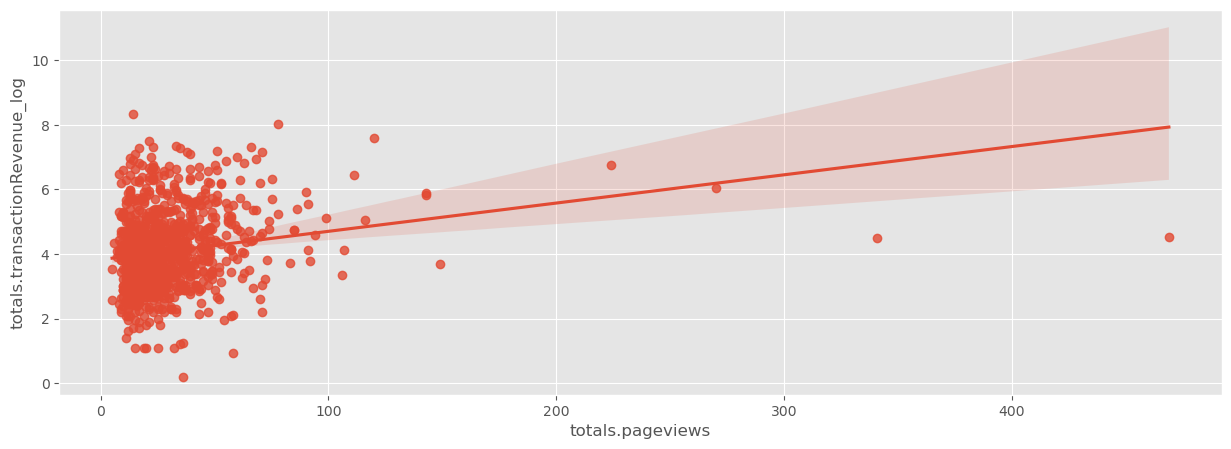

In [145]:
# Visualizamos el pageviews
plt.figure(figsize=(15,5))
sns.regplot(
    data = df[df['visitWithTransaction'] == 1],
    x = 'totals.pageviews',
    y = target_log
);

In [146]:
# Correlación de Pearson
df[['totals.pageviews', target_log]].corr()

,totals.pageviews,totals.transactionRevenue_log
totals.pageviews,1.000000,0.395228
totals.transactionRevenue_log,0.395228,1.000000


In [147]:
# Normalizamos el pageviews para que tenga la misma distribución que el target
df['totals.pageviews_log'] = df['totals.pageviews'].apply(lambda x: np.log1p(x))

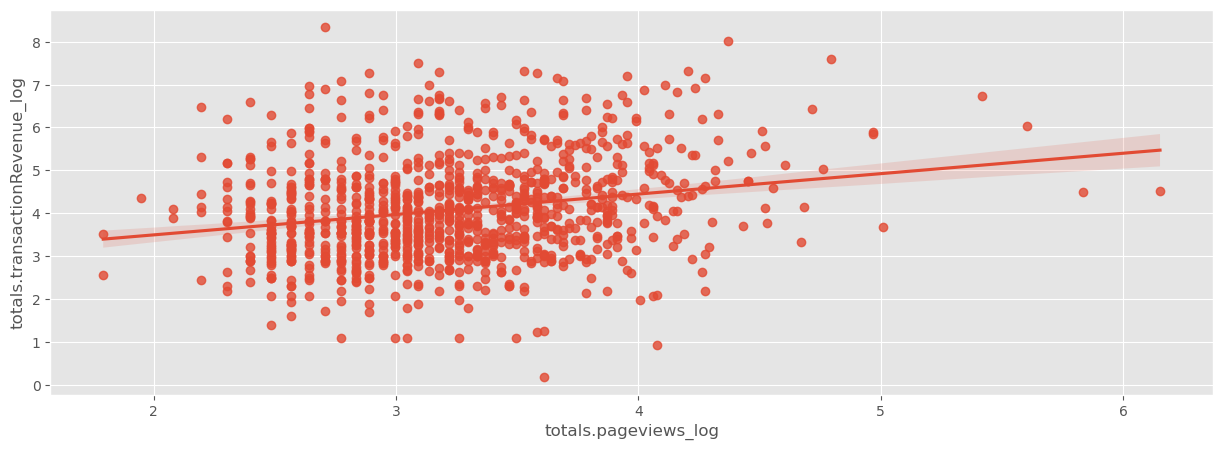

In [148]:
# Visualizamos el totals.pageviews normalizado
plt.figure(figsize=(15,5))
sns.regplot(
    data = df[df['visitWithTransaction'] == 1],
    x = 'totals.pageviews_log',
    y = target_log
);

In [149]:
# Correlación de Pearson
df[['totals.pageviews_log', target_log]].corr()

,totals.pageviews_log,totals.transactionRevenue_log
totals.pageviews_log,1.000000,0.306681
totals.transactionRevenue_log,0.306681,1.000000


Podemos analizar la correlación entre pageviews y Hits 

In [150]:
# Correlación de Pearson
df[['totals.pageviews', 'totals.hits']].corr()

,totals.pageviews,totals.hits
totals.pageviews,1.000000,0.982462
totals.hits,0.982462,1.000000


In [151]:
# Correlación de Pearson
df[['totals.pageviews_log', 'totals.hits_log']].corr()

,totals.pageviews_log,totals.hits_log
totals.pageviews_log,1.00000,0.99126
totals.hits_log,0.99126,1.00000


Vemos que la correlación es altisima:
- Si usamos un Decisiontree nos da igual mantener las dos, porque el algoritmo puede coger una u otra de manera random. 
- Si usamos una regresión lineal, esto puede generar problemas (la predicción será igual de buena pero genera problemas en interpretar el impacto en el target de una variable o la otra. Como las dos se parecen mucho, el modelo no me va a saber decir si el impacto sobre el target viene por los hits o por los pageviews --> Se acaba liando).

La eliminamos por si utilizo una regresión lineal

In [152]:
# Eliminamos las variables que tienen correlación alta con hits
df.drop(['totals.pageviews', 'totals.pageviews_log'], axis = 1, inplace = True)

### 3.2.11. totals.bounces y totals.newvisit

In [153]:
df['totals.bounces'].describe()

count     44973
unique        1
top           1
freq      44973
Name: totals.bounces, dtype: object

In [154]:
df['totals.newVisits'].describe()

count     70392
unique        1
top           1
freq      70392
Name: totals.newVisits, dtype: object

Ambas son booleanas 1/0. Las dejo de lado.

## **Variables de localización- GeoNetwork**

In [155]:
df.describe(include = 'object').T

,count,unique,top,freq
channelGrouping,90306,8,Organic Search,38445
device.deviceCategory,90306,3,desktop,66572
geoNetwork.continent,90306,6,Americas,44890
geoNetwork.subContinent,90306,23,Northern America,38911
geoNetwork.country,90306,189,United States,36335
geoNetwork.region,90306,332,not available in demo dataset,50639
geoNetwork.metro,90306,86,not available in demo dataset,50639
geoNetwork.city,90306,542,not available in demo dataset,50639
geoNetwork.networkDomain,90306,7394,(not set),24320
totals.bounces,44973,1,1,44973


- Continent --> categórica con 6 etiquetas. Aplicaremos OHE
- Sucontinent --> categórica con 23 etiquetas (mayor granularidad). Aplicamos OHE
- Country --> Categórica con 186. No podemos hacer una reducción de etiquetas, agrupando las minoritarias porque estaríamos obteniendo la misma información que en subcontinent (por ejemplo en subcontinet tenemos  Northern America y en Country nos quedaremos con United States que es casi lo mismo). Lo que haremos es agrupar aquellas que se parecen más a la media del target. Es decir, si en un pais la mayoría compra o la mayoría no compra, es un pais relevante para el modelo. Si tengo un pais que se comporta como la media del target, ese pais no es relevante (esa información ya la tengo a niveles de menos granularidad como continente o subcontinente). Resumiendo: los que mas van a ayudar al algoritmo serán aquellos paises que se diferencien más del target. A esta reducción de etiquetas la llamamos **SetOthersPataNegra**. Y finalmente aplicaremos OHE
- Region
- Metro
- City
- NetworkDomain

### 3.2.12. Continent

In [156]:
explore_cat_values(dataframe = df, column = 'geoNetwork.continent', target_column = target_log)

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
geoNetwork.continent,,,,,
Americas,44890,0.497088,1097,0.024438,4.078602
Asia,22359,0.247592,2,0.000089,3.012438
Europe,19910,0.220473,9,0.000452,3.941313
Oceania,1556,0.017230,2,0.001285,4.329520


**OJO**: Habíamos visto que esta variable tenía 6 etiquetas y aquí sólo aparecen 4. Eso es debido a que la función *explore_cat_values* sólo nos devuelve las compras. Las sesiones que no tienen compras no aparecen. para verlas utilizamos la otra función con la que las pñodemos visualizar

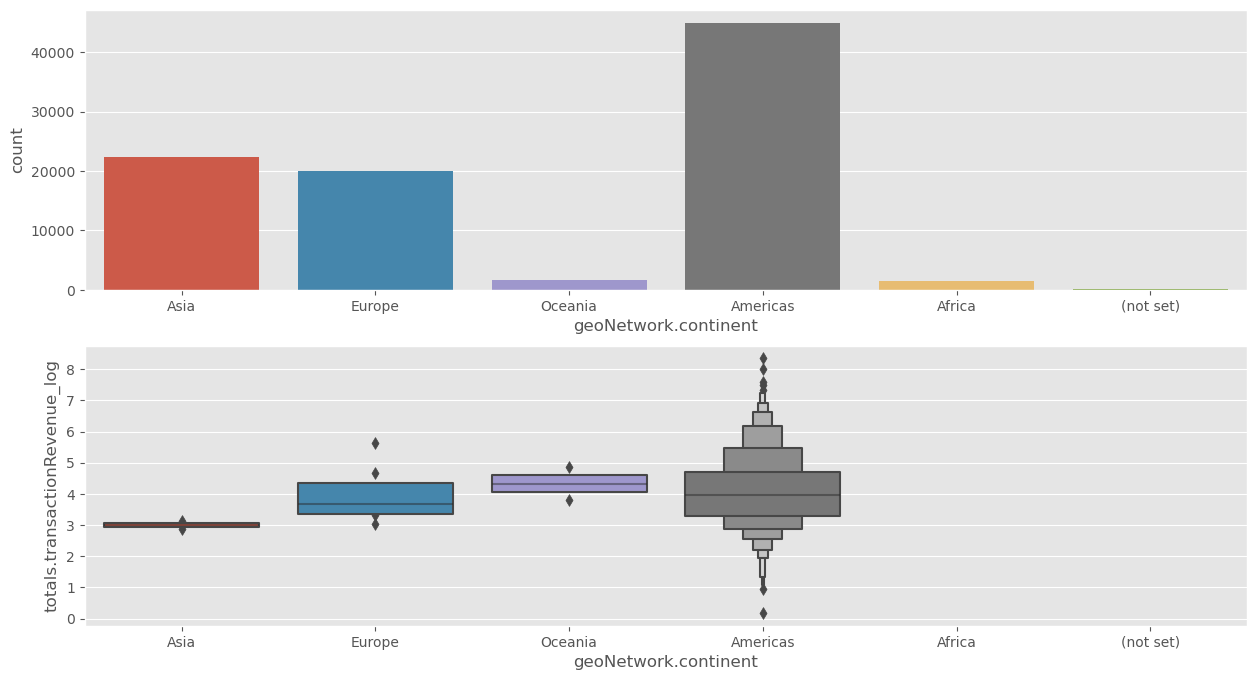

In [157]:
plot_cat_values(dataframe = df, column = 'geoNetwork.continent', target_column = target_log)

Aquí podemos ver las dos etiquetas en las que no hay ninguna compra (Africa y not_set)

Esta es una variable muy relevante, porque el algoritmo va a poder diferenciar entre América y el resto. Y de lo que es el resto, va a predecir que no hacen compras ( tan sólo hay 13 transacciones con un ratio de transacción muy bajo).

Haremos un OHE

### 3.2.13. SubContinent

In [158]:
explore_cat_values(dataframe = df, column = 'geoNetwork.subContinent', target_column = target_log)

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
geoNetwork.subContinent,,,,,
Australasia,1537,0.017020,2,0.001301,4.329520
Caribbean,248,0.002746,3,0.012097,4.114201
Central America,1553,0.017197,3,0.001932,4.357528
Eastern Asia,4716,0.052222,1,0.000212,2.889816
Eastern Europe,4536,0.050229,1,0.000220,4.343286
Northern America,38911,0.430879,1082,0.027807,4.078029
Northern Europe,5919,0.065544,6,0.001014,3.801762
South America,4178,0.046265,9,0.002154,4.042635
Southern Europe,3595,0.039809,1,0.000278,4.654912


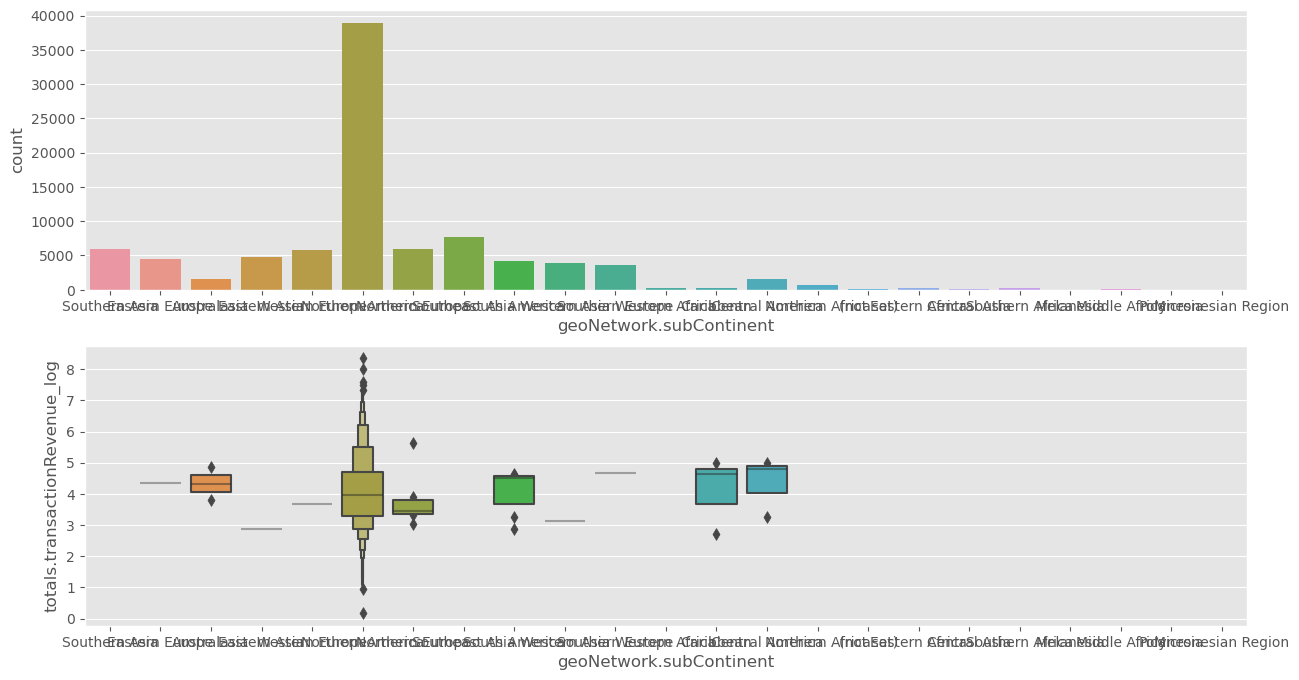

In [159]:
plot_cat_values(dataframe = df, column = 'geoNetwork.subContinent', target_column = target_log)

- Los que más compran son los de Norte América, por lo que hay una alta correlación entre Continente y subcontinente.
- Si tuviesemos una distribución parecida entre norte américa y sur américa, podría ser una variable relevante para el algoritmo, pero como no lo es, prácticamente me está diciendo lo mismo que la anterior variable. El algoritmo predicirá que todo el que no sea de NorteAmérica no va a comprar.

Finalmente aplicaremos OHE

### 3.2.14. Country

In [160]:
results_by_country = explore_cat_values(dataframe = df, column = 'geoNetwork.country', target_column = target_log)
results_by_country

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
geoNetwork.country,,,,,
Australia,1309,0.014495,2,0.001528,4.329520
Brazil,2004,0.022191,1,0.000499,4.629765
Canada,2572,0.028481,19,0.007387,4.426030
Chile,192,0.002126,1,0.005208,2.889816
Colombia,464,0.005138,1,0.002155,3.711130
Georgia,91,0.001008,1,0.010989,3.135059
Germany,2018,0.022346,1,0.000496,3.663049
Guatemala,68,0.000753,1,0.014706,3.264996
Ireland,682,0.007552,2,0.002933,3.292852


- Seguimos teniendo EEUU como el que más
- Hay algún pais con una tasa de conversión más elevada que el resto como Santa Lucía, Puerto Rico, etc, pero son muy poquitas transacciones
- Hay paises que tienen muchas visitas pero muy pocas transacciones, como United Kingdom, que tiene una tasa de conversión muy baja.
- Por lo tanto, para cualquier pais que no sea United States, el algortimo va a predecir que no va a comprar.
- No me fijo en la transacción media del resto de paises porque como hay tan pocas transacciones no me va a dar ninguna información relevante en cuanto al gasto.

Lo que quiero es coger aquellos paises que o bien compran mucho o bien compran muy poco. Quiero ver las situaciones más extremas.

La ordenación la podemos hacer de varias maneras:
- Mediante el mean_revenue_log. Si tenemos un dataset lo suficientemente grande cojeremos este. Si lo hacemos con este me quedo con los paises que gastan mucho y los paises que gastan poco.
- Mediante el pct_transactions. No es exactamente el target (cantidad que se gasta en cada sesión), pero es una buena aproximación. Si elegimos este, me quedaría con los paises que casi siempre me compran y con los que casi nunca me compran.

In [161]:
# Ordeno por mean_revenue_log en orden ascendente
results_by_country.sort_values(by = 'pct_transactions')

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
geoNetwork.country,,,,,
Germany,2018,0.022346,1,0.000496,3.663049
Brazil,2004,0.022191,1,0.000499,4.629765
Italy,1135,0.012568,1,0.000881,4.654912
United Kingdom,3805,0.042135,4,0.001051,4.056217
Australia,1309,0.014495,2,0.001528,4.329520
Mexico,1280,0.014174,2,0.001563,4.903794
Romania,639,0.007076,1,0.001565,4.343286
Peru,581,0.006434,1,0.001721,3.663562
South Korea,511,0.005659,1,0.001957,2.889816


De momento voy a ordenar según el mean_revenue_log

In [162]:
# Ordeno por mean_revenue_log en orden ascendente
results_by_country.sort_values(by = 'mean_revenue_log')

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
geoNetwork.country,,,,,
South Korea,511,0.005659,1,0.001957,2.889816
Chile,192,0.002126,1,0.005208,2.889816
Georgia,91,0.001008,1,0.010989,3.135059
Guatemala,68,0.000753,1,0.014706,3.264996
Ireland,682,0.007552,2,0.002933,3.292852
Germany,2018,0.022346,1,0.000496,3.663049
Peru,581,0.006434,1,0.001721,3.663562
Colombia,464,0.005138,1,0.002155,3.711130
Puerto Rico,79,0.000875,2,0.025316,3.852677


Los paises del medio son irrelevantes para el modelo. Me interesan los que se gastan mucho y los que se gastan poco (los extremos).

No me interesan los paises con pocas observaciones, como Santa Lucía. Ponemos un mínimo de 100 observaciones. **Podemos jugar con este parámetro para ver como se comporta el algoritmo**

In [163]:
results_by_country[results_by_country['n_rows'] > 100].sort_values(by = 'mean_revenue_log')

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
geoNetwork.country,,,,,
Chile,192,0.002126,1,0.005208,2.889816
South Korea,511,0.005659,1,0.001957,2.889816
Ireland,682,0.007552,2,0.002933,3.292852
Germany,2018,0.022346,1,0.000496,3.663049
Peru,581,0.006434,1,0.001721,3.663562
Colombia,464,0.005138,1,0.002155,3.711130
United Kingdom,3805,0.042135,4,0.001051,4.056217
United States,36335,0.402354,1063,0.029256,4.071809
Venezuela,198,0.002193,5,0.025253,4.297889


In [164]:
# Me quedo con los 5 paises que menos gastan y los guardo en uan lista (el 5 es otro parámetro con el que podemos jugar)
last_countries = results_by_country[results_by_country['n_rows'] > 100].sort_values(by='mean_revenue_log').head().index.to_list()
last_countries

['Chile', 'South Korea', 'Ireland', 'Germany', 'Peru']

In [165]:
# Me quedo con los 5 paises que más gastan y los guardo en una lista
first_countries = results_by_country[results_by_country['n_rows'] > 100].sort_values(by='mean_revenue_log').tail().index.to_list()
first_countries

['Romania', 'Canada', 'Brazil', 'Italy', 'Mexico']

In [166]:
# junto las dos listas en una única lista --> lista de paises sobre los que quiero tener una etiqueta específica
# El resto de paises no me interesan ya que se comportan mas o menos como la media del target
country_list = last_countries + first_countries
country_list

['Chile',
 'South Korea',
 'Ireland',
 'Germany',
 'Peru',
 'Romania',
 'Canada',
 'Brazil',
 'Italy',
 'Mexico']

Generamos una función con todos estos pasos --> **setOthersPataNegra**

Cogemos la función SetOthers y la modificamos

In [167]:
setOthers??

Signature: setOthers(dataframe, column, num_values)
Source:   
def setOthers(dataframe, column, num_values):
    ''' 
    Reduce el número de etiquetas.
    Agrupa las etiquetas de la variable categórica (column) que quedan fuera de las num_values primeras,
    en una única llamada 'Others', pasándole el dataframe.
    '''
    
    # Me quedo con la lista de las primeras etiquetas (num_values)
    top_categories = dataframe[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()

    # Añado a la lista la etiqueta 'Others'
    top_categories_list.append('Others')

    # Convierto a categórica sólo las etiquetas que le indico, de la variable (column)
    # Las otras etiquetas que no están en la lista, se convierten en nulos
    dataframe[column] = pd.Categorical(
        dataframe[column], 
        categories = top_categories_list
    )

    # Relleno los nulos con 'Others' y me devuelve las etiquetas de la variable (column)
    return dataframe[

In [168]:
def setOthersPataNegra(dataframe, column, target_column, num_rows_min, top_n):
    ''' 
    Reduce el número de etiquetas.
    Agrupa las etiquetas de la variable categórica (column) que tienen un mean_revenue_log parecido al target
    en una única llamada 'Others', pasándole el dataframe.
    '''
    
    #Me quedo con la lista de las primeras etiquetas (num_values)
    #top_categories = dataframe[column].value_counts().head(num_values)
    #top_categories_list = top_categories.index.to_list()

    # Tabla descriptiva de la variable categórica
    results_by_category = explore_cat_values(dataframe, column, target_column)

    # Lista de los 'top_n' paises que menos gastan (con un número mínimo de observaciones 'num_rows_min')
    last_categories = results_by_category[results_by_category['n_rows'] > num_rows_min].sort_values(by='mean_revenue_log').head(top_n).index.to_list()

    # Lista de los 'top_n' paises que más gastan (con un número mínimo de observaciones 'num_rows_min')
    first_categories = results_by_category[results_by_category['n_rows'] > num_rows_min].sort_values(by='mean_revenue_log').tail(top_n).index.to_list()

    # Lista de paises importantes para esta variable categórica
    top_categories_list = first_categories + last_categories

    # Añado a la lista la etiqueta 'Others' (donde voy a agrupar el resto de paises)
    top_categories_list.append('Others')

    # Convierto a categórica sólo las etiquetas que le indico, de la variable (column)
    # Las otras etiquetas que no están en la lista, se convierten en nulos
    dataframe[column] = pd.Categorical(
        dataframe[column], 
        categories = top_categories_list
    )

    # Relleno los nulos con 'Others' y me devuelve las etiquetas de la variable (column)
    return dataframe[column].fillna('Others') # No es recomendable meter el inplace = True en el fillna. Es mejor guardar el resultado en una variable

Incluso podemos parametrizar la variable según lo ordeno ('mean_revenue_log' o 'pct_transactions')

In [169]:
df['geoNetwork.country'] = setOthersPataNegra(dataframe = df, column = 'geoNetwork.country', target_column = target_log, num_rows_min = 100, top_n = 5)
df['geoNetwork.country']

sessionId
1438082600262726746_1472803483         Others
1283542838194038522_1472885255         Others
4339756682310369249_1472828340         Others
062441254657008214_1472875520          Others
1381975521299261523_1472829727    South Korea
                                     ...     
8316382343226738015_1483549157         Others
6636384798982309878_1483525429         Others
469840327005431380_1483573235         Germany
2140149974339316233_1483557808         Others
5123779100307500332_1483554750         Others
Name: geoNetwork.country, Length: 90306, dtype: category
Categories (11, object): ['Romania', 'Canada', 'Brazil', 'Italy', ..., 'Ireland', 'Germany', 'Peru', 'Others']

11 etiquetas distintas ( 5 por arriba, 5 por abajo y el others)

In [170]:
df['geoNetwork.country'].value_counts()

Others         78692
Canada          2572
Germany         2018
Brazil          2004
Mexico          1280
Italy           1135
Ireland          682
Romania          639
Peru             581
South Korea      511
Chile            192
Name: geoNetwork.country, dtype: int64

Vemos que el Others tiene agrupadas la mayoría de las etiquetas que no le van a aportar nada al modelo. Lo vemos:

In [171]:
explore_cat_values(dataframe = df, column = 'geoNetwork.country', target_column = target_log).sort_values(by = 'mean_revenue_log')

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
geoNetwork.country,,,,,
Chile,192,0.002126,1,0.005208,2.889816
South Korea,511,0.005659,1,0.001957,2.889816
Ireland,682,0.007552,2,0.002933,3.292852
Germany,2018,0.022346,1,0.000496,3.663049
Peru,581,0.006434,1,0.001721,3.663562
Others,78692,0.871393,1080,0.013724,4.071444
Romania,639,0.007076,1,0.001565,4.343286
Canada,2572,0.028481,19,0.007387,4.426030
Brazil,2004,0.022191,1,0.000499,4.629765


Others efectivamente se encuentra en el medio, por lo que no va a ser relevante para el modelo.

Con esto hemos reducido la variable a tan sólo 11 etiquetas. Ya podemos aplicar OHE

La etiqueta Others es redundante:
- Si utilizamos decisiontree, la podemos dejar (no le va a afectar)
- Si no, podemos eliminarla que no pasaría nada.

### 3.2.15. Region, Metro, City

In [172]:
df[['geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city']].describe()

,geoNetwork.region,geoNetwork.metro,geoNetwork.city
count,90306,90306,90306
unique,332,86,542
top,not available in demo dataset,not available in demo dataset,not available in demo dataset
freq,50639,50639,50639


- La región, el area metropolitana y la ciudad nos van a dar información muy parecida, están muy correlacionadas. Si aplicamos un decisiontree no pasaría nada porque el algoritmo va a coger una de las tres de forma aleatoria, pero si aplicamos una regresión lineal, la correlación entre variables no va a afectar a la predicción pero sí va a afectar al impacto que tienen sobre la predicción estas variables (el algoritmo no sabría explicarlo), por lo que nos quedamos con una y eliminamos las otras dos.
- Además, no tenemos información de la etiqueta más frecuente en ninguna de las tres variables ( si tuviesemos esta información las miraríamos porsi).

In [173]:
explore_cat_values(dataframe = df, column = 'geoNetwork.city', target_column = target_log).sort_values(by = 'mean_revenue_log')

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
geoNetwork.city,,,,,
Boston,98,0.001085,1,0.010204,2.659560
Syracuse,2,0.000022,1,0.500000,2.887590
Dallas,164,0.001816,1,0.006098,3.044046
San Mateo,37,0.000410,1,0.027027,3.112181
Dublin,516,0.005714,2,0.003876,3.292852
Kitchener,35,0.000388,1,0.028571,3.338613
Kansas City,11,0.000122,2,0.181818,3.353329
Phoenix,41,0.000454,1,0.024390,3.366606
Dundalk,3,0.000033,1,0.333333,3.366606


Podemos observar varias cosas:
- Cuanta más granularidad, menos observaciones me encuentro en las etiquetas, por lo que menor va a ser el impacto de estas etiquetas en el modelo
- not available in demo dataset son la inmensa mayoría y además se encuentra en el medio
- La segunda con más observaciones es 'not set'

Aplicamos la función setOthersPataNegra --> Nos quedamos las 3 por arriba y las 3 por abajo y el resto las agrupamos en Others

In [174]:
df['geoNetwork.city'] = setOthersPataNegra(dataframe = df, column = 'geoNetwork.city', target_column = target_log, num_rows_min = 100, top_n = 3)
df['geoNetwork.city']

sessionId
1438082600262726746_1472803483    Others
1283542838194038522_1472885255    Others
4339756682310369249_1472828340    Others
062441254657008214_1472875520     Others
1381975521299261523_1472829727    Others
                                   ...  
8316382343226738015_1483549157    Others
6636384798982309878_1483525429    Others
469840327005431380_1483573235     Others
2140149974339316233_1483557808    Others
5123779100307500332_1483554750    Others
Name: geoNetwork.city, Length: 90306, dtype: category
Categories (7, object): ['(not set)', 'Mexico City', 'Toronto', 'Dallas', 'Dublin', 'La Victoria', 'Others']

In [175]:
df['geoNetwork.city'].value_counts()

Others         85229
(not set)       3489
Dublin           516
Toronto          488
Mexico City      245
La Victoria      175
Dallas           164
Name: geoNetwork.city, dtype: int64

In [176]:
explore_cat_values(dataframe = df, column = 'geoNetwork.city', target_column = target_log).sort_values(by = 'mean_revenue_log')

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
geoNetwork.city,,,,,
Dallas,164,0.001816,1,0.006098,3.044046
Dublin,516,0.005714,2,0.003876,3.292852
La Victoria,175,0.001938,1,0.005714,3.663562
Others,85229,0.943780,1095,0.012848,4.069242
(not set),3489,0.038635,2,0.000573,4.745148
Mexico City,245,0.002713,1,0.004082,4.803775
Toronto,488,0.005404,8,0.016393,5.121778


Nos queda Others que son la inmensa mayoría en el medio, por lo que no va a ser relevante para el modelo y hacemos que se fije en las otras 6.

**GeoNetwork - Metro**

In [177]:
df['geoNetwork.metro'].head(20)

sessionId
1438082600262726746_1472803483                            (not set)
1283542838194038522_1472885255        not available in demo dataset
4339756682310369249_1472828340                            (not set)
062441254657008214_1472875520         not available in demo dataset
1381975521299261523_1472829727                            (not set)
0808960480137718074_1472804813                            (not set)
5637149591671308745_1472819775                            (not set)
9870305678537397476_1472814953        not available in demo dataset
9271059985757878297_1472838507        not available in demo dataset
4283381413149200106_1472836538                            (not set)
2870162892603227525_1472858877        not available in demo dataset
9459337971215135976_1472816813        not available in demo dataset
401634289917197318_1472830591                             (not set)
2332957681418505787_1472804709                            (not set)
240989783927851488_1472857884     San 

In [178]:
df['geoNetwork.metro'].describe()

count                             90306
unique                               86
top       not available in demo dataset
freq                              50639
Name: geoNetwork.metro, dtype: object

In [179]:
explore_cat_values(dataframe = df, column = 'geoNetwork.metro', target_column = target_log).sort_values(by = 'mean_revenue_log')

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
geoNetwork.metro,,,,,
Syracuse NY,2,0.000022,1,0.500000,2.887590
Dallas-Ft. Worth TX,181,0.002004,1,0.005525,3.044046
Kansas City MO,12,0.000133,2,0.166667,3.353329
Phoenix AZ,54,0.000598,1,0.018519,3.366606
Baltimore MD,5,0.000055,1,0.200000,3.366606
Philadelphia PA,92,0.001019,2,0.021739,3.500736
Atlanta GA,265,0.002934,14,0.052830,3.714678
Roanoke-Lynchburg VA,230,0.002547,3,0.013043,3.746739
Washington DC (Hagerstown MD),316,0.003499,13,0.041139,3.770209


70000 de las 90000 observaciones no nos aporta información (not available in demo dataset o not set) y el resto de las etiquetas nos aporta información que es parecida a la que nos aporta city. La eliminamos

In [180]:
# La eliminamos
df.drop('geoNetwork.metro', axis=1, inplace=True)

**GeoNetwork - Region**

In [181]:
df['geoNetwork.region'].head(10)

sessionId
1438082600262726746_1472803483                            Sindh
1283542838194038522_1472885255    not available in demo dataset
4339756682310369249_1472828340                        Karnataka
062441254657008214_1472875520     not available in demo dataset
1381975521299261523_1472829727                            Seoul
0808960480137718074_1472804813                    North Holland
5637149591671308745_1472819775             Masovian Voivodeship
9870305678537397476_1472814953    not available in demo dataset
9271059985757878297_1472838507    not available in demo dataset
4283381413149200106_1472836538                  New South Wales
Name: geoNetwork.region, dtype: object

In [182]:
df['geoNetwork.region'].describe()

count                             90306
unique                              332
top       not available in demo dataset
freq                              50639
Name: geoNetwork.region, dtype: object

In [183]:
explore_cat_values(dataframe = df, column = 'geoNetwork.region', target_column = target_log).sort_values(by = 'mean_revenue_log')

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
geoNetwork.region,,,,,
County Dublin,369,0.004086,2,0.005420,3.292852
Missouri,13,0.000144,2,0.153846,3.353329
Arizona,54,0.000598,1,0.018519,3.366606
Maryland,6,0.000066,1,0.166667,3.366606
British Columbia,70,0.000775,1,0.014286,3.663305
Lima Region,175,0.001938,1,0.005714,3.663562
Georgia,266,0.002946,14,0.052632,3.714678
Virginia,304,0.003366,3,0.009868,3.746739
District of Columbia,246,0.002724,13,0.052846,3.770209


- 50000 de las 90000 observaciones no nos aporta información (not available in demo dataset). De hecho, son las mismas filas que en city y en metro.
- Con tiempo, podríamos mirar el comportamiento de las ciudades o de las areas metropolitaneas y de una misma region y ver su comportamiento frente al target. Si el comportamiento es muy similar, en vez de quedarnos con las ciudades o areas metropolitaneas, podríamos agruparlo todo y quedarnos sólo con la region. Por ejemplo, Los Angeles y San Francisco tienen tasas de conversión parecidas y gastan más o menos lo mismo, por lo que en vez de quedarnos con estas dos y eliminar California, podríamos quedarnos con California y eliminar Los Angeles y San Francisco.

Lo que haremos es eliminar la region

In [184]:
# La eliminamos
df.drop('geoNetwork.region', axis = 1, inplace = True)

### 3.2.16. Network Domain

In [185]:
df['geoNetwork.networkDomain'].head()

sessionId
1438082600262726746_1472803483    unknown.unknown
1283542838194038522_1472885255       broadband.hu
4339756682310369249_1472828340    unknown.unknown
062441254657008214_1472875520          uwa.edu.au
1381975521299261523_1472829727    unknown.unknown
Name: geoNetwork.networkDomain, dtype: object

In [186]:
df['geoNetwork.networkDomain'].describe()

count         90306
unique         7394
top       (not set)
freq          24320
Name: geoNetwork.networkDomain, dtype: object

Tenemos 7394 etiquetas distintas

In [187]:
df['geoNetwork.networkDomain'].value_counts().head(50)

(not set)                24320
unknown.unknown          14545
comcast.net               2852
rr.com                    1425
verizon.net               1353
ttnet.com.tr              1295
comcastbusiness.net       1007
hinet.net                  761
virginm.net                606
cox.net                    581
prod-infinitum.com.mx      568
3bb.co.th                  566
btcentralplus.com          561
att.net                    525
sbcglobal.net              523
optonline.net              515
google.com                 511
totbb.net                  481
asianet.co.th              456
vnpt.vn                    444
rima-tde.net               434
pldt.net                   384
amazonaws.com              378
t-ipconnect.de             377
telecomitalia.it           363
virtua.com.br              337
qwest.net                  329
airtelbroadband.in         323
bell.ca                    296
ztomy.com                  288
bhn.net                    287
superonline.net            271
actcorp.

- Las dos primeras son desconocidas. **OJO AL AGRUPAR DIFERENTES DESCONOCIDOS** >> Son desconocidos con origenes de desconocimiento distintos, por lo que pueden comportarse de manera diferentes con respecto al target. A veces tienen comportamientos distintos y vale la pena dejarlas por separado y más aquí que cada una de ellas tienen un montón de observaciones por separado.
- De las 90000 observaciones 40000 tienen un origen desconocido, pero todavía tengo 50000 que me pueden aportar información interesante.
- Otra cosa interesante es que la terminación de los dominios indican el pais de procedencia. Si no tuviesemos la variable country, podríamos crearla desde aquí. Por ejemplo ziggo.nl --> 'nl' es de Holanda y ziggo es de Vodafone, También podríamos sacar información a partir del nombre de la compañía.


Vamos a utilizar una técnica de **Natural Languages Processing** para hacer un conteo de palabras (de momento, no se si la información que voy a sacar va a ser relevante o no ... vamos probando cosas):
- Nos aseguramos que la variable sea un string
- Utilizamos el método contains dándole el string que buscamos y hacemos que no sea case sensitive (que no diferencie entre mmayúsculas y minúsculas)
- Me va a devolver un booleano True/false diciéndome si esa fila contiene o no el string que estoy buscando.
- Lo convierto a booleano 1/0

In [188]:
df['network_net'] = df['geoNetwork.networkDomain'].str.contains('.net', case = False).astype(int)
df['network_net'] # 0 no es .net y 1 es .net

sessionId
1438082600262726746_1472803483    0
1283542838194038522_1472885255    0
4339756682310369249_1472828340    0
062441254657008214_1472875520     0
1381975521299261523_1472829727    0
                                 ..
8316382343226738015_1483549157    1
6636384798982309878_1483525429    0
469840327005431380_1483573235     0
2140149974339316233_1483557808    1
5123779100307500332_1483554750    1
Name: network_net, Length: 90306, dtype: int32

Vemos como se comporta esta variable con respecto al target

In [189]:
# Tabla descriptiva de network_net
results_by_network_net = explore_cat_values(dataframe = df, column = 'network_net', target_column = target_log)
results_by_network_net

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
network_net,,,,,
0,64768,0.717206,807,0.012460,4.096480
1,25538,0.282794,303,0.011865,4.021527


El hecho de que el trafico venga de .net o no, no parece que sea muy relevante, porque los dos tienen comportamientos muy parecidos (pct_transactions y mean_revenue_log muy similares)

In [190]:
explore_cat_values(dataframe = df, column = 'network_net', target_column = target)

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
network_net,,,,,
0,64768,0.717206,807,0.012460,126.397100
1,25538,0.282794,303,0.011865,134.959802


Podemos comprobar tambien la existencia o no de outliers comparando las dos versiones del target (target y target_log):
- Vemos que en con el target_log, los usuarios que usan el .net gastan un poquito menos que los que no lo usan, en cambio con el target, son los usuarios que usan el .net los que gastan un poco más --> Este cambio de comportamiento con respecto al target, es indicativo de que puede haber algún outlier (pero no es super bestia --> no nos va a afectar).

In [191]:
df['network_com'] = df['geoNetwork.networkDomain'].str.contains('.com', case = False).astype(int)
df['network_com'] # 0 no es .com y 1 es .com

sessionId
1438082600262726746_1472803483    0
1283542838194038522_1472885255    0
4339756682310369249_1472828340    0
062441254657008214_1472875520     0
1381975521299261523_1472829727    0
                                 ..
8316382343226738015_1483549157    0
6636384798982309878_1483525429    0
469840327005431380_1483573235     0
2140149974339316233_1483557808    0
5123779100307500332_1483554750    0
Name: network_com, Length: 90306, dtype: int32

In [192]:
# Tabla descriptiva de network_com
results_by_network_com = explore_cat_values(dataframe = df, column = 'network_com', target_column = target_log)
results_by_network_com

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
network_com,,,,,
0,75972,0.841273,1001,0.013176,4.080610
1,14334,0.158727,109,0.007604,4.033859


- Aquí podemos ver que ambos gastán mmás o menos lo mismo, pero los usuarios que no vienen de .com tienden a comprar más que los que vienen. Probablemente esta variable al algoritmo le vendrá bien para separar las poblaciones.

In [193]:
results_by_network_com[results_by_network_com['n_rows']>500]

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
network_com,,,,,
0,75972,0.841273,1001,0.013176,4.080610
1,14334,0.158727,109,0.007604,4.033859


In [194]:
df['geoNetwork.networkDomain']

sessionId
1438082600262726746_1472803483    unknown.unknown
1283542838194038522_1472885255       broadband.hu
4339756682310369249_1472828340    unknown.unknown
062441254657008214_1472875520          uwa.edu.au
1381975521299261523_1472829727    unknown.unknown
                                       ...       
8316382343226738015_1483549157      completel.net
6636384798982309878_1483525429    unknown.unknown
469840327005431380_1483573235           (not set)
2140149974339316233_1483557808         tedata.net
5123779100307500332_1483554750           prtc.net
Name: geoNetwork.networkDomain, Length: 90306, dtype: object

Otra cosa que podríamos hacer es, de todos los dominios, quedarnos con los que tienen más de 500 observaciones y luego aplicar un setOther, quedándonos con los 10 que más observaciones tiene y agrupando el resto en una etiqueta llamada Others.

In [195]:
# Tabla descriptiva de networkDomain
results_by_network = explore_cat_values(dataframe = df, column = 'geoNetwork.networkDomain', target_column = target_log)
results_by_network

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
geoNetwork.networkDomain,,,,,
(not set),24320,0.269307,635,0.026110,4.135669
150pelican.com,1,0.000011,1,1.000000,5.768321
2uibe.com,2,0.000022,1,0.500000,2.889816
abbott.com,1,0.000011,1,1.000000,6.293050
acgtexas.com,1,0.000011,1,1.000000,5.911068
...,...,...,...,...,...
veracitynetworks.com,5,0.000055,2,0.400000,4.852838
verizon.net,1353,0.014982,52,0.038433,4.109215
vocus.net.au,4,0.000044,1,0.250000,3.805996


In [196]:
# Me quedo con los dominios que tienen más de 500 observaciones
results_by_network[results_by_network['n_rows'] > 500]

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_log
geoNetwork.networkDomain,,,,,
(not set),24320,0.269307,635,0.026110,4.135669
att.net,525,0.005814,4,0.007619,3.307206
comcast.net,2852,0.031582,74,0.025947,4.002050
comcastbusiness.net,1007,0.011151,34,0.033764,4.087657
cox.net,581,0.006434,15,0.025818,4.270334
optonline.net,515,0.005703,13,0.025243,4.376403
prod-infinitum.com.mx,568,0.006290,1,0.001761,5.003812
rr.com,1425,0.015780,34,0.023860,3.721483
sbcglobal.net,523,0.005791,21,0.040153,3.614204


In [197]:
setOthers??

Signature: setOthers(dataframe, column, num_values)
Source:   
def setOthers(dataframe, column, num_values):
    ''' 
    Reduce el número de etiquetas.
    Agrupa las etiquetas de la variable categórica (column) que quedan fuera de las num_values primeras,
    en una única llamada 'Others', pasándole el dataframe.
    '''
    
    # Me quedo con la lista de las primeras etiquetas (num_values)
    top_categories = dataframe[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()

    # Añado a la lista la etiqueta 'Others'
    top_categories_list.append('Others')

    # Convierto a categórica sólo las etiquetas que le indico, de la variable (column)
    # Las otras etiquetas que no están en la lista, se convierten en nulos
    dataframe[column] = pd.Categorical(
        dataframe[column], 
        categories = top_categories_list
    )

    # Relleno los nulos con 'Others' y me devuelve las etiquetas de la variable (column)
    return dataframe[

In [198]:
df['geoNetwork.networkDomain'] = setOthers(dataframe = df, column = 'geoNetwork.networkDomain', num_values = 10)
df['geoNetwork.networkDomain']

sessionId
1438082600262726746_1472803483    unknown.unknown
1283542838194038522_1472885255             Others
4339756682310369249_1472828340    unknown.unknown
062441254657008214_1472875520              Others
1381975521299261523_1472829727    unknown.unknown
                                       ...       
8316382343226738015_1483549157             Others
6636384798982309878_1483525429    unknown.unknown
469840327005431380_1483573235           (not set)
2140149974339316233_1483557808             Others
5123779100307500332_1483554750             Others
Name: geoNetwork.networkDomain, Length: 90306, dtype: category
Categories (11, object): ['(not set)', 'unknown.unknown', 'comcast.net', 'rr.com', ..., 'hinet.net', 'virginm.net', 'cox.net', 'Others']

Sin embargo, como ya hemos sacado la información que queríamos de la variable, al ser categórica, podemos eliminarla.

In [199]:
df.drop(['geoNetwork.networkDomain'], axis = 1, inplace = True)

### 3.2.17. Unnamed: 0

In [200]:
# La eliminamos
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

### 3.2.18. bounces y newVisits

In [201]:
df['totals.bounces'].value_counts(dropna = False)

NaN    45333
1      44973
Name: totals.bounces, dtype: int64

In [202]:
df['totals.newVisits'].value_counts(dropna = False)

1      70392
NaN    19914
Name: totals.newVisits, dtype: int64

Ambas variables aparecen como object, pero yo se que son booleanas 1/0. Podría tratarlas de dos formas:
1. Imputar los nulos con un 0 y convertirlas a numéricas
2. Son variables categóricas con 1 sóla etiqueta. Al aplicar el OHE, de alguna manera ya imputa los nulos (aplica un 1 si la fila tiene un 1 y un 0 si no tiene un 1)

Por lo tanto, lo único que haremos con estas variables es aplicarle un OHE

In [203]:
# Vemos lo que nos ha quedado
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90306 entries, 1438082600262726746_1472803483 to 5123779100307500332_1483554750
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   channelGrouping                90306 non-null  object  
 1   visitNumber                    90306 non-null  int64   
 2   device.browser                 90306 non-null  category
 3   device.operatingSystem         90306 non-null  category
 4   device.isMobile                90306 non-null  int32   
 5   device.deviceCategory          90306 non-null  object  
 6   geoNetwork.continent           90306 non-null  object  
 7   geoNetwork.subContinent        90306 non-null  object  
 8   geoNetwork.country             90306 non-null  category
 9   geoNetwork.city                90306 non-null  category
 10  totals.hits                    90306 non-null  int32   
 11  totals.bounces                 44973 non-nul

In [204]:
# Variables numéricas
df.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
visitNumber,90306.0,2.254269,9.102378,1.000000,1.000000,1.000000,1.000000,373.000000
device.isMobile,90306.0,0.262829,0.440173,0.000000,0.000000,0.000000,1.000000,1.000000
totals.hits,90306.0,4.596251,9.670030,1.000000,1.000000,2.000000,4.000000,500.000000
totals.transactionRevenue,90306.0,1.582345,32.383189,0.000000,0.000000,0.000000,0.000000,4198.500000
visitWithTransaction,90306.0,0.012292,0.110184,0.000000,0.000000,0.000000,0.000000,1.000000
totals.transactionRevenue_log,90306.0,0.050101,0.466902,0.000000,0.000000,0.000000,0.000000,8.342721
year,90306.0,2016.518116,0.499674,2016.000000,2016.000000,2017.000000,2017.000000,2017.000000
month,90306.0,6.980710,3.483099,1.000000,4.000000,7.000000,10.000000,12.000000
monthDay,90306.0,15.682291,8.813583,1.000000,8.000000,16.000000,23.000000,31.000000
weekDay,90306.0,2.736496,1.929640,0.000000,1.000000,3.000000,4.000000,6.000000


In [205]:
# Variables categóricas
df.describe(exclude = np.number).T

,count,unique,top,freq
channelGrouping,90306,8,Organic Search,38445
device.browser,90306,6,Chrome,62147
device.operatingSystem,90306,7,Windows,35174
device.deviceCategory,90306,3,desktop,66572
geoNetwork.continent,90306,6,Americas,44890
geoNetwork.subContinent,90306,23,Northern America,38911
geoNetwork.country,90306,11,Others,78692
geoNetwork.city,90306,7,Others,85229
totals.bounces,44973,1,1,44973
totals.newVisits,70392,1,1,70392


**Nos queda por hacer**:
- 'channelGrouping' --> OHE
- 'device.browser' --> OHE
- 'device.operatingSystem' --> OHE
- 'device.deviceCategory' --> OHE
- 'geoNetwork.continent' --> OHE
- 'geoNetwork.subContinent' --> OHE
- 'geoNetwork.country' --> OHE
- 'geoNetwork.city' --> OHE
- 'totals.bounces'--> OHE
- 'totals.newVisits--> OHE

# **4. DATA PREPARATION**  --> *Data Pre-Processing*

## 4.1. Conversión de variables categóricas a numéricas --> OHE

In [206]:
def OHE(dataframe, column_name):
    ''' 
    Aplica un One Hot Encoder a la variable categórica column_name
    '''

    _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix = column_name) # Crea una variable booleana de cada etiqueta de la variable column_name
    dataframe = pd.concat([dataframe, _dummy_dataset], axis = 1) # Uno las variables creadas al dataframe
    return dataframe.drop(column_name, axis = 1) # Elimino la variable categórica column_name

In [207]:
df.select_dtypes(exclude=np.number).columns

Index(['channelGrouping', 'device.browser', 'device.operatingSystem',
       'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.city',
       'totals.bounces', 'totals.newVisits'],
      dtype='object')

In [208]:
for column in df.select_dtypes(exclude=np.number).columns:
    print(f'{column}') # Imprimimos el nombre de la columna (y no lo que contiene) para ver que lo está haciendo bien

channelGrouping
device.browser
device.operatingSystem
device.deviceCategory
geoNetwork.continent
geoNetwork.subContinent
geoNetwork.country
geoNetwork.city
totals.bounces
totals.newVisits


In [209]:
OHE(dataframe = df, column_name = 'channelGrouping').T

sessionId,1438082600262726746_1472803483,1283542838194038522_1472885255,4339756682310369249_1472828340,062441254657008214_1472875520,1381975521299261523_1472829727,0808960480137718074_1472804813,5637149591671308745_1472819775,9870305678537397476_1472814953,9271059985757878297_1472838507,4283381413149200106_1472836538,...,8869363093179043393_1483601927,4676831114906257190_1483526811,3591531861629139100_1483535166,2042198043275420503_1483540075,6095547410502786759_1483540412,8316382343226738015_1483549157,6636384798982309878_1483525429,469840327005431380_1483573235,2140149974339316233_1483557808,5123779100307500332_1483554750
visitNumber,1,1,1,1,1,1,1,1,1,1,...,2,1,2,1,1,1,1,1,1,1
device.browser,Safari,Safari,Chrome,Chrome,Chrome,Chrome,Chrome,Chrome,Edge,Safari,...,Chrome,Chrome,Chrome,Edge,Chrome,Chrome,Chrome,Internet Explorer,Chrome,Chrome
device.operatingSystem,iOS,Macintosh,Android,Windows,Macintosh,Macintosh,Windows,Windows,Windows,iOS,...,Android,Windows,Macintosh,Windows,Macintosh,Macintosh,Windows,Windows,Windows,Windows
device.isMobile,1,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
device.deviceCategory,mobile,desktop,mobile,desktop,desktop,desktop,desktop,desktop,desktop,mobile,...,mobile,desktop,desktop,desktop,desktop,desktop,desktop,desktop,desktop,desktop
geoNetwork.continent,Asia,Europe,Asia,Oceania,Asia,Europe,Europe,Europe,Europe,Oceania,...,Europe,Asia,Europe,Europe,Americas,Europe,Asia,Europe,Africa,Americas
geoNetwork.subContinent,Southern Asia,Eastern Europe,Southern Asia,Australasia,Eastern Asia,Western Europe,Eastern Europe,Western Europe,Eastern Europe,Australasia,...,Northern Europe,Southern Asia,Northern Europe,Southern Europe,Northern America,Western Europe,Western Asia,Western Europe,Northern Africa,Caribbean
geoNetwork.country,Others,Others,Others,Others,South Korea,Others,Others,Others,Others,Others,...,Others,Others,Others,Italy,Others,Others,Others,Germany,Others,Others
geoNetwork.city,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others,...,Others,Others,Others,Others,Others,Others,Others,Others,Others,Others
totals.hits,1,1,1,1,1,1,1,1,1,1,...,2,2,2,3,3,3,4,9,16,17


Vemos que si aplico OHE sin más, me lo imprime por pantalla, pero yo quiero agregárselo al dataframe, por lo que lo guardo en df

In [210]:
df = OHE(dataframe = df, column_name = 'channelGrouping')
df

,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.city,totals.hits,...,network_net,network_com,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social
sessionId,,,,,,,,,,,,,,,,,,,,,
1438082600262726746_1472803483,1,Safari,iOS,1,mobile,Asia,Southern Asia,Others,Others,1,...,0,0,0,0,0,0,1,0,0,0
1283542838194038522_1472885255,1,Safari,Macintosh,0,desktop,Europe,Eastern Europe,Others,Others,1,...,0,0,0,0,0,0,1,0,0,0
4339756682310369249_1472828340,1,Chrome,Android,1,mobile,Asia,Southern Asia,Others,Others,1,...,0,0,0,0,0,0,0,0,1,0
062441254657008214_1472875520,1,Chrome,Windows,0,desktop,Oceania,Australasia,Others,Others,1,...,0,0,0,0,0,0,1,0,0,0
1381975521299261523_1472829727,1,Chrome,Macintosh,0,desktop,Asia,Eastern Asia,South Korea,Others,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8316382343226738015_1483549157,1,Chrome,Macintosh,0,desktop,Europe,Western Europe,Others,Others,3,...,1,0,0,0,0,0,0,0,0,1
6636384798982309878_1483525429,1,Chrome,Windows,0,desktop,Asia,Western Asia,Others,Others,4,...,0,0,0,0,0,0,0,0,0,1
469840327005431380_1483573235,1,Internet Explorer,Windows,0,desktop,Europe,Western Europe,Germany,Others,9,...,0,0,0,0,0,0,0,0,0,1


In [211]:
# Hago un for loop para aplicar el OHE a todas las variables categóricas
for column in df.select_dtypes(exclude=np.number).columns:
    df = OHE(dataframe = df, column_name = column)

In [212]:
df.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Index: 90306 entries, 1438082600262726746_1472803483 to 5123779100307500332_1483554750
Columns: 90 entries, visitNumber to totals.newVisits_1
dtypes: float64(4), int32(5), int64(8), uint8(73)
memory usage: 19.0+ MB


Ya no tengo ninguna variable categórica --> tenemos 91 variables numéricas

# **5. MODELLING**

Tenemos 3 variables relacionadas con el target:
- Por un lado 'totals.transactionRevenue' y 'totals.transactionRevenue_log'
- Por otro lado, habíamos creado una variable relacionada con el target 'visitWithTransaction', que sería el target aplicado a un modelo de clasificación.

Si dejamos estas tres variables, la predicción sería buenísima porque el algoritmo cojería aleatoriamente una de ellas, vería que correlaciona perfecto con el target y la utilizaría para hacer la predicción, pero nuestro modelo no serviría para nada. **Hay que eliminar estas variables**

**NOTA**: Si hacemos un modelo que predice perfectamente, lo más seguro es que se nos haya colado alguna variable de estas.

In [213]:
# Quitamos el visitWithTransaction porque no estamos en clasificación 
# Quitamos la versión no transformada del target totals.transactionRevenue
target_linked_features = ['totals.transactionRevenue', 'visitWithTransaction']

Podríamos hacer también el modelling con totals.transactionRevenue y compararlo con el modelling utilizando el totals.transactionRevenue_log

In [214]:
# Eliminamos las variables correlacionadas con el target
df.drop(target_linked_features, axis = 1, inplace = True)

## 5.1. Estrategia de validación

### **Development/Validation**

Para elegir la **partición de validación** escogemos una parte del dataset que se vaya a parecer a la realidad:

- Si el dataset tiene cierta estacionalidad y queremos predecir , por ejemplo las compras que se van a hacer en navidad, escogeríamos las fechas de navidad del año anterior.
- En el caso de que no haya estacionalidad, sino que hay una cierta tendencia (trend), lo mejor es coger las últimas observaciones.
- En caso de que no sepamos si hay estacionalidad o trend, es recomendable coger las últimas observaciones ya de un año a otro, aparte de que suele haber cierta tentencia/estacionalidad, el mundo cambia (ya sea por la inflacción o por cualquier otro motivo) y las últimas observaciones son las que mejor van a validar.

Por lo tanto, lo más habitual es utilizar las variables de fechas para hacer la partición.

In [215]:
df.pivot_table(
    index = ['year', 'month'], # Variables con las que quiero agrupar
    values = target_log, # target
    aggfunc = len) # número de observaciones

totals.transactionRevenue_log
year month                               
2016 8                               7484
     9                               7137
     10                              9638
     11                             11386
     12                              7872
2017 1                               6499
     2                               6215
     3                               6944
     4                               6706
     5                               6619
     6                               6353
     7                               7217
     8                                236

- Disponemos datos de 1 año. El mes con más tráfico es Noviembre (tiene pinta que sea por el Black Friday)
- Como no tengo información del por qué de las tendencias. Vamos a lo más seguro que es coger las observaciones mas recientes para validar.
- También tengo que tener en cuenta que la validación tenga las suficientes observaciones (como mínimo deberá tener 1000 o 2000 observaciones para validar)

In [216]:
# Hago la validación con los últimos tres meses
df_val = df[df['year'] * 100 + df['month'] >= 201706] # Validation split --> no aleatorio
df_dev = df[df['year'] * 100 + df['month'] < 201706] # Development split (train/test)

In [217]:
df_val.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Index: 13806 entries, 9909254185037943559_1498221316 to 8383966530038205596_1499608861
Columns: 88 entries, visitNumber to totals.newVisits_1
dtypes: float64(3), int32(4), int64(8), uint8(73)
memory usage: 2.4+ MB


In [218]:
df_dev.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Index: 76500 entries, 1438082600262726746_1472803483 to 5123779100307500332_1483554750
Columns: 88 entries, visitNumber to totals.newVisits_1
dtypes: float64(3), int32(4), int64(8), uint8(73)
memory usage: 13.5+ MB


**Separamos los atributos y el target en ambas paticiones**

In [219]:
# OJO --> No ponemos inplace = True
df_val_X = df_val.drop(target_log, axis = 1) # Sólo atributos en validación
df_val_y = df_val[[target_log]] # sólo target en validación
df_dev_X = df_dev.drop(target_log, axis = 1) # Sólo atributoos en development
df_dev_y = df_dev[[target_log]] # sólo target en development

In [220]:
df_val_X.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 13806 entries, 9909254185037943559_1498221316 to 8383966530038205596_1499608861
Columns: 87 entries, visitNumber to totals.newVisits_1
dtypes: float64(2), int32(4), int64(8), uint8(73)
memory usage: 2.3+ MB


In [221]:
df_val_y.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 13806 entries, 9909254185037943559_1498221316 to 8383966530038205596_1499608861
Columns: 1 entries, totals.transactionRevenue_log to totals.transactionRevenue_log
dtypes: float64(1)
memory usage: 215.7+ KB


In [222]:
df_dev_X.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 76500 entries, 1438082600262726746_1472803483 to 5123779100307500332_1483554750
Columns: 87 entries, visitNumber to totals.newVisits_1
dtypes: float64(2), int32(4), int64(8), uint8(73)
memory usage: 12.9+ MB


In [223]:
df_dev_y.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 76500 entries, 1438082600262726746_1472803483 to 5123779100307500332_1483554750
Columns: 1 entries, totals.transactionRevenue_log to totals.transactionRevenue_log
dtypes: float64(1)
memory usage: 1.2+ MB


### 5.1.1. Random Holdout (train/test split)

**Development en train/test** --> (Random Holdout)

Para separar el development en train y test, utilizamos el model_selection de scikit-learn, con ello obtendremos dos particiones aleatorias, pero que tendrán la misma distribución. Al hacer esto, nos aseguramos que si el modelo funciona bien en train pero mal en train, es debido a que está memorizando. Si las distribuciones son distintas, no sabríamos si es debido a que tienen diferentes distribuciones o que está oferfiteando.

In [224]:
model_selection.train_test_split??

Signature:
model_selection.train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
)
Source:   
@validate_params(
    {
        "test_size": [
            Interval(RealNotInt, 0, 1, closed="neither"),
            Interval(numbers.Integral, 1, None, closed="left"),
            None,
        ],
        "train_size": [
            Interval(RealNotInt, 0, 1, closed="neither"),
            Interval(numbers.Integral, 1, None, closed="left"),
            None,
        ],
        "random_state": ["random_state"],
        "shuffle": ["boolean"],
        "stratify": ["array-like", None],
    },
    prefer_skip_nested_validation=True,
)
def train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
):
    """Split arrays or matrices into random train and test subsets.

    Quick utility that wraps input validation,
    ``next(ShuffleSplit().split(X, 

In [225]:
# train/test split --> partición aleatoria del development en train y test (nos aseguramos que ambas tienen la misma distribución)
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df_dev_X, # X
    df_dev_y, # y
    test_size = 0.2, # tamaño del test split (para que el tamaño sea similar al de validación. Y vamos muy sobrados)
    random_state = RANDOM_STATE, # aleatoriedad de la muestra  
    shuffle = True, # Mezcla las orservaciones antes de hacer la partición (por si el dataset tuviese algún tipo de orden) 
    stratify = None # El dataset es suficientemente grande. No hace falta este parámetro
)

*stratify* --> en caso de tener datsets muy pequeños, podemos meter en el stratify el target --> stratify = df_val_y

Lo que hace es mirar la distribución del target y a la hora de hacer el train/test split trata de mantener esta distribución (porque sino de forma aleatoria crearíamos dos datsets con distribuciones distintas en el target y eso implicaría que después no sabríamos si la diferencia de rendimiento en train y test es debido a diferencias en distribución o a memorización).

In [226]:
X_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 61200 entries, 557936446145904693_1491870382 to 2804167227252516459_1480387919
Columns: 87 entries, visitNumber to totals.newVisits_1
dtypes: float64(2), int32(4), int64(8), uint8(73)
memory usage: 10.3+ MB


In [227]:
X_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 15300 entries, 262709141779758284_1477984469 to 4698747731138429443_1480729024
Columns: 87 entries, visitNumber to totals.newVisits_1
dtypes: float64(2), int32(4), int64(8), uint8(73)
memory usage: 2.6+ MB


In [228]:
y_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 61200 entries, 557936446145904693_1491870382 to 2804167227252516459_1480387919
Columns: 1 entries, totals.transactionRevenue_log to totals.transactionRevenue_log
dtypes: float64(1)
memory usage: 956.2+ KB


In [229]:
y_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 15300 entries, 262709141779758284_1477984469 to 4698747731138429443_1480729024
Columns: 1 entries, totals.transactionRevenue_log to totals.transactionRevenue_log
dtypes: float64(1)
memory usage: 239.1+ KB


Vemos la distribución del target, que es la más crítica

In [230]:
y_train.describe()

,totals.transactionRevenue_log
count,61200.000000
mean,0.048309
std,0.460687
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,8.342721


In [231]:
y_test.describe()

,totals.transactionRevenue_log
count,15300.000000
mean,0.049866
std,0.466321
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,8.015360


Vemos que tienen medias y desviaciones parecidas, por lo tanto, a nivel de target, train y test tienen la misma distribución.

**Modelización**

**1.- XGBoost** --> Con DecisionTree

In [232]:
# Instanciamos el modelo
first_model = xgb.XGBRegressor(
    booster = 'gbtree',
    random_state = 42, 
    n_estimators = 100, # número de veces que quiero que vaya haciendo la reponderación de los errores --> 100 modelos --> 100 predicciones
    max_depth = 6, # profundidad del decisiontree (número de preguntas que quiero hacer)
    verbosity = 1 # impresión de mensajes --> 0 (silent), 1 (warning), 2 (info), and 3 (debug) 
)
# El setup del Gradiant Boosting es prácticamente el mismo que el del RandomForest (tienen los mismos parámetros)

Lo normal es tirar 3-4 preguntas (a partir de 6-7 este algoritmo tiende a overfitear) e ir jugando con los estimadores en función del overfiting. Si hay overfiting, bajamos el número de estimadores. Si bajamos el número de estimadores y sigue dando overfiting, reducimos el número de preguntas.

In [233]:
%%time
first_model.fit(X_train, y_train) # entrenamos el modelo (con la versión logaritmica del train)

Wall time: 7.47 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

En clasificación teníamos tanto la predicción (0,1) como la probabilidad. En regresión tenemos la predicción directamente.

In [234]:
# Hago las predicciones (versión logaritmica del target)
test_predictions = pd.DataFrame(
    first_model.predict(X_test), # hacemos un predict del X_test --> nos devuelve un array con las probabilidades (logarítmicas)
    columns = ['Prediction'], # Le damos un nombre a la columna del dataframe
    index = X_test.index # le damos el índice del X_test (el ID de las sesiones)
)
test_predictions.head(10)

,Prediction
sessionId,
262709141779758284_1477984469,-0.001421
3905170756457668068_1495747064,-0.001036
5616308294992765651_1490189234,-0.011254
9888210956612447301_1480649299,-0.001173
6010391620248091077_1471462746,-0.000524
2976978272439784710_1485976864,-0.001207
2086692138871491662_1488032986,0.001256
5778799106519831947_1489056775,-0.002017
2355960437023363475_1487022281,0.000351


- Debido a la matemática que hay detrás del GradiantBoosting, como va rebalanceando los errores, aquellas predicciones que son 0 nos pueden dar valores fuera del rango, en este caso valores negativos (aunque es muy pequeña la diferencia). Si conocemos el contexto de la predicción, como es el caso (si en una sesión no se compra, la probabilidad es 0), lo que podemos hacer es, sobre la predicción todo lo que sea negativo lo ponemos a 0 ( los errores cometidos son mínimos ya que estamos hablando de milésimas).
- En un decisiontree, esto no pasaría

*Comparamos la predicción con la realidad*

In [235]:
# tabla de predicciones (y_predictions) y target real (y_test)
results_df = y_test.join(test_predictions)
results_df

,totals.transactionRevenue_log,Prediction
sessionId,,
262709141779758284_1477984469,0.0,-0.001421
3905170756457668068_1495747064,0.0,-0.001036
5616308294992765651_1490189234,0.0,-0.011254
9888210956612447301_1480649299,0.0,-0.001173
6010391620248091077_1471462746,0.0,-0.000524
...,...,...
7716257687992716386_1488387409,0.0,-0.001842
1654457621776981165_1491998378,0.0,-0.000007
7856658110453381610_1479704693,0.0,-0.002104


Vemos que en una de las sesiones no se hace compra y sin embargo el algoritmo predice que sí. Esto es muy raro, porque lo normal es que sea al revés, que se haga compra y el algorimo diga que no, debido a que hay muchos más ceros que unos y por lo tanto el algoritmo se va a fijar más en los ceros. Lo vemos con más detenimiento.

Veamos qué ocurre en las predicciones de gente que se ha gastado mucho en la parte de test, para saber si está prediciendo bien o no

In [236]:
# ordenamos de más gasto a menos gasto
results_df.sort_values(by = target_log, ascending = False).head(10)

,totals.transactionRevenue_log,Prediction
sessionId,,
4759981878863963838_1490729055,8.015360,3.253612
3835134197841326255_1482419274,7.328437,1.013251
029534875378731789_1470583131,7.159292,1.156632
4471415710206918415_1494371651,6.962054,-0.262163
9029794295932939024_1489662849,6.641626,5.173580
4471415710206918415_1478235992,6.633318,-0.591810
4984366501121503466_1487605589,6.627988,2.962398
0432606793105704004_1485327772,6.555072,1.364958
1878787981465510145_1490909206,6.522387,0.278961


- No da una.
- Predice un gasto mucho menor que la realidad. El decisiontree hace cortes entre la gente que compra y la que no compra. Como hay tan poca gente que compra, en los grupos de los que compran también va a haber mucha gente que no compra, y el algoritmo hace la media de todos ellos, por eso nos da un gasto por debajo. Por lo tanto, en los casos en los que hay tan pocas sesiones con compra, el algoritmo no va a ser capaz de predecir bien.
- En cambio, en los subgrupos de la gente que no compra, habrá muy pocos casos de gente que compra, por lo que la media que predice el algoritmo debería ser muy parecida al target real.

*Evaluamos el modelo*

In [237]:
# Cambio el nombre de las columnas para entenderlo mejor
results_df.columns = ['Target', 'Prediction']

 Utilizamos la métrica del Mean Square Error - **MSE** y del Root Mean Square Error - **RMSE**

In [238]:
# Calculamos el error
results_df['error'] = results_df['Target'] - results_df['Prediction']
results_df.head()

,Target,Prediction,error
sessionId,,,
262709141779758284_1477984469,0.0,-0.001421,0.001421
3905170756457668068_1495747064,0.0,-0.001036,0.001036
5616308294992765651_1490189234,0.0,-0.011254,0.011254
9888210956612447301_1480649299,0.0,-0.001173,0.001173
6010391620248091077_1471462746,0.0,-0.000524,0.000524


In [239]:
# Calculamos el Square Error --> Error al cuadrado
results_df['squared_error'] = results_df['error'] ** 2
# Calculamos el Root Square Error --> Raiz del error
results_df['rooted_squared_error'] = np.sqrt(results_df['squared_error'])
results_df.head()

,Target,Prediction,error,squared_error,rooted_squared_error
sessionId,,,,,
262709141779758284_1477984469,0.0,-0.001421,0.001421,2.019578e-06,0.001421
3905170756457668068_1495747064,0.0,-0.001036,0.001036,1.074217e-06,0.001036
5616308294992765651_1490189234,0.0,-0.011254,0.011254,1.266599e-04,0.011254
9888210956612447301_1480649299,0.0,-0.001173,0.001173,1.375736e-06,0.001173
6010391620248091077_1471462746,0.0,-0.000524,0.000524,2.746968e-07,0.000524


In [240]:
# Ordenamos la tabla por el target
results_df.sort_values(by = 'Target', ascending=False).head()

,Target,Prediction,error,squared_error,rooted_squared_error
sessionId,,,,,
4759981878863963838_1490729055,8.015360,3.253612,4.761748,22.674247,4.761748
3835134197841326255_1482419274,7.328437,1.013251,6.315186,39.881573,6.315186
029534875378731789_1470583131,7.159292,1.156632,6.002660,36.031927,6.002660
4471415710206918415_1494371651,6.962054,-0.262163,7.224217,52.189305,7.224217
9029794295932939024_1489662849,6.641626,5.173580,1.468046,2.155158,1.468046


In [241]:
#Evaluación de model mediante métricas
mse = results_df['squared_error'].mean() # mean square error
rmse = np.sqrt(mse) # root mean square error
print(f'MSE: {np.round(mse,4)} - RMSE: {np.round(rmse,4)}')

MSE: 0.1883 - RMSE: 0.434


- Tenemos un limite inferior de 0 (gasta 0€), pero no hay un límite superior, ya que puede predecir cualquier cantidad.
- Si no tenemos ni idea de si el modelo lo está haciendo bien, lo que se suele hacer es mirar qué predicción haría un modelo tonto (benchmark), que es aquel que siempre predice 0 y por lo tanto el error siempre será igual al target --> error = target - predicción (=0) = target

In [242]:
# Comparamos el mse del modelo con el mse del modelo tonto
results_df['squared_error_modelo_tonto'] = results_df['Target']**2
mse_tonto = results_df['squared_error_modelo_tonto'].mean()
print(f'MSE: {np.round(mse,4)} y Benchmark_tonto: {np.round(mse_tonto,4)}')

MSE: 0.1883 y Benchmark_tonto: 0.2199


- Vemos que he reducido en un 15% más o menos los errores del modelo tonto. Está bien, pero tampoco es para tirar cohetes, porque todavía está relativamente cerca del modelo tonto.
- No es la mejor de las métricas, pero por lo menos me da un límite superior.

*En los problemas de regresión, lo más importante es analizar dónde se producen los errores*. Hay que mirar siempre la distribución de los errores

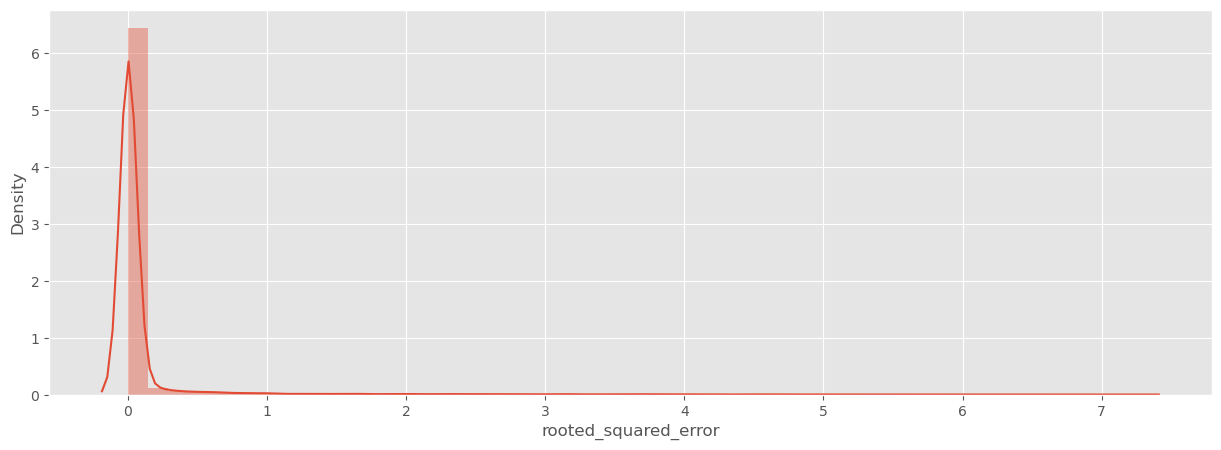

In [243]:
# Visualizamos la distribución de los errores
plt.figure(figsize = (15,5))
sns.distplot(
    results_df['rooted_squared_error']
);

Hay muchos errores pequeños y unos pocos errores grandes. Esto significa que el modelo está prediciendo bien en la gente que no compra (como es lógico) y está prediciendo mal en la gente que compra. Por lo tanto, tengo que hacer que el algoritmo se fije más en la gente que compra para que aprenda a predecir bien en estos casos.

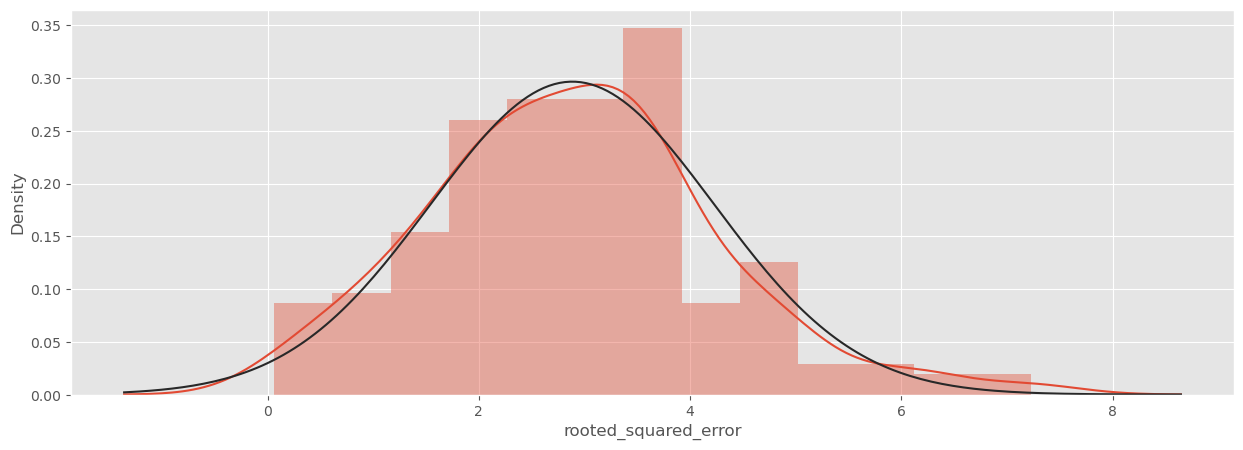

In [244]:
# Distribución del error de sólo aquellos que compran que es donde más se equivoca el algoritmo
plt.figure(figsize = (15,5))
sns.distplot(
    results_df[results_df['Target'] > 0]['rooted_squared_error'],
    fit=stats.norm # dibujamos la linea que representa la distribución normal
);

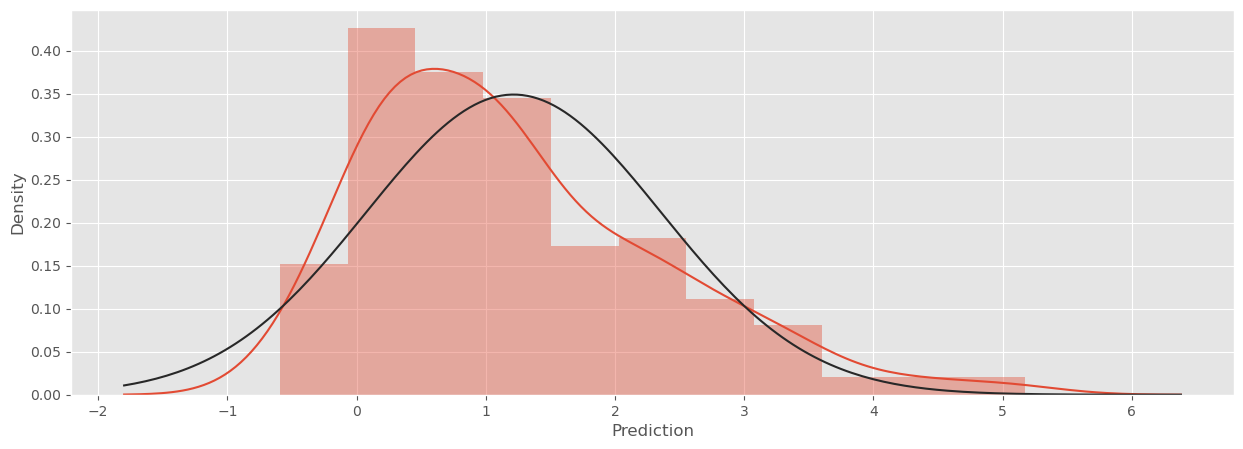

In [245]:
# Vemos la distribución del Prediction de sólo aquellos que compran que es donde más se equivoca el algoritmo
plt.figure(figsize=(15,5))
sns.distplot(
    results_df[results_df['Target'] > 0]['Prediction'],
    fit=stats.norm
);

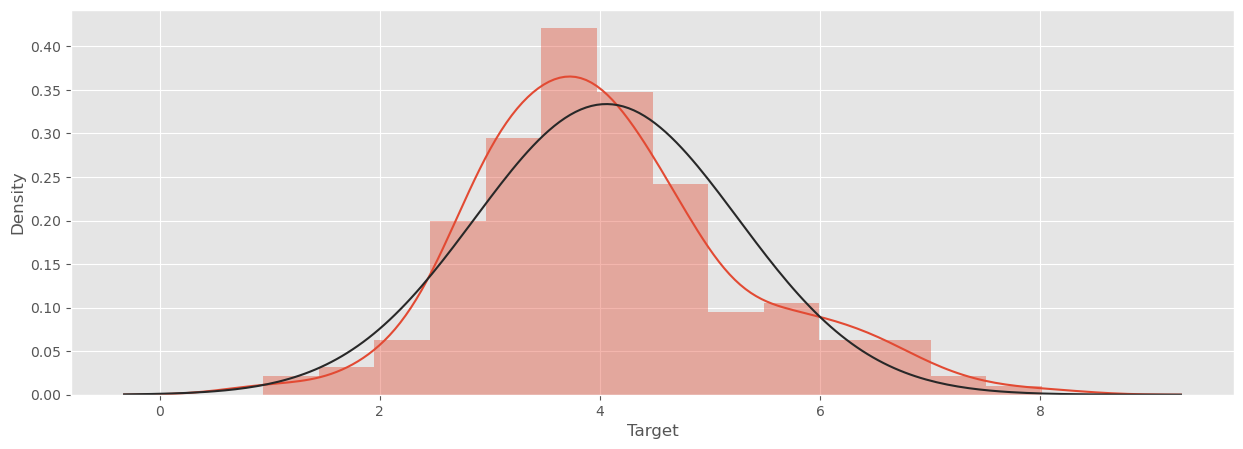

In [246]:
# Vemos la distribución del target de sólo aquellos que compran que es donde más se equivoca el algoritmo
plt.figure(figsize=(15,5))
sns.distplot(
    results_df[results_df['Target'] > 0]['Target'],
    fit=stats.norm
);

- La media del error de los que compran está en el 3 y la media del target de los que compran está en el 4. Por lo tanto la magnitud del error medio entre la gente que compra es muy grande. Esto es lo que veíamos antes, cuando nos daban unas predicciones muy por debajo del target.
- Tenemos que **rebalancear el dataset**, para ver si así conseguimos una mejor predicción (quiero que el algorimo se fije en la gente que compra para que aprenda a predecir estos casos).

*Rebalanceamos el dataset*

- Hay muchas técnicas para rebalancear el dataset, ya implementadas en python.
- Haremos un undersampling --> Hay que dividir entre los que compran y los que no compran (que será la parte que vamos a reducir) --> Esto se hace **SOLO** al train/test, **NO** al validation

In [247]:
# Los que no compran del development
df_dev_zero = df_dev[df_dev[target_log] == 0]

In [248]:
# Los que compran del development
df_dev_nonzero = df_dev[df_dev[target_log] > 0]

In [249]:
df_dev_zero.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Index: 75594 entries, 1438082600262726746_1472803483 to 5123779100307500332_1483554750
Columns: 88 entries, visitNumber to totals.newVisits_1
dtypes: float64(3), int32(4), int64(8), uint8(73)
memory usage: 13.3+ MB


In [250]:
df_dev_nonzero.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Index: 906 entries, 8885051388942907862_1472827393 to 4988517937139937145_1496230436
Columns: 88 entries, visitNumber to totals.newVisits_1
dtypes: float64(3), int32(4), int64(8), uint8(73)
memory usage: 163.7+ KB


Tengo sólo 900 personas que compran frente a 75000 que no compran

Para rebalancear el dataset, hay que ir probando. Empezamos siendo más conservadores y si vemos que el error no mejora, somos más agresivos. Lo normal es que no tengan la misma proporción. Podemo usar como benchmark un 20-80, 15-85. Dependiendo de la cantidad de datos, las proporciones entre clase minoritaria y clase mayoritaria:
- Dataset grande (100k observaciones) --> 20-80
- Dataset pequeño --> 40-60 o 30-70

En nuestro caso, empezamos siendo conservadores y aplicamos un 25-75 --> Hay 3 veces más de gente que no compra (clase 0) que de gente que compra (clase 1)

In [251]:
# número de sesiones que compran del development
n_nonzeros = len(df_dev_nonzero)
n_nonzeros

906

In [252]:
# Vamos a hacer un undersampling con el número de sesiones que no compran de:
n_zeros = n_nonzeros * 3
n_zeros

2718

In [253]:
df.sample??

Signature:
df.sample(
    n: 'int | None' = None,
    frac: 'float | None' = None,
    replace: 'bool_t' = False,
    weights=None,
    random_state: 'RandomState | None' = None,
    axis: 'Axis | None' = None,
    ignore_index: 'bool_t' = False,
) -> 'NDFrameT'
Source:   
    @final
    def sample(
        self: NDFrameT,
        n: int | None = None,
        frac: float | None = None,
        replace: bool_t = False,
        weights=None,
        random_state: RandomState | None = None,
        axis: Axis | None = None,
        ignore_index: bool_t = False,
    ) -> NDFrameT:
        """
        Return a random sample of items from an axis of object.

        You can use `random_state` for reproducibility.

        Parameters
        ----------
        n : int, optional
            Number of items from axis to return. Cannot be used with `frac`.
            Default = 1 if `frac` = None.
        frac : float, optional
            Fraction of axis items to return. Cannot be used with `

In [254]:
# Hago un sample aleatorio con el número de observaciones n_zero
df_dev_zero_sample = df_dev_zero.sample(
    n = n_zeros, # número de observaciones
    random_state = RANDOM_STATE # para que el random siempre sea el mismo
)

In [255]:
df_dev_zero_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2718 entries, 316404407482592073_1473796330 to 1302015618664715049_1480965472
Data columns (total 88 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   visitNumber                                 2718 non-null   int64  
 1   device.isMobile                             2718 non-null   int32  
 2   totals.hits                                 2718 non-null   int32  
 3   totals.transactionRevenue_log               2718 non-null   float64
 4   year                                        2718 non-null   int64  
 5   month                                       2718 non-null   int64  
 6   monthDay                                    2718 non-null   int64  
 7   weekDay                                     2718 non-null   int64  
 8   quarter                                     2718 non-null   int64  
 9   week                                

In [256]:
# unimos los ceros y los no ceros para crear el nuevo development rebalanceado
df_dev_sample = pd.concat([df_dev_zero_sample, df_dev_nonzero])

In [257]:
df_dev_sample.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 3624 entries, 316404407482592073_1473796330 to 4988517937139937145_1496230436
Columns: 88 entries, visitNumber to totals.newVisits_1
dtypes: float64(3), int32(4), int64(8), uint8(73)
memory usage: 654.7+ KB


Volvemos a repetir todos los pasos anteriores (se podría hacer una función que haga todos estos pasos)

In [258]:
# separamos atributos y target sin aplicar inplace = True
df_dev_sample_X = df_dev_sample.drop(target_log, axis=1) # atributos
df_dev_sample_y = df_dev_sample[[target_log]] # target

In [259]:
# train/test split
X_train_sample, X_test_sample, y_train_sample, y_test_sample = model_selection.train_test_split(
    df_dev_sample_X, # X
    df_dev_sample_y, # y
    random_state = RANDOM_STATE,
    test_size = 0.3 # tamaño del test (lo ponemos mayor al anterior porque ahora tengo un datset mucho más pequeño, para tener un mínimo de 1000 observaciones en test)
)

In [260]:
X_train_sample.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 2536 entries, 4501448098783068461_1493695160 to 4386324166188241612_1480961192
Columns: 87 entries, visitNumber to totals.newVisits_1
dtypes: float64(2), int32(4), int64(8), uint8(73)
memory usage: 438.4+ KB


In [261]:
y_train_sample.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 2536 entries, 4501448098783068461_1493695160 to 4386324166188241612_1480961192
Columns: 1 entries, totals.transactionRevenue_log to totals.transactionRevenue_log
dtypes: float64(1)
memory usage: 39.6+ KB


In [262]:
X_test_sample.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 1088 entries, 5059380332023098976_1486429189 to 7187268430836970062_1472604143
Columns: 87 entries, visitNumber to totals.newVisits_1
dtypes: float64(2), int32(4), int64(8), uint8(73)
memory usage: 188.1+ KB


In [263]:
y_test_sample.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 1088 entries, 5059380332023098976_1486429189 to 7187268430836970062_1472604143
Columns: 1 entries, totals.transactionRevenue_log to totals.transactionRevenue_log
dtypes: float64(1)
memory usage: 17.0+ KB


Comprobamos que tengan la misma distribución. Lo hacemos para el target que es el más crítico

In [264]:
y_train_sample.describe()

,totals.transactionRevenue_log
count,2536.000000
mean,1.027441
std,1.881846
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,8.342721


In [265]:
y_test_sample.describe()

,totals.transactionRevenue_log
count,1088.000000
mean,1.023771
std,1.845300
min,0.000000
25%,0.000000
50%,0.000000
75%,1.674320
max,8.015360


Como la media y la desviación típica son muy parecidas, van a tener distribuciones muy parecidas. Por lo tanto, si el modelo se comporta bien para el train pero no para el test podemos decir que está memorizando. 

In [266]:
# Instanciamos el modelo (con el mismo setup que el anterior)
resampled_model = xgb.XGBRegressor(
    booster = 'gbtree',
    random_state = RANDOM_STATE, 
    n_estimators = 100, # número de veces que quiero que vaya haciendo la reponderación de los errores --> 100 modelos --> 100 predicciones
    max_depth = 6, # profundidad del decisiontree (número de preguntas que quiero hacer)
    verbosity = 1 # impresión de mensajes --> 0 (silent), 1 (warning), 2 (info), and 3 (debug) 
)
# El setup del Gradiant Boosting es prácticamente el mismo que el del RandomForest (tienen los mismos parámetros)

In [267]:
%%time
resampled_model.fit(X_train_sample, y_train_sample) # entreno el modelo

Wall time: 379 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [268]:
# Hacemos la predicción
test_predictions_sampled = pd.DataFrame(
    resampled_model.predict(X_test_sample), 
    index = X_test_sample.index, 
    columns = ['Prediction_Sample'])
test_predictions_sampled.head(10)

,Prediction_Sample
sessionId,
5059380332023098976_1486429189,0.002766
2833030312056761790_1490386591,0.206795
5415086779040891341_1492124532,2.590003
580589631805288488_1481695487,0.139778
3068571312311710401_1487883929,0.106554
5136915182473070768_1488107794,-0.014225
5103624798428789625_1479139535,0.022946
4871930547578771188_1490793874,0.013411
4400040492653151202_1493238023,0.016176


In [269]:
# juntamos el target y las predicciones del sample
results_df_sample = y_test_sample.join(test_predictions_sampled)
results_df_sample.head()

,totals.transactionRevenue_log,Prediction_Sample
sessionId,,
5059380332023098976_1486429189,0.000000,0.002766
2833030312056761790_1490386591,0.000000,0.206795
5415086779040891341_1492124532,2.707383,2.590003
580589631805288488_1481695487,0.000000,0.139778
3068571312311710401_1487883929,0.000000,0.106554


In [270]:
results_df_sample.columns = ['Target_Sample', 'Prediction_Sample']
results_df_sample.head()

,Target_Sample,Prediction_Sample
sessionId,,
5059380332023098976_1486429189,0.000000,0.002766
2833030312056761790_1490386591,0.000000,0.206795
5415086779040891341_1492124532,2.707383,2.590003
580589631805288488_1481695487,0.000000,0.139778
3068571312311710401_1487883929,0.000000,0.106554


In [271]:
results_df_sample.sort_values(by = 'Target_Sample', ascending = False).head(10)

,Target_Sample,Prediction_Sample
sessionId,,
4759981878863963838_1490729055,8.015360,6.854543
5283278344963059120_1471737021,7.279850,3.291704
7107718938057621237_1473715800,7.081297,5.267385
7261302704200810675_1487644175,6.883042,5.800747
4863941202505455588_1494009960,6.685112,4.070213
4471415710206918415_1478235992,6.633318,3.268886
0432606793105704004_1485327772,6.555072,3.947776
5087617268001908286_1478632325,6.405212,4.715690
253776212101014141_1488832562,6.398379,3.618072


- Podemos apreciar que ya no hay tanta diferencia entre el target y las predicciones entre los que más gastan
- Ahora es capaz de predecir compras altas que antes no era capaz.
- **En validación, el resampled_model funcionará mejor que el primer modelo que entrenamos**

*Evaluación de resampled_model mediante métricas*

In [272]:
results_df_sample['error_sample'] = results_df_sample['Target_Sample'] - results_df_sample['Prediction_Sample']
results_df_sample['squared_error_sample'] = results_df_sample['error_sample'] ** 2
results_df_sample['rooted_squared_error_sample'] = np.sqrt(results_df_sample['squared_error_sample'])
mse_sample = results_df_sample['squared_error_sample'].mean()
rmse_sample = np.sqrt(mse_sample)
print(f'MSE_Sample: {np.round(mse_sample,4)} - RMSE_Sample: {np.round(rmse_sample,4)}')

MSE_Sample: 1.0314 - RMSE_Sample: 1.0156


Comparamos los resultados entre el primer modelo y el modelo rebalanceado

In [273]:
# Primer modelo
print(f'MSE: {np.round(mse,4)} - RMSE: {np.round(rmse,4)}')

MSE: 0.1883 - RMSE: 0.434


In [274]:
# Modelo sample
print(f'MSE_Sample: {np.round(mse_sample,4)} - RMSE_Sample: {np.round(rmse_sample,4)}')

MSE_Sample: 1.0314 - RMSE_Sample: 1.0156


- Antes teníamos muchos 0 y poquitas compras con lo que la desviación con respecto al target era muy pequeña. Ahora la proporción de gente que me compra es mayor con lo que la media aumenta y por lo tanto la desviación con respecto al target es más alta.
- Son datasets con distribuciones distintas y por lo tanto no puedo comparar las métricas de ambos datasets entre sí.
- Podemos compararlo con el modelo tonto, pero ahora ya no tiene tanto sentido porque es un modelo que predice sólo ceros, y ahora hay muchos menos ceros, por lo tanto el error se me va a ir muy arriba (Ahora hay un 25% de gente que sí compra). Aquí el modelo tonto funciona mal. Lo vemos:

In [275]:
# Comparamos el mse del modelo sample con el mse del modelo tonto
results_df_sample['squared_error_modelo_tonto_sample'] = results_df_sample['Target_Sample']**2
mse_tonto_sample = results_df_sample['squared_error_modelo_tonto_sample'].mean()
print(f'MSE_Sample: {np.round(mse_sample,4)} y Benchmark_tonto_Sample: {np.round(mse_tonto_sample,4)}')

MSE_Sample: 1.0314 y Benchmark_tonto_Sample: 4.4501


Como no puedo comparar las métricas entre los dos módelos por ser distribuciones diferentes y tampoco lo puedo comparar con el modelo tonto, ¿cómo puedo saber si el modelo es bueno?
- Lo se porque es capaz de predecir las compras altas, que antes no era capaz
- Mirando la distribución

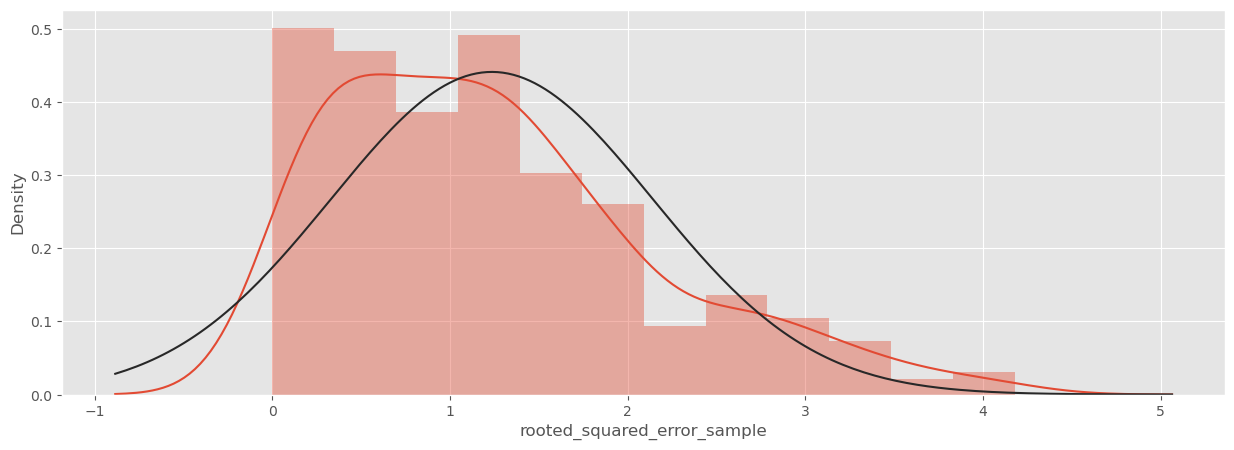

In [276]:
# distribución del error del modelo sample de la gente que compra
plt.figure(figsize=(15,5))
sns.distplot(
    results_df_sample[results_df_sample['Target_Sample'] > 0]['rooted_squared_error_sample'],
    fit=stats.norm
);

Antes teníamos una media de los errores entorno al 3, ahora la tenemos entorno al 1. Ahora la media del error entre la gente que me compra es muchísimo menor. Por lo tanto el modelo rebalanceado va a funcionar mucho mejor que el anterior.

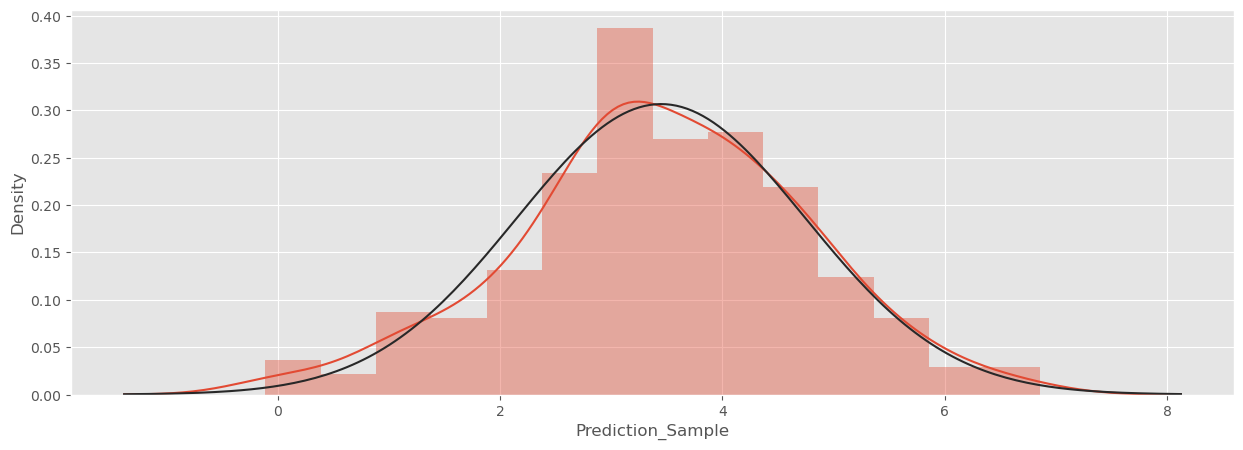

In [277]:
# Distribución del Prediction_Sample del modelo sample de la gente que compra
plt.figure(figsize=(15,5))
sns.distplot(
    results_df_sample[results_df_sample['Target_Sample'] > 0]['Prediction_Sample'],
    fit=stats.norm
);

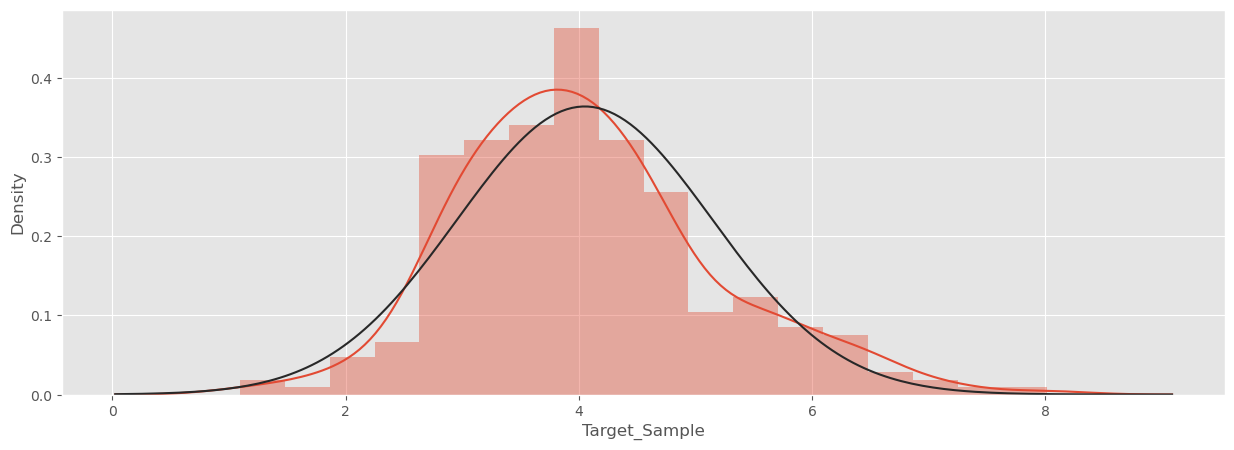

In [278]:
# Distribución del target del modelo sample de la gente que compra
plt.figure(figsize=(15,5))
sns.distplot(
    results_df_sample[results_df_sample['Target_Sample'] > 0]['Target_Sample'],
    fit=stats.norm
);

La distribución del target sigue siendo exactamente la misma, ya que no he hecho oversampling (he mantenido exactamente la misma gente que me compraba). Mientras que la distribución de la predicción ya se parece mucho más a la del target.

*Validamos el modelo rebalanceado*

In [279]:
# Predicciones del validation split
val_predictions = pd.DataFrame(
    resampled_model.predict(df_val_X),  # Atributos de validación --> nos da un array
    index = df_val_X.index, # Target de validación
    columns = ['Prediction'])

In [280]:
# Unimos el target y las predicciones del validation split
val_results_df = df_val_y.join(val_predictions)

In [281]:
val_results_df.head(10)

,totals.transactionRevenue_log,Prediction
sessionId,,
0000572434142265465_1500605115,0.0,-0.051824
0001285462512259769_1499086856,0.0,0.038284
0001399220722808057_1500076255,0.0,0.007529
0001527863526384268_1498836434,0.0,-0.027790
0001563469934876372_1498960250,0.0,0.133938
0001674026512373272_1499210304,0.0,0.426844
000170187170673177_1497108503,0.0,-0.255489
000170187170673177_1497480138,0.0,0.104530
0004912455764059748_1498617507,0.0,2.069660


In [282]:
# Renombro las columnas
val_results_df.columns = ['Target', 'Prediction']

In [283]:
# Validamos con las métricas
val_results_df['error'] = val_results_df['Target'] - val_results_df['Prediction']
val_results_df['squared_error'] = val_results_df['error'] ** 2
val_results_df['rooted_squared_error'] = np.sqrt(val_results_df['squared_error'])
mse_val = val_results_df['squared_error'].mean()
rmse_val = np.sqrt(mse_val)
print(f'MSE_Val: {np.round(mse_val,4)} - RMSE_Val: {np.round(rmse_val,4)}')

MSE_Val: 0.669 - RMSE_Val: 0.8179


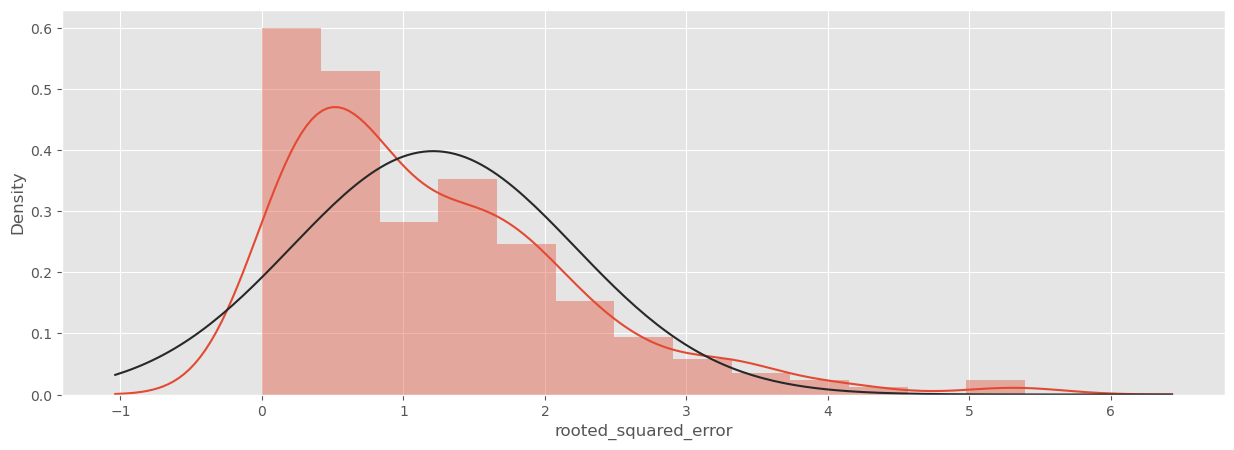

In [284]:
# distribución del error de la gente que compra en validacion
plt.figure(figsize=(15,5))
sns.distplot(
    val_results_df[val_results_df['Target'] > 0]['rooted_squared_error'],
    fit=stats.norm
);

*Comprobación del overfiting*

In [285]:
# Instanciamos el modelo (con el mismo setup que el anterior)
resampled_model_rmse = xgb.XGBRegressor(
    booster = 'gbtree',
    eval_metric = "rmse", # métrica de evaluación
    random_state = RANDOM_STATE, 
    n_estimators = 100, # número de veces que quiero que vaya haciendo la reponderación de los errores --> 100 modelos --> 100 predicciones
    max_depth = 6, # profundidad del decisiontree (número de preguntas que quiero hacer)
    verbosity = 1 # impresión de mensajes --> 0 (silent), 1 (warning), 2 (info), and 3 (debug) 
)
# El setup del Gradiant Boosting es prácticamente el mismo que el del RandomForest (tienen los mismos parámetros)


In [286]:
%%time
resampled_model_rmse.fit( # entreno el modelo
    X_train_sample, y_train_sample,
    eval_set = [(X_train_sample, y_train_sample), (X_test_sample, y_test_sample)],
    verbose = True
) 

[0]	validation_0-rmse:1.51154	validation_1-rmse:1.52228
[1]	validation_0-rmse:1.22818	validation_1-rmse:1.27740
[2]	validation_0-rmse:1.04765	validation_1-rmse:1.12463
[3]	validation_0-rmse:0.92304	validation_1-rmse:1.04240
[4]	validation_0-rmse:0.84414	validation_1-rmse:1.00107
[5]	validation_0-rmse:0.79519	validation_1-rmse:0.98262
[6]	validation_0-rmse:0.74280	validation_1-rmse:0.97027
[7]	validation_0-rmse:0.70683	validation_1-rmse:0.96940
[8]	validation_0-rmse:0.68534	validation_1-rmse:0.96700
[9]	validation_0-rmse:0.64970	validation_1-rmse:0.97128
[10]	validation_0-rmse:0.62789	validation_1-rmse:0.96574
[11]	validation_0-rmse:0.59806	validation_1-rmse:0.96946
[12]	validation_0-rmse:0.58593	validation_1-rmse:0.97178
[13]	validation_0-rmse:0.57629	validation_1-rmse:0.97280
[14]	validation_0-rmse:0.57110	validation_1-rmse:0.97492
[15]	validation_0-rmse:0.54012	validation_1-rmse:0.97604
[16]	validation_0-rmse:0.53307	validation_1-rmse:0.97687
[17]	validation_0-rmse:0.52838	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

Vemos que el modelo ha memorizado, independientemente del número de estimadores que se utilicen, por lo que tenemos que reducir el número de preguntas que hace. Le daremos una profundidad de 3.

In [287]:
# Instanciamos el modelo (con el mismo setup que el anterior)
resampled_model_rmse = xgb.XGBRegressor(
    booster = 'gbtree',
    eval_metric = "rmse", # métrica de evaluación
    random_state = RANDOM_STATE, 
    n_estimators = 100, # número de veces que quiero que vaya haciendo la reponderación de los errores --> 100 modelos --> 100 predicciones
    max_depth = 3, # profundidad del decisiontree (número de preguntas que quiero hacer)
    verbosity = 1 # impresión de mensajes --> 0 (silent), 1 (warning), 2 (info), and 3 (debug) 
)
# El setup del Gradiant Boosting es prácticamente el mismo que el del RandomForest (tienen los mismos parámetros)

In [288]:
%%time
resampled_model_rmse.fit( # entreno el modelo
    X_train_sample, y_train_sample,
    eval_set = [(X_train_sample, y_train_sample), (X_test_sample, y_test_sample)],
    verbose = True
) 

[0]	validation_0-rmse:1.55929	validation_1-rmse:1.52702
[1]	validation_0-rmse:1.31226	validation_1-rmse:1.27931
[2]	validation_0-rmse:1.16041	validation_1-rmse:1.13422
[3]	validation_0-rmse:1.07151	validation_1-rmse:1.05292
[4]	validation_0-rmse:1.01379	validation_1-rmse:1.00520
[5]	validation_0-rmse:0.98028	validation_1-rmse:0.97473
[6]	validation_0-rmse:0.95907	validation_1-rmse:0.96161
[7]	validation_0-rmse:0.94442	validation_1-rmse:0.95102
[8]	validation_0-rmse:0.93175	validation_1-rmse:0.94612
[9]	validation_0-rmse:0.92052	validation_1-rmse:0.93975
[10]	validation_0-rmse:0.91180	validation_1-rmse:0.93985
[11]	validation_0-rmse:0.90527	validation_1-rmse:0.93814
[12]	validation_0-rmse:0.89767	validation_1-rmse:0.93529
[13]	validation_0-rmse:0.88963	validation_1-rmse:0.93417
[14]	validation_0-rmse:0.88485	validation_1-rmse:0.93299
[15]	validation_0-rmse:0.87971	validation_1-rmse:0.92858
[16]	validation_0-rmse:0.87411	validation_1-rmse:0.93035
[17]	validation_0-rmse:0.86858	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

Utilizaremos una profundidad de árbol de 3 y 7 estimadores

In [289]:
# Instancio el modelo
resampled_model = xgb.XGBRegressor(
    booster = 'gbtree',
    random_state = RANDOM_STATE, 
    n_estimators = 7, # número de veces que quiero que vaya haciendo la reponderación de los errores --> 100 modelos --> 100 predicciones
    max_depth = 3, # profundidad del decisiontree (número de preguntas que quiero hacer)
    verbosity = 1 # impresión de mensajes --> 0 (silent), 1 (warning), 2 (info), and 3 (debug) 
)

# Entreno el modelo
resampled_model.fit(X_train_sample, y_train_sample)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=7, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [290]:
# Hacemos la predicción
test_predictions_sampled = pd.DataFrame(
    resampled_model.predict(X_test_sample), 
    index = X_test_sample.index, 
    columns = ['Prediction_Sample'])

# juntamos el target y las predicciones del sample
results_df_sample = y_test_sample.join(test_predictions_sampled)
# renombro las columnas
results_df_sample.columns = ['Target_Sample', 'Prediction_Sample']
# Ordeno de mayor a menor gasto
results_df_sample.sort_values(by = 'Target_Sample', ascending = False).head(10)

,Target_Sample,Prediction_Sample
sessionId,,
4759981878863963838_1490729055,8.015360,4.284503
5283278344963059120_1471737021,7.279850,3.414380
7107718938057621237_1473715800,7.081297,4.284503
7261302704200810675_1487644175,6.883042,4.181097
4863941202505455588_1494009960,6.685112,4.215508
4471415710206918415_1478235992,6.633318,3.441290
0432606793105704004_1485327772,6.555072,4.073001
5087617268001908286_1478632325,6.405212,3.855101
253776212101014141_1488832562,6.398379,2.768567


In [291]:
#Evaluación de resampled_model mediante métricas
results_df_sample['error_sample'] = results_df_sample['Target_Sample'] - results_df_sample['Prediction_Sample']
results_df_sample['squared_error_sample'] = results_df_sample['error_sample'] ** 2
results_df_sample['rooted_squared_error_sample'] = np.sqrt(results_df_sample['squared_error_sample'])
mse_sample = results_df_sample['squared_error_sample'].mean()
rmse_sample = np.sqrt(mse_sample)
print(f'MSE_Sample: {np.round(mse_sample,4)} - RMSE_Sample: {np.round(rmse_sample,4)}')

MSE_Sample: 0.9247 - RMSE_Sample: 0.9616


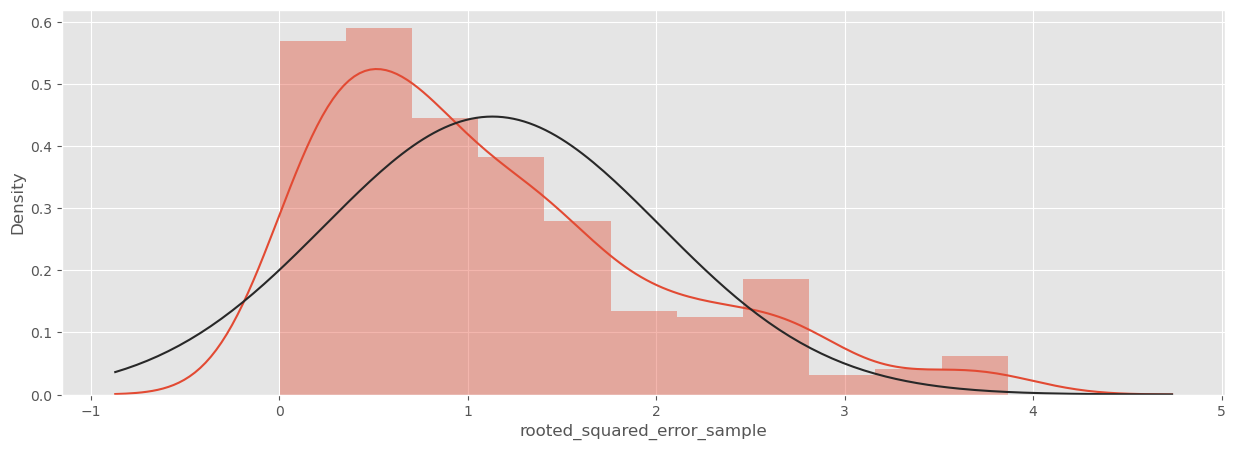

In [292]:
# distribución del error del modelo sample de la gente que compra
plt.figure(figsize=(15,5))
sns.distplot(
    results_df_sample[results_df_sample['Target_Sample'] > 0]['rooted_squared_error_sample'],
    fit=stats.norm
);

Antes teníamos una media de los errores entorno al 3, ahora la tenemos entorno al 1. Ahora la media del error entre la gente que me compra es muchísimo menor. Por lo tanto el modelo rebalanceado va a funcionar mucho mejor que el anterior.

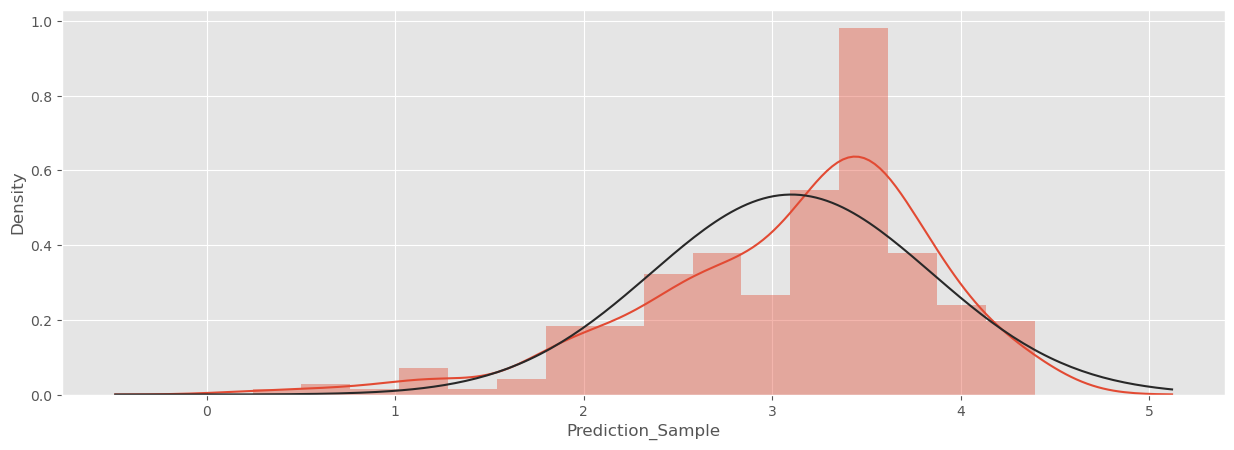

In [293]:
# Distribución del Prediction_Sample del modelo sample de la gente que compra
plt.figure(figsize=(15,5))
sns.distplot(
    results_df_sample[results_df_sample['Target_Sample'] > 0]['Prediction_Sample'],
    fit=stats.norm
);

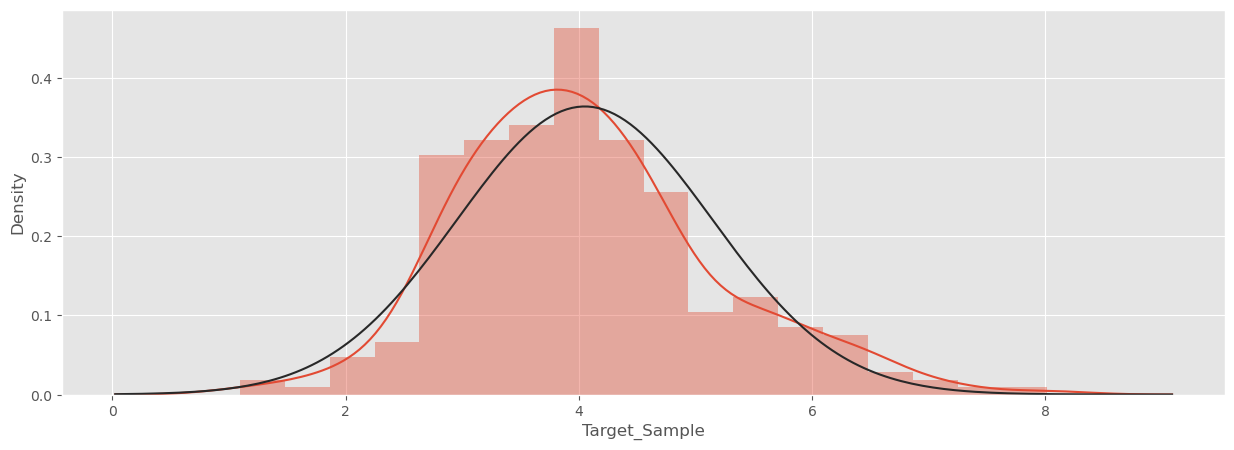

In [294]:
# Distribución del target del modelo sample de la gente que compra
plt.figure(figsize=(15,5))
sns.distplot(
    results_df_sample[results_df_sample['Target_Sample'] > 0]['Target_Sample'],
    fit=stats.norm
);

*Generamos funciones para hacerlo todo de golpe*

In [295]:
def result_xgbTree (X_train, y_train, X_test, y_test, random_state, max_depth, n_estimators):
    ''' 
    Target vs Prediction en un problema de regresión utilizando el XGBRegressor.
    Evaluación del modelo mediante las métricas mse y rmse
    
    '''
    # Instancio el modelo
    model = xgb.XGBRegressor(booster = 'gbtree', random_state = random_state, n_estimators = n_estimators, max_depth = max_depth, verbosity = 1)
    # Entreno el modelo
    model.fit(X_train, y_train)
    # Hacemos la predicción y guardamos en un dataframe
    test_prediction = pd.DataFrame(model.predict(X_test), index = X_test.index, columns = ['Prediction'])
    # result_df (target vs prediction)
    results_df = y_test.join(test_prediction)
    # renombro las columnas del result_df
    results_df.columns = ['Target', 'Prediction']
    #Evaluación del model mediante métricas mse y rmse
    results_df['error'] = results_df['Target'] - results_df['Prediction']
    results_df['squared_error'] = results_df['error'] ** 2
    results_df['rooted_squared_error'] = np.sqrt(results_df['squared_error'])
    mse = results_df['squared_error'].mean()
    rmse = np.sqrt(mse)
    print(f'MSE: {np.round(mse,4)} - RMSE: {np.round(rmse,4)}')

    return results_df

In [296]:
results_df_sample_tree = result_xgbTree (
    X_train = X_train_sample , 
    y_train = y_train_sample, 
    X_test = X_test_sample,
    y_test = y_test_sample, 
    random_state = RANDOM_STATE, 
    max_depth = 3, 
    n_estimators = 7
)
results_df_sample_tree.head()

MSE: 0.9247 - RMSE: 0.9616


,Target,Prediction,error,squared_error,rooted_squared_error
sessionId,,,,,
5059380332023098976_1486429189,0.000000,0.030258,-0.030258,0.000916,0.030258
2833030312056761790_1490386591,0.000000,0.441446,-0.441446,0.194875,0.441446
5415086779040891341_1492124532,2.707383,2.496804,0.210579,0.044343,0.210579
580589631805288488_1481695487,0.000000,0.178037,-0.178037,0.031697,0.178037
3068571312311710401_1487883929,0.000000,0.030258,-0.030258,0.000916,0.030258


In [297]:
def figure_xgb (dataframe):
    ''' 
    Distribución de los errores, de las predicciones y del target

    '''
    for img in [dataframe.columns[4], dataframe.columns[1], dataframe.columns[0]]:
        plt.figure(figsize=(15,5))
        sns.distplot(
        dataframe[dataframe['Target'] > 0][img],
        fit=stats.norm
        );

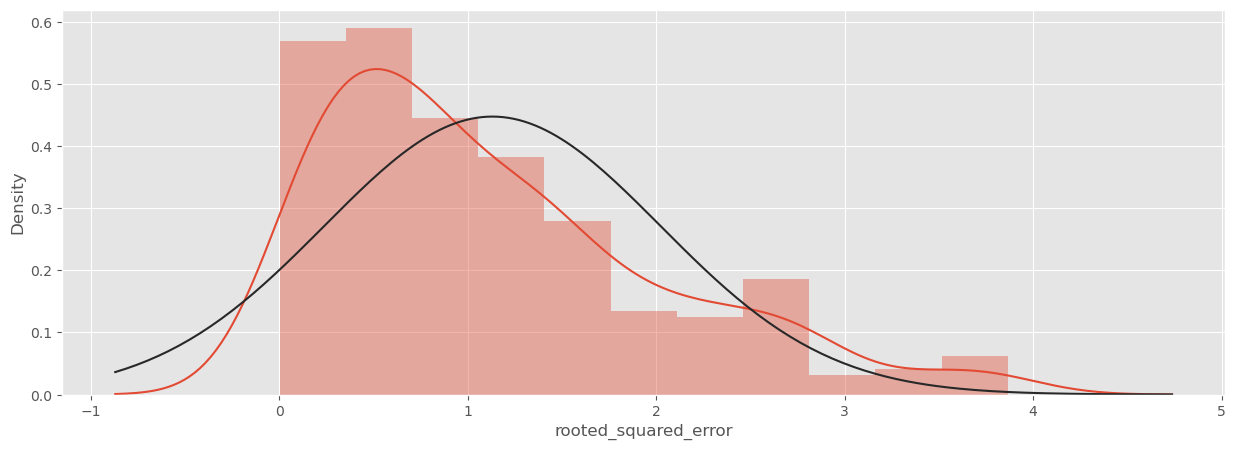

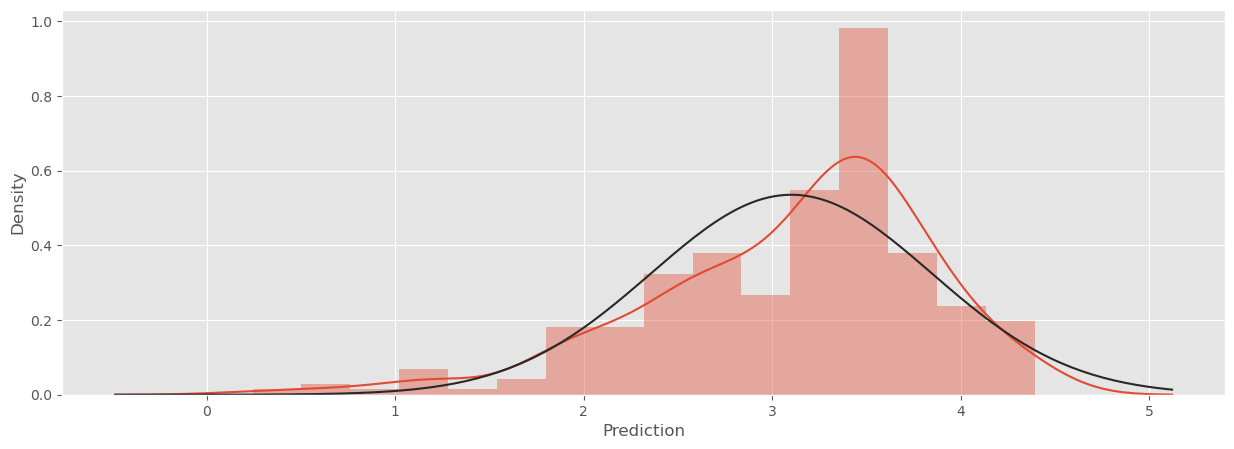

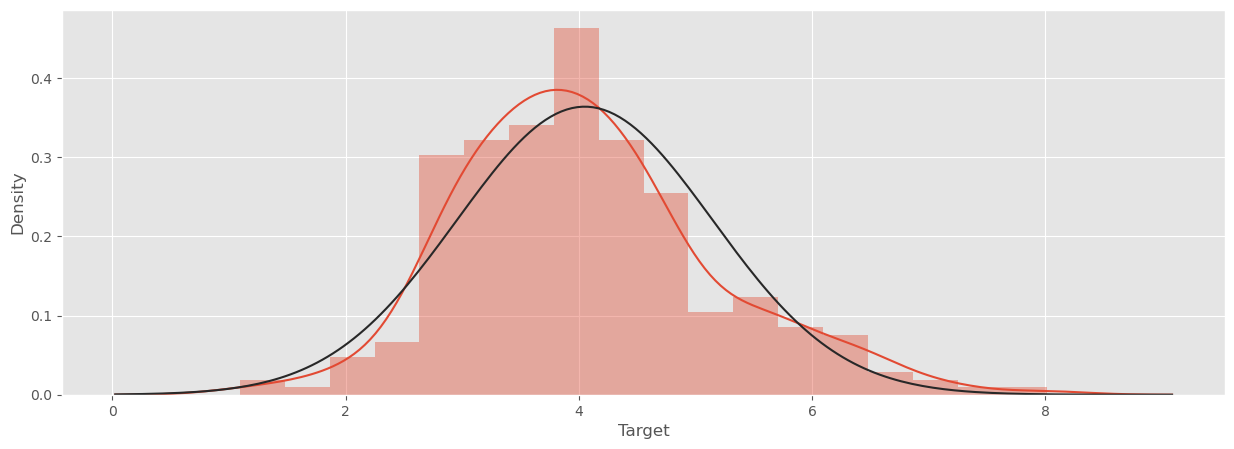

In [298]:
figure_xgb (dataframe = results_df_sample_tree)

*Feature Importances*

In [299]:
# Atributos más importantes
xgb_feature_importances = pd.Series(
    resampled_model.feature_importances_, 
    index = X_train_sample.columns
).sort_values(ascending = False).head(20)
xgb_feature_importances

totals.hits                                0.479780
geoNetwork.continent_Americas              0.162018
channelGrouping_Organic Search             0.079769
device.deviceCategory_mobile               0.055289
visitHour                                  0.048785
visitNumber                                0.041897
device.operatingSystem_Macintosh           0.028976
device.browser_Chrome                      0.024719
channelGrouping_Direct                     0.023122
channelGrouping_Referral                   0.022575
device.operatingSystem_Chrome OS           0.020643
monthDay                                   0.012429
geoNetwork.subContinent_Middle Africa      0.000000
geoNetwork.subContinent_Southern Africa    0.000000
geoNetwork.subContinent_Western Asia       0.000000
geoNetwork.subContinent_Western Africa     0.000000
geoNetwork.subContinent_Southern Europe    0.000000
geoNetwork.subContinent_Southern Asia      0.000000
geoNetwork.subContinent_Melanesia          0.000000
geoNetwork.s

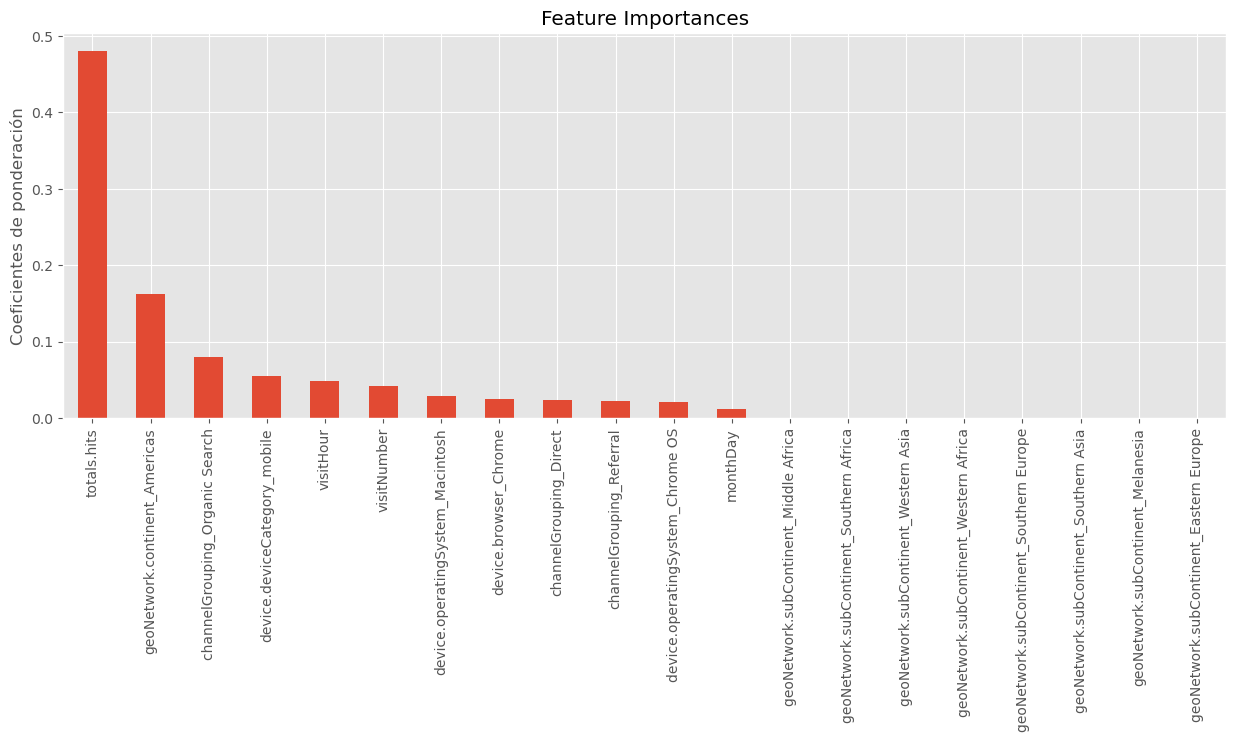

In [300]:
# Visualizamos los atributos importantes
plt.figure(figsize=(15,5))
xgb_feature_importances.plot(kind = 'bar', ylabel = 'Coeficientes de ponderación')
plt.title('Feature Importances');

A la hora de llevarlo a producción, me quedaría con los 12 primeros atributos

**2.- XGBoost** --> con Regresión Lineal

In [301]:
def result_xgbLineal (X_train, y_train, X_test, y_test):
    ''' 
    Target vs Prediction en un problema de regresión utilizando el XGBRegressor.
    Evaluación del modelo mediante las métricas mse y rmse
    
    '''
    # Instancio el modelo
    model = xgb.XGBRegressor(booster = 'gblinear', verbosity = 1)
    # Entreno el modelo
    model.fit(X_train, y_train)
    # Hacemos la predicción y guardamos en un dataframe
    test_prediction = pd.DataFrame(model.predict(X_test), index = X_test.index, columns = ['Prediction'])
    # result_df (target vs prediction)
    results_df = y_test.join(test_prediction)
    # renombro las columnas del result_df
    results_df.columns = ['Target', 'Prediction']
    #Evaluación del model mediante métricas mse y rmse
    results_df['error'] = results_df['Target'] - results_df['Prediction']
    results_df['squared_error'] = results_df['error'] ** 2
    results_df['rooted_squared_error'] = np.sqrt(results_df['squared_error'])
    mse = results_df['squared_error'].mean()
    rmse = np.sqrt(mse)
    print(f'MSE: {np.round(mse,4)} - RMSE: {np.round(rmse,4)}')

    return results_df

In [302]:
results_df_sample_lineal = result_xgbLineal (X_train = X_train_sample, y_train = y_train_sample, X_test = X_test_sample, y_test = y_test_sample)
results_df_sample_lineal.sort_values(by = 'Target', ascending = False)

MSE: 1.1725 - RMSE: 1.0828


,Target,Prediction,error,squared_error,rooted_squared_error
sessionId,,,,,
4759981878863963838_1490729055,8.015360,5.069016,2.946344,8.680945,2.946344
5283278344963059120_1471737021,7.279850,3.617985,3.661865,13.409255,3.661865
7107718938057621237_1473715800,7.081297,4.058229,3.023068,9.138939,3.023068
7261302704200810675_1487644175,6.883042,4.323370,2.559673,6.551925,2.559673
4863941202505455588_1494009960,6.685112,4.124288,2.560824,6.557817,2.560824
...,...,...,...,...,...
87109475150246226_1489667378,0.000000,0.047116,-0.047116,0.002220,0.047116
4379775968824328227_1483537542,0.000000,0.006856,-0.006856,0.000047,0.006856
7067296665967668087_1488199537,0.000000,-0.410359,0.410359,0.168395,0.410359


In [303]:
results_df_sample_tree

,Target,Prediction,error,squared_error,rooted_squared_error
sessionId,,,,,
5059380332023098976_1486429189,0.000000,0.030258,-0.030258,0.000916,0.030258
2833030312056761790_1490386591,0.000000,0.441446,-0.441446,0.194875,0.441446
5415086779040891341_1492124532,2.707383,2.496804,0.210579,0.044343,0.210579
580589631805288488_1481695487,0.000000,0.178037,-0.178037,0.031697,0.178037
3068571312311710401_1487883929,0.000000,0.030258,-0.030258,0.000916,0.030258
...,...,...,...,...,...
8293630998886357548_1473855669,0.000000,0.385314,-0.385314,0.148467,0.385314
1022140804745247367_1476598024,0.000000,2.785280,-2.785280,7.757782,2.785280
0769891055069398469_1475454049,3.217675,3.675765,-0.458089,0.209846,0.458089


*Comparamos el xgbregressor aplicando decision tree con el xgbregressor aplicando regresión lineal para el dataset rebalanceado*

- Métricas con el decision tree --> MSE: 0.9247 - RMSE: 0.9616
- Métricas con el lineal --> MSE: 1.174 - RMSE: 1.0835

In [304]:
comp_results_df_sample = results_df_sample_tree[['Target', 'Prediction', 'error']]
comp_results_df_sample.columns = ['Target', 'Prediction_Tree', 'Error_Tree']
comp_results_df_sample['Prediction_Lineal'] = results_df_sample_lineal['Prediction']
comp_results_df_sample['Error_Lineal'] = results_df_sample_lineal['error']
comp_results_df_sample.sort_values(by='Target', ascending=False)

,Target,Prediction_Tree,Error_Tree,Prediction_Lineal,Error_Lineal
sessionId,,,,,
4759981878863963838_1490729055,8.015360,4.284503,3.730858,5.069016,2.946344
5283278344963059120_1471737021,7.279850,3.414380,3.865470,3.617985,3.661865
7107718938057621237_1473715800,7.081297,4.284503,2.796794,4.058229,3.023068
7261302704200810675_1487644175,6.883042,4.181097,2.701946,4.323370,2.559673
4863941202505455588_1494009960,6.685112,4.215508,2.469604,4.124288,2.560824
...,...,...,...,...,...
87109475150246226_1489667378,0.000000,0.030258,-0.030258,0.047116,-0.047116
4379775968824328227_1483537542,0.000000,0.030258,-0.030258,0.006856,-0.006856
7067296665967668087_1488199537,0.000000,0.136881,-0.136881,-0.410359,0.410359


Distribuciones de ambos errores

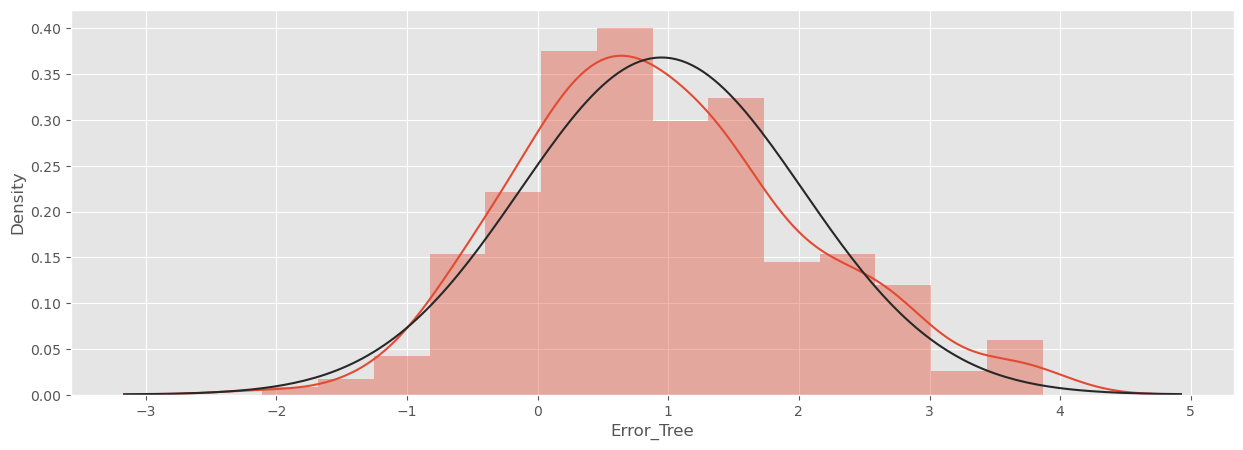

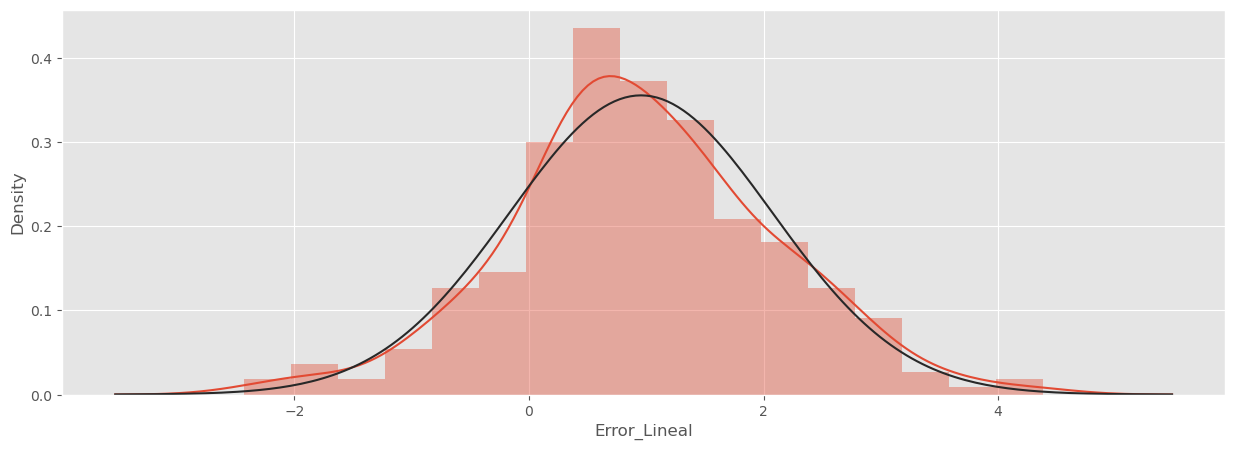

In [305]:
for img in [comp_results_df_sample.columns[2], comp_results_df_sample.columns[4]]:
    plt.figure(figsize=(15,5))
    sns.distplot(
    comp_results_df_sample[comp_results_df_sample['Target'] > 0][img],
    fit=stats.norm
    );

Tanto las métricas como las distribuciones de los errores de ambos algoritmos son muy parecidos.

Next Steps:
- Ahora que tenemos las funciones creadas, podríamos probar diferentes modelos rebalanceados (diferentes proporciones en el undersampling, en vez de undersampling hacer un oversampling, etc) para ver si mejora rendimiento. De hecho al hacer el undersampling obtenemos muy pocas filas en el test, por lo que seguramente nos de mejores resultados hacer un oversampling.
- Comprobar que el modelo resultante se comporta bien para el 100% del dataset (En este ejercicio se ha hecho para un 10% aleatorio por ser un dataset muy grande)
- Finalmente aplicar el modelo a las top_features ( 10-15 feature_importance ).

### 5.1.2. k-Folk Cross Validation

Vamos a hacer 10 iteracciones.
- En la primera iteracción, el primel fold se usa para el test y el resto para el train.
- En la segunda iteracción, el segundo fold se usa para el test y el resto para el train.
- Así sucesivamente hasta hacer las 10 iteracciones

In [306]:
# Defino el cross validation
kf = model_selection.KFold(
    n_splits = 10, 
    # k=10 (10 iteracciones con diferentes particiones aleatorias Train/Test)
    # Tengo 10 datasets distintos --> 10 modelos distintos
    random_state = 42, 
    # Si shuffle=True, random_state afectaría el orden de los índices, que controla la aleatoriedad de los fold 
    # Si shuffle=False, random_state no tiene efecto
    shuffle = True # mezclar los datos antes de dividirlos en batches.
)

In [308]:
# Genera los índices de las muestras del train y del test (df_development)
kf.split(
    df_dev, # Le paso el development
    y = None, # array del target
    groups = None # array de etiquetas para las muestras usadas en el split
)

<generator object _BaseKFold.split at 0x000001F8E79163C0>

In [309]:
# Indices del train y del train de las 10 iteracciones
for train_index, test_index in kf.split(df_dev):
    print("TRAIN:", train_index, "Samples_Train:", len(train_index), '\n')
    print("TEST:", test_index, "Samples_Test:", len(test_index))

TRAIN: [    0     1     2 ... 76497 76498 76499] Samples_Train: 68850 

TEST: [   35    39    75 ... 76442 76480 76489] Samples_Test: 7650
TRAIN: [    0     1     2 ... 76497 76498 76499] Samples_Train: 68850 

TEST: [    4     6    54 ... 76474 76482 76495] Samples_Test: 7650
TRAIN: [    0     1     2 ... 76496 76498 76499] Samples_Train: 68850 

TEST: [   12    32    33 ... 76453 76457 76497] Samples_Test: 7650
TRAIN: [    0     1     2 ... 76497 76498 76499] Samples_Train: 68850 

TEST: [    7    11    21 ... 76475 76486 76491] Samples_Test: 7650
TRAIN: [    2     4     5 ... 76497 76498 76499] Samples_Train: 68850 

TEST: [    0     1     3 ... 76466 76487 76492] Samples_Test: 7650
TRAIN: [    0     1     2 ... 76497 76498 76499] Samples_Train: 68850 

TEST: [   10    43    46 ... 76443 76450 76481] Samples_Test: 7650
TRAIN: [    0     1     2 ... 76495 76496 76497] Samples_Train: 68850 

TEST: [    8    29    63 ... 76490 76498 76499] Samples_Test: 7650
TRAIN: [    0     1     2 .

In [310]:
# Lista de los accuracy de las 10 iteracciones
scores_list = [] # almaceno los acc de los modelos
for train_index, test_index in kf.split(df_dev):
    print("TRAIN:", train_index, "Samples_Train:", len(train_index)) # índices y número de filas del train
    print("TEST:", test_index, "Samples_Test:", len(test_index)) # índices y número de filas del test
    X_train, X_test = df_dev_X.iloc[train_index], df_dev_X.iloc[test_index]
    y_train, y_test = df_dev_y.iloc[train_index], df_dev_y.iloc[test_index]
    model = xgb.XGBRegressor(booster = 'gbtree', random_state = RANDOM_STATE, n_estimators = 7, max_depth = 3, verbosity = 1) # Instancio el modelo
    model.fit(X_train, y_train) # Entreno el modelo
    _score = model.score(X_test, y_test) # Determino el accuracy del modelo
    scores_list.append(_score) # Almaceno el accuracy del modelo en una lista
    print("Acc:",_score,"\n") # Imprimo el acc del modelo
print("Accuracy de cada iteracción:")
scores_list # lista de acc de todos los modelos

TRAIN: [    0     1     2 ... 76497 76498 76499] Samples_Train: 68850
TEST: [   35    39    75 ... 76442 76480 76489] Samples_Test: 7650
Acc: 0.21710390425892379 

TRAIN: [    0     1     2 ... 76497 76498 76499] Samples_Train: 68850
TEST: [    4     6    54 ... 76474 76482 76495] Samples_Test: 7650
Acc: 0.2009898312021221 

TRAIN: [    0     1     2 ... 76496 76498 76499] Samples_Train: 68850
TEST: [   12    32    33 ... 76453 76457 76497] Samples_Test: 7650
Acc: 0.20881788037936977 

TRAIN: [    0     1     2 ... 76497 76498 76499] Samples_Train: 68850
TEST: [    7    11    21 ... 76475 76486 76491] Samples_Test: 7650
Acc: 0.2138669547671539 

TRAIN: [    2     4     5 ... 76497 76498 76499] Samples_Train: 68850
TEST: [    0     1     3 ... 76466 76487 76492] Samples_Test: 7650
Acc: 0.19343804413094068 

TRAIN: [    0     1     2 ... 76497 76498 76499] Samples_Train: 68850
TEST: [   10    43    46 ... 76443 76450 76481] Samples_Test: 7650
Acc: 0.1482364930540393 

TRAIN: [    0     1

[0.21710390425892379,
 0.2009898312021221,
 0.20881788037936977,
 0.2138669547671539,
 0.19343804413094068,
 0.1482364930540393,
 0.24235845658521926,
 0.1994962549089364,
 0.22642530916338965,
 0.25120665704575895]